# <u><center>MARKET MIX MODELLING</center></u>

### TEAM:
>**Suel Ahmed<br>Raveena Khan<br>Ujval Patel<br>Nagaraju Gunda**

**Submission Date - 16-Sept-2019**<br><br>
**Data Set File** - Following data files are available in the working directory :
                  - ConsumerElectronics.csv
                  - Media data and other information.xlsx
                  - Product Details.docx
                  - ONATARIO-2015.csv, ONTARIO-2016.csv

# Business Understanding
**ElecKart is an e-commerce firm based out of Ontario, Canada specialising in electronic products. Over the last one year, they had spent a significant amount of money on marketing. Occasionally, they had also offered big-ticket promotions (similar to the Big Billion Day). They are about to create a marketing budget for the next year, which includes spending on commercials, online campaigns, and pricing & promotion strategies. The CFO feels that the money spent over the last 12 months on marketing was not sufficiently impactful, and, that they can either cut on the budget or reallocate it optimally across marketing levers to improve the revenue response.**

# Problem Statement
**Imagine that you are a part of the marketing team working on budget optimisation. You need to develop a market mix model to observe the actual impact of different marketing variables over the last year. Using your understanding of the model, you have to recommend the optimal budget allocation for different marketing levers for the next year.**

## 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import datetime as dt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, SCORERS
from math import sqrt
from docx import Document 
import io
import csv
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

%matplotlib inline

**Function Definitions:**

In [2]:
# Calculating Adstock
def get_df_with_calculated_ad_stocks(df, cols, engagement_factor):    
    df_adstocks = df.copy()
    
    #loop through dataset to calculate ad stock values
    for col in cols:
        #initialize ad stock vector
        ad_stock_vector = []

        #initialize ad_stock_value
        ad_stock_value = 0.0
        
        for index, row in df.iterrows():
            ad_stock_value = df.at[index, col] + (ad_stock_value * engagement_factor)
            df_adstocks.at[index, col] = ad_stock_value
    
    return df_adstocks

In [3]:
# Using python-docx for reading document
def read_document_table(filename, tab_id=None, **kwargs):
    def read_doctab(tab, **kwargs):
        stringbuf = io.StringIO()
        writer = csv.writer(stringbuf)
        for row in tab.rows:
            writer.writerow(cell.text for cell in row.cells)
        stringbuf.seek(0)
        return pd.read_csv(stringbuf, **kwargs)

    doc = Document(filename)
    if tab_id is None:
        return [read_doctab(tab, **kwargs) for tab in doc.tables]
    else:
        try:
            return read_doctab(doc.tables[tab_id], **kwargs)
        except IndexError:
            print('table id does not exist')

In [4]:
# Scatter Plot between GMV and week based on holiday, special sales & payday
def EDA_1(df):
    plt.figure(figsize=(16, 4))
    hues = ['holiday_flag', 'sale_day_flag', 'payday_flag']
    for i, hue in enumerate(hues):
        plt.subplot(1, len(hues), i+1)
        sns.scatterplot(x='week', y='gmv', hue=hue, data=df)

In [5]:
# Scatter Plot between payment type and week based on holiday, special sales & payday
def EDA_2(df):
    plt.figure(figsize=(16, 16))
    y_cols = ['Prepaid', 'COD']
    hues = ['holiday_flag', 'sale_day_flag', 'payday_flag']
    plot = 0
    for i, hue in enumerate(hues):
        for j, y_col in enumerate(y_cols):
            plot += 1
            plt.subplot(len(hues), len(y_cols), plot)
            sns.barplot(x='week', y=y_col, hue=hue, data=df)

In [6]:
# Scatter Plot of adstocks based on holiday, special sales & payday
def EDA_3(df, y_col):
    plt.figure(figsize=(30, 20))
    x_cols = ['Radio', 'TV', 'Online marketing', 'Content Marketing', 'Affiliates', 'SEM', 'Digital']
    hues = ['holiday_flag', 'sale_day_flag', 'payday_flag']
    plot = 0
    for i, hue in enumerate(hues):
        for j, x_col in enumerate(x_cols):
            plot += 1
            plt.subplot(len(hues), len(x_cols), plot)
            if y_col=='week':
                sns.lineplot(y=x_col, x=y_col, hue=hue, data=df)
            else:
                sns.lineplot(x=x_col, y=y_col, hue=hue, data=df)

In [7]:
# Plot beween shelf_inflation price, discount_list, discount_mrp and weeks
def EDA_4(df):
    plt.figure(figsize=(30, 20))
    y_cols=['shelf_inflation','discout_list','discout_mrp']
    hues = ['holiday_flag', 'sale_day_flag', 'payday_flag']
    plot = 0
    for i, hue in enumerate(hues):
        for j, y_col in enumerate(y_cols):
            plot += 1
            plt.subplot(len(hues), len(y_cols), plot)
            sns.lineplot(x='week', y=y_col, hue=hue, data=df)

In [8]:
def product_type_count(df):
    sns.countplot(df['product_type'], hue=df['product_type'])
    plt.xlabel('product_type')
    plt.yscale('log')
    plt.title("Product Type Count for {0}".format(df['product_analytic_sub_category'].iloc[0]))
    plt.show()

In [9]:
def get_vif(X_df):
    if 'const' in X_df.columns:
        X_df = X_df.drop(columns=['const'])
    vif = pd.DataFrame()
    vif['Features'] = X_df.columns
    vif['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [10]:
def get_model_and_print_summary(x_train, y_train):
    lm = sm.OLS(y_train,x_train).fit()
    print(lm.summary())
    print('\n\nVIF Values\n')
    print(get_vif(x_train))
    return lm

In [11]:
def evaluate_model(lm, X, y):
    y_pred = lm.predict(X)

    print("r2 score is {0}%".format(np.round(r2_score(y,y_pred)*100,2)))
    
    print("RMSE is {0}".format(np.round(sqrt(mean_squared_error(y, y_pred)),2)))
    
    plt.scatter(y,y_pred)
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [12]:
def kfold(lr_model, x_train, y_train, x_test, y_test):
    folds = KFold(n_splits=6, random_state=42, shuffle=True)
    
    cv_results = cross_val_score(lr_model, x_train, y_train, cv = folds, scoring='r2')

    print("r2 score of cross validation on train dataset:")
    for i in range(len(cv_results)):
        cv_results[i] = np.round(cv_results[i],4)
        print(cv_results[i])    
    print('Avg. r2 score {0}'.format(np.mean(cv_results)))
    print("\nPredicting on train dataset: ")
    
    train_pred = cross_val_predict(lr_model, x_train,y_train, cv=folds)
    train_r2 = r2_score(y_train,train_pred)
    print("Cross-Predicted r2 score for Train data: ", np.round(train_r2,4)*100,"%")
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_train,train_pred)
    plt.title("Train vs Train-Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")  
    
    print("\nPredicting on test dataset: ")
    cv_pred = cross_val_predict(lr_model, x_test,y_test, cv=folds)
    test_r2 = r2_score(y_test, cv_pred)
    print('Cross-Predicted r2 score for test data: ', np.round(test_r2,3)*100,'%')
    
    plt.subplot(122)
    plt.scatter(y_test, cv_pred)
    plt.title("Test vs Test-Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    
    plt.show()

In [13]:
def create_lag_var(df_with_lag):
    df_with_lag['LP-1'] = df_with_lag['list_price'].shift(-1)
    df_with_lag['LP-2'] = df_with_lag['list_price'].shift(-2)
    df_with_lag['LP-3'] = df_with_lag['list_price'].shift(-3)

    df_with_lag['Dis-1'] = df_with_lag['discount'].shift(-1)
    df_with_lag['Dis-2'] = df_with_lag['discount'].shift(-2)
    df_with_lag['Dis-3'] = df_with_lag['discount'].shift(-3)

    df_with_lag['NPS-1'] = df_with_lag['NPS'].shift(-1)
    df_with_lag['NPS-2'] = df_with_lag['NPS'].shift(-2)
    df_with_lag['NPS-3'] = df_with_lag['NPS'].shift(-3)

    df_with_lag = df_with_lag.fillna(0)

In [14]:
def elasticity(model, df_train):
    param_df=pd.DataFrame()
    elastic_list=list()
    
    param_df = pd.DataFrame(model.params).rename(columns={0:'coef'})
    param_df['Variables'] = model.params.index
    param_df = param_df[param_df.Variables != 'const'][['Variables','coef']]
    param_df.index = range(len(param_df))

    for i in range(len(param_df)):
        elastic_list.append((param_df.coef[i]*np.mean(df_train[param_df.Variables[i]])/np.mean(df_train['gmv'])))
    
    param_df['Elasticity'] = np.round(elastic_list,4)

    sns.barplot(x='Elasticity',y='Variables',data=param_df)
    plt.show()
    
    return param_df

In [15]:
def merge_df():
    media_invst = pd.read_excel(r'E-Commerce Data/Media data and other information.xlsx','Media Investment',header=2)
    media_invst.index = range(len(media_invst.index))
    #media_invst.drop(['Unnamed: 0'],1,inplace=True)
    media_invst=media_invst[:12]
    media_invst=media_invst.fillna(0)
    media_invst.drop(['Total Investment'],1,inplace=True)
    media_invst['Year']=media_invst.Year.astype(int)
    media_invst['Month']=media_invst.Month.astype(int)
    
    media_adstocks = get_df_with_calculated_ad_stocks(media_invst,list(media_invst.iloc[:, 2:].columns), 0.5)
    
    NPS = pd.read_excel(r'E-Commerce Data/Media data and other information.xlsx','Monthly NPS Score')
    NPS.columns = ['Type', '7','8','9','10','11','12','1','2','3','4','5','6']
    NPS=NPS.transpose()
    NPS.rename(columns={0:'NPS',1:'Stock Index'}, inplace=True)
    NPS['Month']=NPS.index
    NPS=NPS.iloc[1:,:]
    NPS['Month']=NPS['Month'].astype(int)
    NPS.index=range(len(NPS))
    
    # Merging the media investment and NPS datasets
    merge_df=media_adstocks.merge(NPS,how='inner',on='Month')
    
    return merge_df

**Reading the Datasets**

In [16]:
# Read the datasets
consumer_elec = pd.read_csv(r'C:/Users/abbasis/Desktop/Upgrad/ConsumerElectronics.csv')
consumer_elec.head()

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


fsn_id           order_date  Year  Month      order_id  \
0  ACCCX3S58G7B5F6P  2015-10-17 15:11:54  2015     10  3.419301e+15   
1  ACCCX3S58G7B5F6P  2015-10-19 10:07:22  2015     10  1.420831e+15   
2  ACCCX3S5AHMF55FV  2015-10-20 15:45:56  2015     10  2.421913e+15   
3  ACCCX3S5AHMF55FV  2015-10-14 12:05:15  2015     10  4.416592e+15   
4  ACCCX3S5AHMF55FV  2015-10-17 21:25:03  2015     10  4.419525e+15   

   order_item_id   gmv  units deliverybdays deliverycdays  \
0   3.419301e+15  6400      1            \N            \N   
1   1.420831e+15  6900      1            \N            \N   
2   2.421913e+15  1990      1            \N            \N   
3   4.416592e+15  1690      1            \N            \N   
4   4.419525e+15  1618      1            \N            \N   

  s1_fact.order_payment_type  sla                 cust_id  \
0                        COD    5  -1.01299130778588E+018   
1                        COD    7  -8.99032457905512E+018   
2                        COD   10   -1.0404429420466E+018   
3                    Prepaid    4  -7.60496084352714E+018   
4                    Prepaid    6    2.8945572083453E+018   

                  pincode product_analytic_super_category  \
0  -7.79175582905735E+018                              CE   
1   7.33541149097431E+018                              CE   
2  -7.47768776228657E+018                              CE   
3  -5.83593163877661E+018                              CE   
4   5.34735360997242E+017                              CE   

  product_analytic_category product_analytic_sub_category  \
0           CameraAccessory               CameraAccessory   
1           CameraAccessory               CameraAccessory   
2           CameraAccessory               CameraAccessory   
3           CameraAccessory               CameraAccessory   
4           CameraAccessory               CameraAccessory   

  product_analytic_vertical  product_mrp  product_procurement_sla  
0              CameraTripod         7190                        0  
1              CameraTripod         7190                        0  
2              CameraTripod         2099                        3  
3              CameraTripod         2099                        3  
4              CameraTripod         2099                        3

In [17]:
# Special Sales Calender
spl_sale_calndr = pd.read_excel(r'C:/Users/abbasis/Desktop/Upgrad/Media data and other information.xlsx','Special Sale Calendar')
spl_sale_calndr.drop(['Unnamed: 0'], 1 , inplace = True)
spl_sale_calndr=spl_sale_calndr.rename(columns={'Unnamed: 1':'Year'})
spl_sale_calndr=spl_sale_calndr[:12]
spl_sale_calndr

Year                   Unnamed: 2
0      NaN               Sales Calendar
1   2015.0               (18-19th July)
2      NaN                (15-17th Aug)
3      NaN                (28-30th Aug)
4      NaN                (17-15th Oct)
5      NaN                 (7-14th Nov)
6      NaN   (25th Dec'15 - 3rd Jan'16)
7   2016.0                  (20-22 Jan)
8      NaN                    (1-2 Feb)
9      NaN                  (20-21 Feb)
10     NaN                  (14-15 Feb)
11     NaN                    (7-9 Mar)

In [18]:
# Reading Media Investment.xlsx, creating adstocks & merging it with NPS

NPS = pd.read_excel('C:/Users/abbasis/Desktop/Upgrad/Media data and other information.xlsx','Monthly NPS Score', header=1)
NPS.columns = ['Type', '7','8','9','10','11','12','1','2','3','4','5','6']
NPS=NPS.transpose()
NPS.rename(columns={0:'NPS',1:'Stock Index'}, inplace=True)
NPS['Month']=NPS.index
NPS=NPS.iloc[1:,:]
NPS['Month']=NPS['Month'].astype(int)
NPS.index=range(len(NPS))

media_invst = pd.read_excel('C:/Users/abbasis/Desktop/Upgrad/Media data and other information.xlsx','Media Investment',header=2)
media_invst.index = range(len(media_invst.index))
#media_invst.drop(['Unnamed: 0'],1,inplace=True)
media_invst=media_invst[:12]
media_invst=media_invst.fillna(0)
media_invst.drop(['Total Investment'],1,inplace=True)
media_invst['Year']=media_invst.Year.astype(int)
media_invst['Month']=media_invst.Month.astype(int)

# Merging the media investment and NPS datasets
media_nps_df=media_invst.merge(NPS,how='inner',on='Month')
media_nps_df

Unnamed: 0  Year  Month        TV    Digital  Sponsorship  \
0          0.0  2015      7  0.215330   2.533014     7.414270   
1          0.0  2015      8  0.006438   1.278074     1.063332   
2          0.0  2015      9  3.879504   1.356528    62.787651   
3          0.0  2015     10  6.144711  12.622480    84.672532   
4          0.0  2015     11  4.220630   1.275469    14.172116   
5          0.0  2015     12  5.397502   3.063360    56.705419   
6          0.0  2016      1  4.380000   0.456000     4.200000   
7          0.0  2016      2  2.586008   1.912651    11.725555   
8          0.0  2016      3  9.300000   2.100000    41.590000   
9          0.0  2016      4  5.205196   0.871892    24.308354   
10         0.0  2016      5  1.370000   0.770000    31.680000   
11         0.0  2016      6  1.662717   1.420761    25.048541   

    Content Marketing  Online marketing   Affiliates        SEM  Radio  \
0            0.000933          1.327278     0.547254   5.023697   0.00   
1            0.000006          0.129244     0.073684   2.513528   0.00   
2            0.610292         16.379990     5.038266   6.202149   0.00   
3            3.444075         24.371778     6.973711  31.927011   0.00   
4            0.168633         19.561574     6.595767   5.222032   0.00   
5            1.067307         22.503756     6.826938  11.181030   0.00   
6            0.900000         22.900000     7.370000   4.200000   2.70   
7            0.596771         19.892366     6.465019   4.873630   0.00   
8            0.370000         18.437818     6.217667   5.193591   0.87   
9            0.034876         16.514510     5.693456   4.219958   0.00   
10           0.790000         23.650000     6.800000   6.910000   1.10   
11           0.045081          7.971300     2.768023   3.735516   0.00   

        Other      NPS Stock Index  
0    0.000000  54.5996        1177  
1    0.000000  59.9871        1206  
2    0.000000  46.9254        1101  
3    0.000000  44.3984        1210  
4    0.000000       47        1233  
5    0.000000     45.8        1038  
6   27.090000   47.093        1052  
7    0.000000  50.3274        1222  
8   15.945545  49.0206        1015  
9    0.000000  51.8276        1242  
10   4.987000   47.307        1228  
11   0.000000  50.5167        1194

In [19]:
# Reading Product Frequency data
prod_freq = pd.read_excel(r'C:/Users/abbasis/Desktop/Upgrad/Media data and other information.xlsx','Product List', header = 1)
prod_freq.index = range(len(prod_freq.index))
prod_freq.drop(['Unnamed: 0'],1,inplace=True)
prod_freq.rename(columns={'Unnamed: 1':'Product Name'}, inplace=True)
prod_freq = prod_freq[prod_freq['Product Name'] !='\\N']
prod_freq.head()

Product Name  Frequency   Percent
1  AmplifierReceiver       4056  0.245994
2     AudioMP3Player     112892  6.846819
3         Binoculars      14599  0.885419
4            BoomBox       2879  0.174609
5         Camcorders        987  0.059861

In [20]:
# Reading Product Category doc file
product_details = read_document_table(r'C:/Users/abbasis/Desktop/Upgrad/Product Details.docx', tab_id=0)
product_details.head()

super_category category sub_category         vertical
0             CE   Camera       Camera       Camcorders
1             CE   Camera       Camera             DSLR
2             CE   Camera       Camera  Instant Cameras
3             CE   Camera       Camera    Point & Shoot
4             CE   Camera       Camera  SportsAndAction

In [21]:
# merging the product_feq and product_details dataset
prod_cat_freq = prod_freq.merge(product_details, how='inner', left_on='Product Name', right_on='vertical')
prod_cat_freq.head()

Product Name  Frequency   Percent super_category            category  \
0  AmplifierReceiver       4056  0.245994             CE  EntertainmentSmall   
1     AudioMP3Player     112892  6.846819             CE  EntertainmentSmall   
2         Binoculars      14599  0.885419             CE     CameraAccessory   
3            BoomBox       2879  0.174609             CE  EntertainmentSmall   
4         Camcorders        987  0.059861             CE              Camera   

        sub_category           vertical  
0  AmplifierReceiver  AmplifierReceiver  
1     AudioMP3Player     AudioMP3Player  
2    CameraAccessory         Binoculars  
3          HomeAudio            BoomBox  
4             Camera         Camcorders

In [22]:
prod_cat_freq = prod_cat_freq[prod_cat_freq.sub_category.isin(['CameraAccessory','GamingAccessory','HomeAudio'])]
prod_cat_freq.head()

Product Name  Frequency   Percent super_category            category  \
2       Binoculars      14599  0.885419             CE     CameraAccessory   
3          BoomBox       2879  0.174609             CE  EntertainmentSmall   
5  CameraAccessory       2269  0.137613             CE     CameraAccessory   
6        CameraBag      17523  1.062757             CE     CameraAccessory   
7    CameraBattery      41307  2.505240             CE     CameraAccessory   

      sub_category         vertical  
2  CameraAccessory       Binoculars  
3        HomeAudio          BoomBox  
5  CameraAccessory  CameraAccessory  
6  CameraAccessory        CameraBag  
7  CameraAccessory    CameraBattery

In [23]:
prod_cat_freq.drop(['Product Name', 'super_category','category','vertical'],1,inplace=True)
prod_cat_freq.rename(columns={'sub_category':'Category'},inplace=True)
prod_cat_freq.head()

Frequency   Percent         Category
2      14599  0.885419  CameraAccessory
3       2879  0.174609        HomeAudio
5       2269  0.137613  CameraAccessory
6      17523  1.062757  CameraAccessory
7      41307  2.505240  CameraAccessory

In [24]:
prod_cat_freq=prod_cat_freq.groupby('Category').agg({'Frequency':np.sum,'Percent':np.mean})
prod_cat_freq

Frequency   Percent
Category                            
CameraAccessory     239508  0.605250
GamingAccessory     201899  0.765314
HomeAudio           124860  0.688425

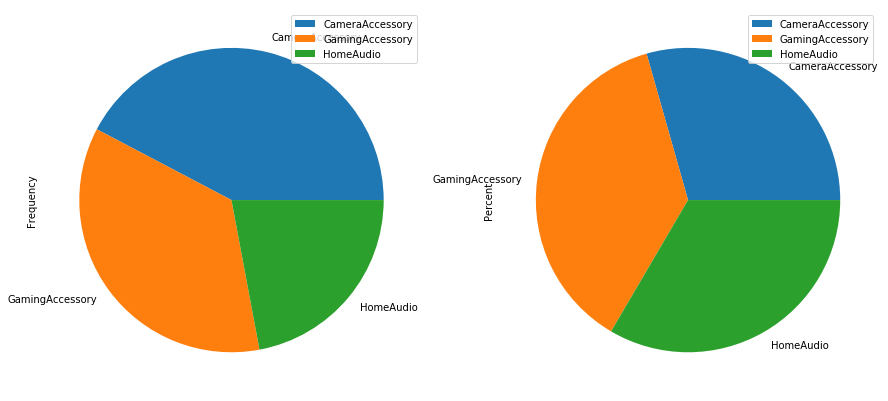

In [25]:
prod_cat_freq.plot.pie(subplots=True, figsize=(15,10))
plt.show()

**Cleaning the Datasets**

In [26]:
consumer_elec.isnull().sum()

fsn_id                             0
order_date                         0
Year                               0
Month                              0
order_id                           0
order_item_id                      0
gmv                                0
units                              0
deliverybdays                      0
deliverycdays                      0
s1_fact.order_payment_type         0
sla                                0
cust_id                            0
pincode                            0
product_analytic_super_category    0
product_analytic_category          0
product_analytic_sub_category      0
product_analytic_vertical          0
product_mrp                        0
product_procurement_sla            0
dtype: int64

In [27]:
consumer_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null object
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1648824 non-null object
units                              1648824 non-null int64
deliverybdays                      1648824 non-null object
deliverycdays                      1648824 non-null object
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1648824 non-null object
pincode                            1648824 non-null object
product_analytic_super_category    1648824 non-null object
prod

In [28]:
consumer_elec.gmv.sample(10)

515243     2349
861262      469
874061      999
130805      539
538715      328
847048      220
13114       284
248166      639
717469     3508
1644791     969
Name: gmv, dtype: object

In [29]:
# convert GMV to float
consumer_elec = consumer_elec.replace(r'^\s+$', np.nan, regex=True)
consumer_elec['gmv']=consumer_elec.gmv.astype(float)

#convert order_date to datetime
consumer_elec['order_date']=pd.to_datetime(consumer_elec['order_date'])

In [30]:
len(consumer_elec.index)

1648824

In [31]:
# Null percentage
(consumer_elec.isnull().sum() / len(consumer_elec.index)) *100

fsn_id                             0.000000
order_date                         0.000000
Year                               0.000000
Month                              0.000000
order_id                           0.000000
order_item_id                      0.000000
gmv                                0.297424
units                              0.000000
deliverybdays                      0.000000
deliverycdays                      0.000000
s1_fact.order_payment_type         0.000000
sla                                0.000000
cust_id                            0.297424
pincode                            0.297424
product_analytic_super_category    0.000000
product_analytic_category          0.000000
product_analytic_sub_category      0.000000
product_analytic_vertical          0.000000
product_mrp                        0.000000
product_procurement_sla            0.000000
dtype: float64

In [32]:
abc = consumer_elec[consumer_elec.isnull().sum(axis = 1) > 1].head()
abc.sample(5)

fsn_id          order_date  Year  Month      order_id  \
95   ACCCX3SGAR6NNBMR 2015-10-05 13:25:48  2015     10  2.408842e+15   
8    ACCCX3S5JGAJETYR 2015-10-16 00:49:14  2015     10  2.417870e+15   
124  ACCCX3SGDGPZAQXD 2015-10-16 01:49:30  2015     10  4.417909e+15   
142  ACCCX3SGDGPZAQXD 2015-10-16 22:59:20  2015     10  4.418717e+15   
186  ACCCX3SGDGPZAQXD 2015-10-16 07:30:25  2015     10  4.418158e+15   

     order_item_id  gmv  units deliverybdays deliverycdays  \
95    2.408842e+15  NaN      1            \N            \N   
8     2.417870e+15  NaN      1            \N            \N   
124   4.417909e+15  NaN      1            \N            \N   
142   4.418717e+15  NaN      1            \N            \N   
186   4.418158e+15  NaN      1            \N            \N   

    s1_fact.order_payment_type  sla cust_id pincode  \
95                     Prepaid    3     NaN     NaN   
8                      Prepaid    9     NaN     NaN   
124                    Prepaid    6     NaN     NaN   
142                    Prepaid    6     NaN     NaN   
186                    Prepaid    6     NaN     NaN   

    product_analytic_super_category product_analytic_category  \
95                               CE           CameraAccessory   
8                                CE           CameraAccessory   
124                              CE           CameraAccessory   
142                              CE           CameraAccessory   
186                              CE           CameraAccessory   

    product_analytic_sub_category product_analytic_vertical  product_mrp  \
95                CameraAccessory                      Lens         7150   
8                 CameraAccessory              CameraTripod         4044   
124               CameraAccessory                      Lens        17995   
142               CameraAccessory                      Lens        17995   
186               CameraAccessory                      Lens        17995   

     product_procurement_sla  
95                         5  
8                          5  
124                        5  
142                        5  
186                        5

In [33]:
#wherever GMV is null, my cust_id and pincode is also null. Therefore, dropping these values
consumer_elec = consumer_elec.dropna()
(consumer_elec.isnull().sum() / len(consumer_elec.index)) *100

fsn_id                             0.0
order_date                         0.0
Year                               0.0
Month                              0.0
order_id                           0.0
order_item_id                      0.0
gmv                                0.0
units                              0.0
deliverybdays                      0.0
deliverycdays                      0.0
s1_fact.order_payment_type         0.0
sla                                0.0
cust_id                            0.0
pincode                            0.0
product_analytic_super_category    0.0
product_analytic_category          0.0
product_analytic_sub_category      0.0
product_analytic_vertical          0.0
product_mrp                        0.0
product_procurement_sla            0.0
dtype: float64

In [34]:
#dropping columns which are not required
lst = ['fsn_id','order_id','order_item_id','deliverybdays','deliverycdays','cust_id','pincode']
consumer_elec.drop(lst , 1 , inplace = True)

In [35]:
consumer_elec = consumer_elec[consumer_elec['product_analytic_vertical'] != '\\N']
consumer_elec.head()

order_date  Year  Month     gmv  units s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                        COD   
1 2015-10-19 10:07:22  2015     10  6900.0      1                        COD   
2 2015-10-20 15:45:56  2015     10  1990.0      1                        COD   
3 2015-10-14 12:05:15  2015     10  1690.0      1                    Prepaid   
4 2015-10-17 21:25:03  2015     10  1618.0      1                    Prepaid   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category product_analytic_vertical  product_mrp  \
0               CameraAccessory              CameraTripod         7190   
1               CameraAccessory              CameraTripod         7190   
2               CameraAccessory              CameraTripod         2099   
3               CameraAccessory              CameraTripod         2099   
4               CameraAccessory              CameraTripod         2099   

   product_procurement_sla  
0                        0  
1                        0  
2                        3  
3                        3  
4                        3

In [36]:
consumer_elec.describe(include='all')

order_date          Year         Month           gmv  \
count               1638106  1.638106e+06  1.638106e+06  1.638106e+06   
unique              1149334           NaN           NaN           NaN   
top     2016-04-27 00:19:27           NaN           NaN           NaN   
freq                    292           NaN           NaN           NaN   
first   2015-05-19 13:42:09           NaN           NaN           NaN   
last    2016-07-25 01:19:45           NaN           NaN           NaN   
mean                    NaN  2.015519e+03  6.582272e+00  2.457488e+03   
std                     NaN  4.996239e-01  3.625010e+00  5.626604e+03   
min                     NaN  2.015000e+03  1.000000e+00  0.000000e+00   
25%                     NaN  2.015000e+03  3.000000e+00  3.390000e+02   
50%                     NaN  2.016000e+03  6.000000e+00  7.490000e+02   
75%                     NaN  2.016000e+03  1.000000e+01  1.999000e+03   
max                     NaN  2.016000e+03  1.200000e+01  2.269470e+05   

               units s1_fact.order_payment_type           sla  \
count   1.638106e+06                    1638106  1.638106e+06   
unique           NaN                          2           NaN   
top              NaN                        COD           NaN   
freq             NaN                    1187696           NaN   
first            NaN                        NaN           NaN   
last             NaN                        NaN           NaN   
mean    1.022115e+00                        NaN  5.695127e+00   
std     2.536523e-01                        NaN  2.983051e+00   
min     1.000000e+00                        NaN  0.000000e+00   
25%     1.000000e+00                        NaN  4.000000e+00   
50%     1.000000e+00                        NaN  6.000000e+00   
75%     1.000000e+00                        NaN  7.000000e+00   
max     5.000000e+01                        NaN  1.006000e+03   

       product_analytic_super_category product_analytic_category  \
count                          1638106                   1638106   
unique                               1                         5   
top                                 CE        EntertainmentSmall   
freq                           1638106                    935803   
first                              NaN                       NaN   
last                               NaN                       NaN   
mean                               NaN                       NaN   
std                                NaN                       NaN   
min                                NaN                       NaN   
25%                                NaN                       NaN   
50%                                NaN                       NaN   
75%                                NaN                       NaN   
max                                NaN                       NaN   

       product_analytic_sub_category product_analytic_vertical   product_mrp  \
count                        1638106                   1638106  1.638106e+06   
unique                            14                        73           NaN   
top                          Speaker             LaptopSpeaker           NaN   
freq                          536308                    286665           NaN   
first                            NaN                       NaN           NaN   
last                             NaN                       NaN           NaN   
mean                             NaN                       NaN  4.090631e+03   
std                              NaN                       NaN  8.518229e+03   
min                              NaN                       NaN  0.000000e+00   
25%                              NaN                       NaN  7.990000e+02   
50%                              NaN                       NaN  1.550000e+03   
75%                              NaN                       NaN  3.490000e+03   
max                              NaN                       NaN  2.999990e+05   

        p

In [37]:
consumer_elec.index = consumer_elec.order_date
consumer_elec.head()

order_date  Year  Month     gmv  units  \
order_date                                                            
2015-10-17 15:11:54 2015-10-17 15:11:54  2015     10  6400.0      1   
2015-10-19 10:07:22 2015-10-19 10:07:22  2015     10  6900.0      1   
2015-10-20 15:45:56 2015-10-20 15:45:56  2015     10  1990.0      1   
2015-10-14 12:05:15 2015-10-14 12:05:15  2015     10  1690.0      1   
2015-10-17 21:25:03 2015-10-17 21:25:03  2015     10  1618.0      1   

                    s1_fact.order_payment_type  sla  \
order_date                                            
2015-10-17 15:11:54                        COD    5   
2015-10-19 10:07:22                        COD    7   
2015-10-20 15:45:56                        COD   10   
2015-10-14 12:05:15                    Prepaid    4   
2015-10-17 21:25:03                    Prepaid    6   

                    product_analytic_super_category product_analytic_category  \
order_date                                                                      
2015-10-17 15:11:54                              CE           CameraAccessory   
2015-10-19 10:07:22                              CE           CameraAccessory   
2015-10-20 15:45:56                              CE           CameraAccessory   
2015-10-14 12:05:15                              CE           CameraAccessory   
2015-10-17 21:25:03                              CE           CameraAccessory   

                    product_analytic_sub_category product_analytic_vertical  \
order_date                                                                    
2015-10-17 15:11:54               CameraAccessory              CameraTripod   
2015-10-19 10:07:22               CameraAccessory              CameraTripod   
2015-10-20 15:45:56               CameraAccessory              CameraTripod   
2015-10-14 12:05:15               CameraAccessory              CameraTripod   
2015-10-17 21:25:03               CameraAccessory              CameraTripod   

                     product_mrp  product_procurement_sla  
order_date                                                 
2015-10-17 15:11:54         7190                        0  
2015-10-19 10:07:22         7190                        0  
2015-10-20 15:45:56         2099                        3  
2015-10-14 12:05:15         2099                        3  
2015-10-17 21:25:03         2099                        3

COD        1187696
Prepaid     450410
Name: s1_fact.order_payment_type, dtype: int64


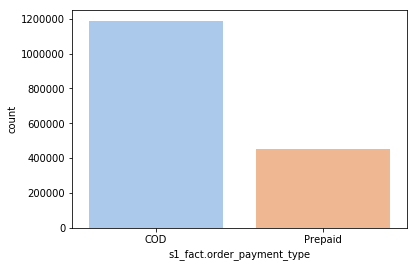

In [38]:
#count of orders based on payment type
print(pd.value_counts(consumer_elec['s1_fact.order_payment_type']))
sns.countplot(x='s1_fact.order_payment_type',data=consumer_elec, palette='pastel')

LaptopSpeaker              286665
MobileSpeaker              249643
AudioMP3Player             112545
PhysicalGame               104799
HomeAudioSpeaker            85306
GamingHeadset               62180
GamePad                     58944
DSLR                        56514
Flash                       48717
SelectorBox                 46122
CameraBattery               41187
RemoteControl               39583
Point & Shoot               38618
CameraTripod                37770
GamingMouse                 37356
VideoGlasses                36644
Lens                        35367
FMRadio                     28147
VideoPlayer                 20222
HandheldGamingConsole       19344
CameraStorageMemoryCard     17943
CameraBag                   17465
CameraBatteryCharger        15614
Binoculars                  14554
Filter                      12684
GamingConsole                9667
GamingAccessoryKit           9474
CodeInTheBoxGame             9331
Microphone                   9049
TVOutCableAcce

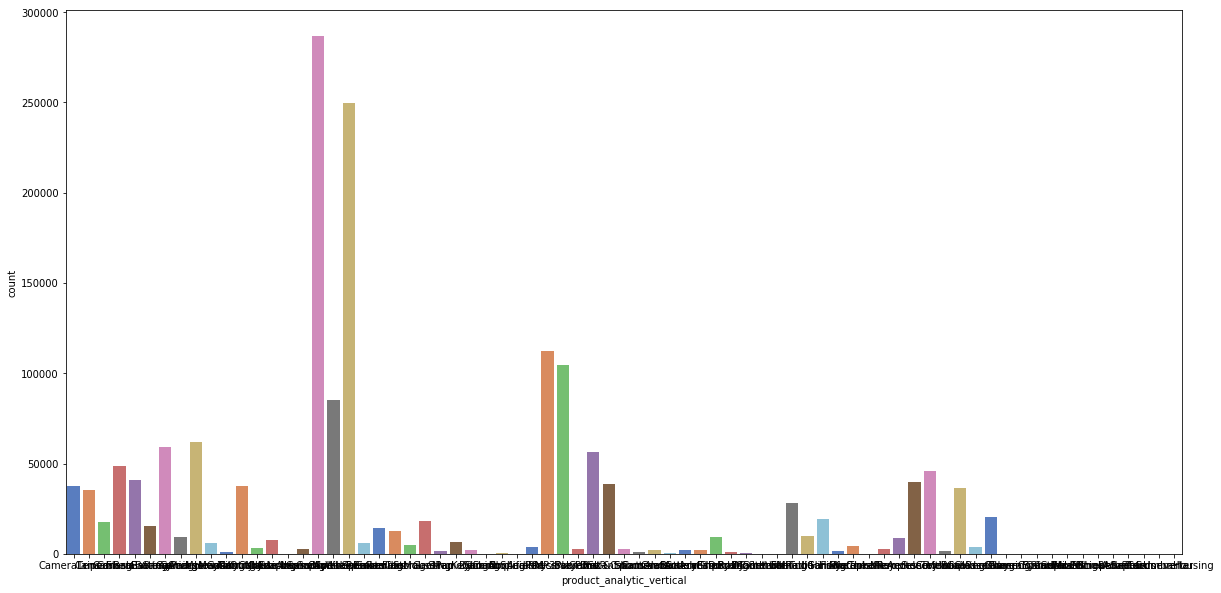

In [39]:
#order count based on the product vertical
print(pd.value_counts(consumer_elec['product_analytic_vertical']))
plt.figure(figsize=(20,10))
sns.countplot(x='product_analytic_vertical',data=consumer_elec, palette='muted')

Speaker                536308
CameraAccessory        238862
GamingAccessory        201318
TVVideoSmall           142571
HomeAudio              124415
Game                   114130
AudioMP3Player         112545
Camera                 100942
GamingConsole           29011
CameraStorage           17943
AudioAccessory          11676
HomeTheatre              4245
AmplifierReceiver        4043
GameMembershipCards        97
Name: product_analytic_sub_category, dtype: int64


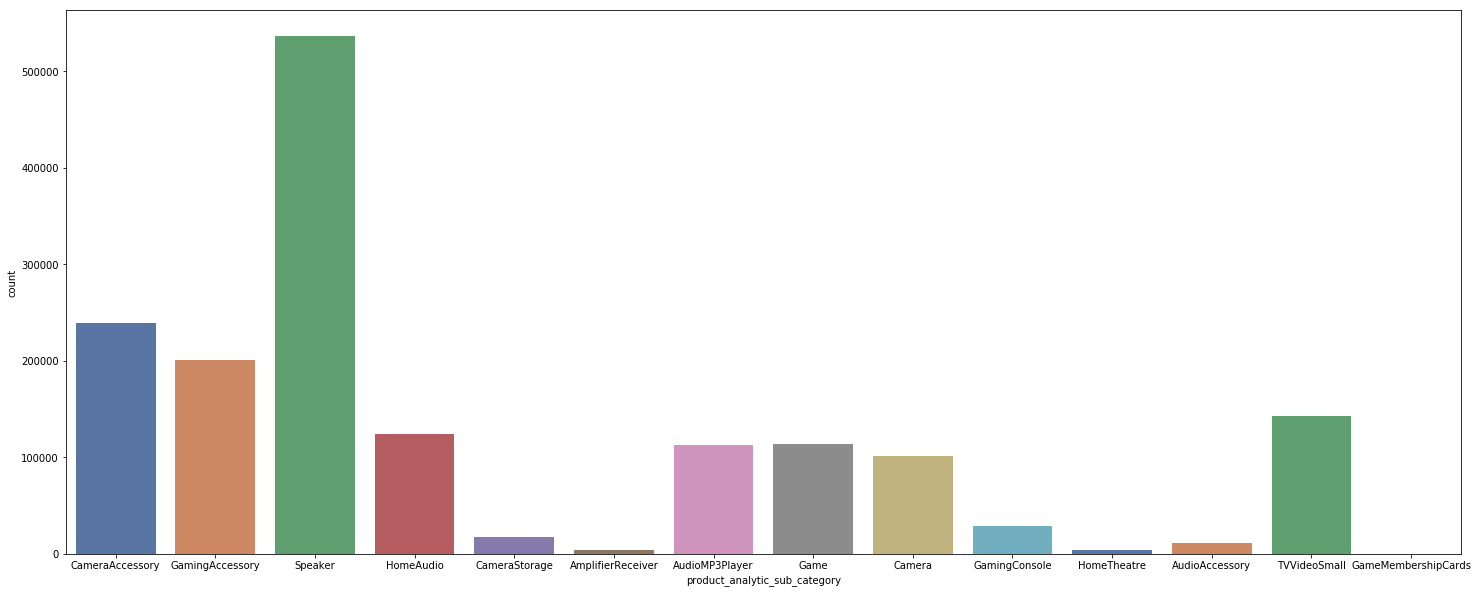

In [40]:
#order count based on product sub-category
print(pd.value_counts(consumer_elec.product_analytic_sub_category))
plt.figure(figsize=(25,10))
sns.countplot(x='product_analytic_sub_category',data=consumer_elec, palette='deep')

9     207418
10    204588
12    157884
5     156497
3     151602
2     143482
1     143330
4     133833
11    129301
6     121484
7      88418
8        269
Name: Month, dtype: int64


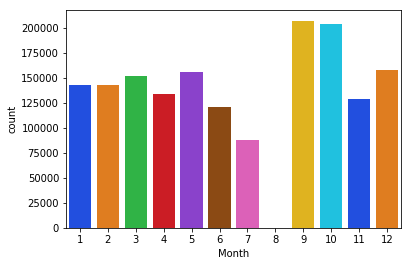

In [41]:
# order count for each month
print(pd.value_counts(consumer_elec.Month))
sns.countplot(x='Month',data=consumer_elec,palette='bright')

2016    850822
2015    787284
Name: Year, dtype: int64


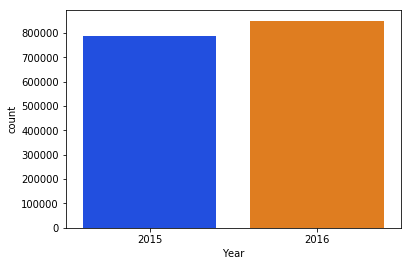

In [42]:
#order count for each year
print(pd.value_counts(consumer_elec.Year))
sns.countplot(x='Year',data=consumer_elec,palette='bright')

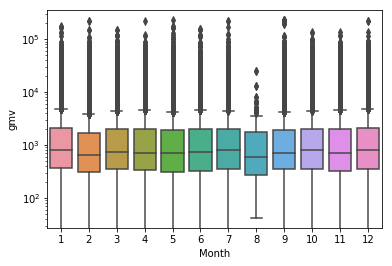

In [43]:
sns.boxplot(x='Month', y='gmv', data=consumer_elec)
plt.yscale('log')
plt.show()

**Creating KPIs**

In [44]:
# KPI 1: week
# extracting week number from the order date
consumer_elec['week'] = consumer_elec.order_date.dt.week
consumer_elec.head()

order_date  Year  Month     gmv  units  \
order_date                                                            
2015-10-17 15:11:54 2015-10-17 15:11:54  2015     10  6400.0      1   
2015-10-19 10:07:22 2015-10-19 10:07:22  2015     10  6900.0      1   
2015-10-20 15:45:56 2015-10-20 15:45:56  2015     10  1990.0      1   
2015-10-14 12:05:15 2015-10-14 12:05:15  2015     10  1690.0      1   
2015-10-17 21:25:03 2015-10-17 21:25:03  2015     10  1618.0      1   

                    s1_fact.order_payment_type  sla  \
order_date                                            
2015-10-17 15:11:54                        COD    5   
2015-10-19 10:07:22                        COD    7   
2015-10-20 15:45:56                        COD   10   
2015-10-14 12:05:15                    Prepaid    4   
2015-10-17 21:25:03                    Prepaid    6   

                    product_analytic_super_category product_analytic_category  \
order_date                                                                      
2015-10-17 15:11:54                              CE           CameraAccessory   
2015-10-19 10:07:22                              CE           CameraAccessory   
2015-10-20 15:45:56                              CE           CameraAccessory   
2015-10-14 12:05:15                              CE           CameraAccessory   
2015-10-17 21:25:03                              CE           CameraAccessory   

                    product_analytic_sub_category product_analytic_vertical  \
order_date                                                                    
2015-10-17 15:11:54               CameraAccessory              CameraTripod   
2015-10-19 10:07:22               CameraAccessory              CameraTripod   
2015-10-20 15:45:56               CameraAccessory              CameraTripod   
2015-10-14 12:05:15               CameraAccessory              CameraTripod   
2015-10-17 21:25:03               CameraAccessory              CameraTripod   

                     product_mrp  product_procurement_sla  week  
order_date                                                       
2015-10-17 15:11:54         7190                        0    42  
2015-10-19 10:07:22         7190                        0    43  
2015-10-20 15:45:56         2099                        3    43  
2015-10-14 12:05:15         2099                        3    42  
2015-10-17 21:25:03         2099                        3    42

In [45]:
# Filtering the data for the period 07/2015 to 06/2016
consumer_filtrd = consumer_elec[((consumer_elec.Year==2016)&(consumer_elec.week<=26))|((consumer_elec.Year==2015)&(consumer_elec.week>=27))]
consumer_filtrd.head()

order_date  Year  Month     gmv  units  \
order_date                                                            
2015-10-17 15:11:54 2015-10-17 15:11:54  2015     10  6400.0      1   
2015-10-19 10:07:22 2015-10-19 10:07:22  2015     10  6900.0      1   
2015-10-20 15:45:56 2015-10-20 15:45:56  2015     10  1990.0      1   
2015-10-14 12:05:15 2015-10-14 12:05:15  2015     10  1690.0      1   
2015-10-17 21:25:03 2015-10-17 21:25:03  2015     10  1618.0      1   

                    s1_fact.order_payment_type  sla  \
order_date                                            
2015-10-17 15:11:54                        COD    5   
2015-10-19 10:07:22                        COD    7   
2015-10-20 15:45:56                        COD   10   
2015-10-14 12:05:15                    Prepaid    4   
2015-10-17 21:25:03                    Prepaid    6   

                    product_analytic_super_category product_analytic_category  \
order_date                                                                      
2015-10-17 15:11:54                              CE           CameraAccessory   
2015-10-19 10:07:22                              CE           CameraAccessory   
2015-10-20 15:45:56                              CE           CameraAccessory   
2015-10-14 12:05:15                              CE           CameraAccessory   
2015-10-17 21:25:03                              CE           CameraAccessory   

                    product_analytic_sub_category product_analytic_vertical  \
order_date                                                                    
2015-10-17 15:11:54               CameraAccessory              CameraTripod   
2015-10-19 10:07:22               CameraAccessory              CameraTripod   
2015-10-20 15:45:56               CameraAccessory              CameraTripod   
2015-10-14 12:05:15               CameraAccessory              CameraTripod   
2015-10-17 21:25:03               CameraAccessory              CameraTripod   

                     product_mrp  product_procurement_sla  week  
order_date                                                       
2015-10-17 15:11:54         7190                        0    42  
2015-10-19 10:07:22         7190                        0    43  
2015-10-20 15:45:56         2099                        3    43  
2015-10-14 12:05:15         2099                        3    42  
2015-10-17 21:25:03         2099                        3    42

In [46]:
print("Unique Weeks: ",np.sort(consumer_filtrd.week.unique()))
print("Unique Years: ",np.sort(consumer_filtrd.Year.unique()))
print("Unique Months: ",np.sort(consumer_filtrd.Month.unique()))

Unique Weeks:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53]
Unique Years:  [2015 2016]
Unique Months:  [ 1  2  3  4  5  6  7  8  9 10 11 12]


42    119064
17     53646
39     49943
52     47396
37     47377
10     45377
36     45172
21     44140
38     42966
3      40374
7      39401
45     38038
50     37508
8      35582
40     34945
44     34540
19     33993
9      33703
20     33339
1      33317
5      33005
18     31743
49     31692
22     31678
46     31396
11     31236
23     31159
6      30685
14     30625
13     30249
12     29434
24     28956
4      28654
51     27875
2      27455
15     25246
47     25000
25     24971
30     24409
48     24335
43     24088
28     23697
29     23626
41     20687
53     17353
31     15794
16     15013
26     13984
27       297
32        30
35        23
33        13
34        13
Name: week, dtype: int64


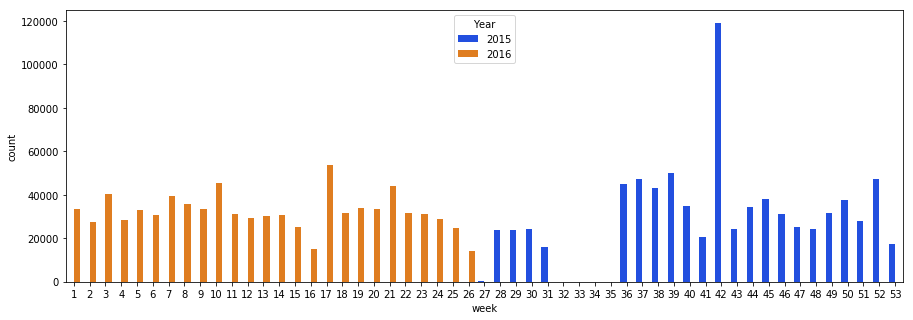

In [47]:
#order count week wise
print(pd.value_counts(consumer_filtrd.week))
plt.figure(figsize=(15,5))
sns.countplot(x='week',data=consumer_filtrd,palette='bright', hue='Year')

In [48]:
# removing products with product mrp 0
consumer_filtrd=consumer_filtrd[consumer_filtrd.product_mrp>0]
consumer_filtrd.head()

order_date  Year  Month     gmv  units  \
order_date                                                            
2015-10-17 15:11:54 2015-10-17 15:11:54  2015     10  6400.0      1   
2015-10-19 10:07:22 2015-10-19 10:07:22  2015     10  6900.0      1   
2015-10-20 15:45:56 2015-10-20 15:45:56  2015     10  1990.0      1   
2015-10-14 12:05:15 2015-10-14 12:05:15  2015     10  1690.0      1   
2015-10-17 21:25:03 2015-10-17 21:25:03  2015     10  1618.0      1   

                    s1_fact.order_payment_type  sla  \
order_date                                            
2015-10-17 15:11:54                        COD    5   
2015-10-19 10:07:22                        COD    7   
2015-10-20 15:45:56                        COD   10   
2015-10-14 12:05:15                    Prepaid    4   
2015-10-17 21:25:03                    Prepaid    6   

                    product_analytic_super_category product_analytic_category  \
order_date                                                                      
2015-10-17 15:11:54                              CE           CameraAccessory   
2015-10-19 10:07:22                              CE           CameraAccessory   
2015-10-20 15:45:56                              CE           CameraAccessory   
2015-10-14 12:05:15                              CE           CameraAccessory   
2015-10-17 21:25:03                              CE           CameraAccessory   

                    product_analytic_sub_category product_analytic_vertical  \
order_date                                                                    
2015-10-17 15:11:54               CameraAccessory              CameraTripod   
2015-10-19 10:07:22               CameraAccessory              CameraTripod   
2015-10-20 15:45:56               CameraAccessory              CameraTripod   
2015-10-14 12:05:15               CameraAccessory              CameraTripod   
2015-10-17 21:25:03               CameraAccessory              CameraTripod   

                     product_mrp  product_procurement_sla  week  
order_date                                                       
2015-10-17 15:11:54         7190                        0    42  
2015-10-19 10:07:22         7190                        0    43  
2015-10-20 15:45:56         2099                        3    43  
2015-10-14 12:05:15         2099                        3    42  
2015-10-17 21:25:03         2099                        3    42

In [49]:
# KPI 2: list_price
# Creating list_price
consumer_filtrd['list_price']=round((consumer_filtrd.gmv/consumer_filtrd.units),2)
consumer_filtrd = consumer_filtrd[consumer_filtrd['list_price'] > 0]
consumer_filtrd.head()

order_date  Year  Month     gmv  units  \
order_date                                                            
2015-10-17 15:11:54 2015-10-17 15:11:54  2015     10  6400.0      1   
2015-10-19 10:07:22 2015-10-19 10:07:22  2015     10  6900.0      1   
2015-10-20 15:45:56 2015-10-20 15:45:56  2015     10  1990.0      1   
2015-10-14 12:05:15 2015-10-14 12:05:15  2015     10  1690.0      1   
2015-10-17 21:25:03 2015-10-17 21:25:03  2015     10  1618.0      1   

                    s1_fact.order_payment_type  sla  \
order_date                                            
2015-10-17 15:11:54                        COD    5   
2015-10-19 10:07:22                        COD    7   
2015-10-20 15:45:56                        COD   10   
2015-10-14 12:05:15                    Prepaid    4   
2015-10-17 21:25:03                    Prepaid    6   

                    product_analytic_super_category product_analytic_category  \
order_date                                                                      
2015-10-17 15:11:54                              CE           CameraAccessory   
2015-10-19 10:07:22                              CE           CameraAccessory   
2015-10-20 15:45:56                              CE           CameraAccessory   
2015-10-14 12:05:15                              CE           CameraAccessory   
2015-10-17 21:25:03                              CE           CameraAccessory   

                    product_analytic_sub_category product_analytic_vertical  \
order_date                                                                    
2015-10-17 15:11:54               CameraAccessory              CameraTripod   
2015-10-19 10:07:22               CameraAccessory              CameraTripod   
2015-10-20 15:45:56               CameraAccessory              CameraTripod   
2015-10-14 12:05:15               CameraAccessory              CameraTripod   
2015-10-17 21:25:03               CameraAccessory              CameraTripod   

                     product_mrp  product_procurement_sla  week  list_price  
order_date                                                                   
2015-10-17 15:11:54         7190                        0    42      6400.0  
2015-10-19 10:07:22         7190                        0    43      6900.0  
2015-10-20 15:45:56         2099                        3    43      1990.0  
2015-10-14 12:05:15         2099                        3    42      1690.0  
2015-10-17 21:25:03         2099                        3    42      1618.0

In [50]:
#converting weeks in sequential order
consumer_filtrd['week'] = np.where((consumer_filtrd.Year == 2015), consumer_filtrd.week-26,consumer_filtrd.week)
consumer_filtrd['week'] = np.where((consumer_filtrd.Year == 2016), consumer_filtrd.week+27,consumer_filtrd.week)
np.sort(consumer_filtrd.week.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53], dtype=int64)

In [51]:
#merging the consumer electronics data and media investment
consumer_media_df = consumer_filtrd.merge(media_nps_df)
consumer_media_df.head()

order_date  Year  Month     gmv  units s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                        COD   
1 2015-10-19 10:07:22  2015     10  6900.0      1                        COD   
2 2015-10-20 15:45:56  2015     10  1990.0      1                        COD   
3 2015-10-14 12:05:15  2015     10  1690.0      1                    Prepaid   
4 2015-10-17 21:25:03  2015     10  1618.0      1                    Prepaid   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ...   Digital  Sponsorship  \
0               CameraAccessory  ...  12.62248    84.672532   
1               CameraAccessory  ...  12.62248    84.672532   
2               CameraAccessory  ...  12.62248    84.672532   
3               CameraAccessory  ...  12.62248    84.672532   
4               CameraAccessory  ...  12.62248    84.672532   

   Content Marketing  Online marketing   Affiliates        SEM  Radio  Other  \
0           3.444075         24.371778     6.973711  31.927011    0.0    0.0   
1           3.444075         24.371778     6.973711  31.927011    0.0    0.0   
2           3.444075         24.371778     6.973711  31.927011    0.0    0.0   
3           3.444075         24.371778     6.973711  31.927011    0.0    0.0   
4           3.444075         24.371778     6.973711  31.927011    0.0    0.0   

       NPS  Stock Index  
0  44.3984         1210  
1  44.3984         1210  
2  44.3984         1210  
3  44.3984         1210  
4  44.3984         1210  

[5 rows x 27 columns]

In [52]:
# checking for null values in the new dataset
consumer_media_df.isnull().sum()

order_date                         0
Year                               0
Month                              0
gmv                                0
units                              0
s1_fact.order_payment_type         0
sla                                0
product_analytic_super_category    0
product_analytic_category          0
product_analytic_sub_category      0
product_analytic_vertical          0
product_mrp                        0
product_procurement_sla            0
week                               0
list_price                         0
Unnamed: 0                         0
TV                                 0
Digital                            0
Sponsorship                        0
Content Marketing                  0
Online marketing                   0
 Affiliates                        0
SEM                                0
Radio                              0
Other                              0
NPS                                0
Stock Index                        0
d

In [53]:
consumer_media_df.sample(5)

order_date  Year  Month      gmv  units  \
1476314 2016-06-01 06:49:21  2016      6    199.0      1   
1554153 2015-07-19 21:09:52  2015      7   1889.0      1   
916147  2016-02-20 09:41:09  2016      2    500.0      1   
256644  2015-11-27 14:44:08  2015     11   4499.0      1   
1266293 2016-05-13 15:50:01  2016      5  19850.0      1   

        s1_fact.order_payment_type  sla product_analytic_super_category  \
1476314                        COD    6                              CE   
1554153                    Prepaid    4                              CE   
916147                         COD    6                              CE   
256644                         COD    7                              CE   
1266293                        COD    8                              CE   

        product_analytic_category product_analytic_sub_category  ...  \
1476314            GamingHardware               GamingAccessory  ...   
1554153        EntertainmentSmall                       Speaker  ...   
916147             GamingHardware               GamingAccessory  ...   
256644         EntertainmentSmall                       Speaker  ...   
1266293           CameraAccessory               CameraAccessory  ...   

          Digital  Sponsorship  Content Marketing  Online marketing  \
1476314  1.420761    25.048541           0.045081          7.971300   
1554153  2.533014     7.414270           0.000933          1.327278   
916147   1.912651    11.725555           0.596771         19.892366   
256644   1.275469    14.172116           0.168633         19.561574   
1266293  0.770000    31.680000           0.790000         23.650000   

          Affiliates       SEM  Radio  Other      NPS  Stock Index  
1476314     2.768023  3.735516    0.0  0.000  50.5167         1194  
1554153     0.547254  5.023697    0.0  0.000  54.5996         1177  
916147      6.465019  4.873630    0.0  0.000  50.3274         1222  
256644      6.595767  5.222032    0.0  0.000       47         1233  
1266293     6.800000  6.910000    1.1  4.987   47.307         1228  

[5 rows x 27 columns]

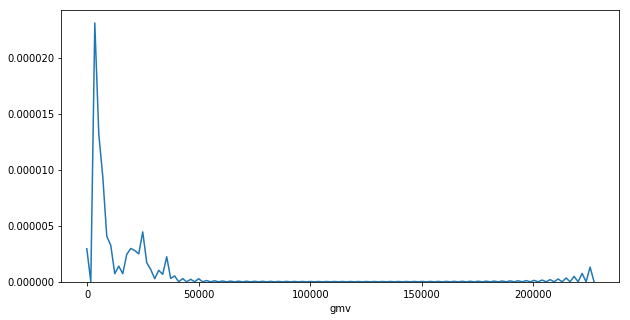

In [54]:
# Distplot for gmv values
plt.figure(figsize=(10,5))
sns.distplot(consumer_media_df['gmv'],bins=25,hist=False)

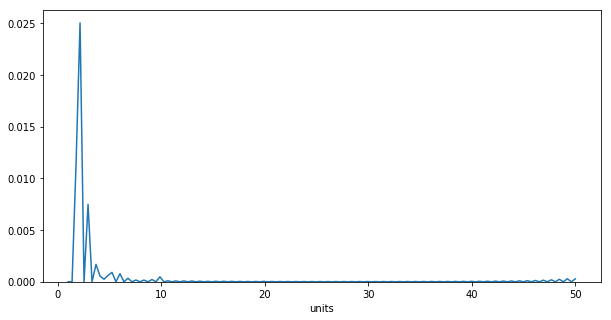

In [55]:
# Distplot for units
plt.figure(figsize=(10,5))
sns.distplot(consumer_media_df['units'],bins=10,hist=False)

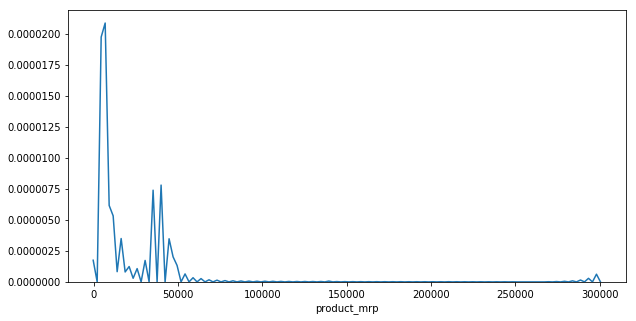

In [56]:
# Distplot for product mrp
plt.figure(figsize=(10,5))
sns.distplot(consumer_media_df['product_mrp'],hist=False)

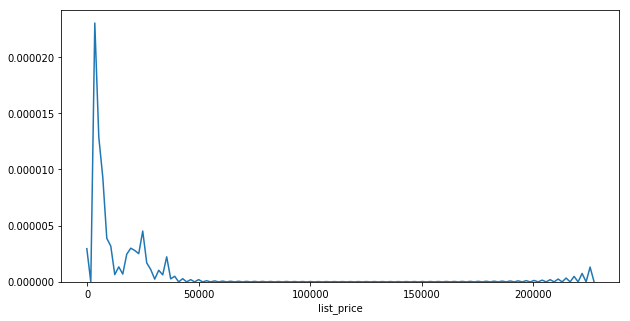

In [57]:
# Distplot for product mrp
plt.figure(figsize=(10,5))
sns.distplot(consumer_media_df['list_price'],hist=False)

*gmv = (product mrp * no. of units)*<br><br>
*Removing bulk transactions because in bulk sales, the product is sold at less than mrp*

In [58]:
consumer_media_df=consumer_media_df[(consumer_media_df.product_mrp * consumer_media_df.units)>=consumer_media_df.gmv]
consumer_media_df.shape

(1584473, 27)

In [59]:
consumer_media_df=consumer_media_df[(consumer_media_df.list_price )> 0]
consumer_media_df.shape

(1584473, 27)

In [60]:
consumer_media_df.index = range(len(consumer_media_df.index))

In [61]:
consumer_media_df.sample(5)

order_date  Year  Month     gmv  units  \
372061 2016-04-14 13:14:08  2016      4   249.0      1   
874829 2016-02-12 09:35:57  2016      2  1249.0      1   
817769 2016-02-14 12:58:10  2016      2  5550.0      1   
497568 2016-03-09 16:20:24  2016      3  1530.0      1   
503879 2016-03-04 12:42:38  2016      3   398.0      1   

       s1_fact.order_payment_type  sla product_analytic_super_category  \
372061                    Prepaid    3                              CE   
874829                        COD    8                              CE   
817769                        COD    7                              CE   
497568                    Prepaid    6                              CE   
503879                        COD    8                              CE   

       product_analytic_category product_analytic_sub_category  ...   Digital  \
372061           CameraAccessory               CameraAccessory  ...  0.871892   
874829            GamingHardware               GamingAccessory  ...  1.912651   
817769        EntertainmentSmall                       Speaker  ...  1.912651   
497568        EntertainmentSmall                     HomeAudio  ...  2.100000   
503879        EntertainmentSmall                       Speaker  ...  2.100000   

        Sponsorship  Content Marketing  Online marketing   Affiliates  \
372061    24.308354           0.034876         16.514510     5.693456   
874829    11.725555           0.596771         19.892366     6.465019   
817769    11.725555           0.596771         19.892366     6.465019   
497568    41.590000           0.370000         18.437818     6.217667   
503879    41.590000           0.370000         18.437818     6.217667   

             SEM  Radio      Other      NPS  Stock Index  
372061  4.219958   0.00   0.000000  51.8276         1242  
874829  4.873630   0.00   0.000000  50.3274         1222  
817769  4.873630   0.00   0.000000  50.3274         1222  
497568  5.193591   0.87  15.945545  49.0206         1015  
503879  5.193591   0.87  15.945545  49.0206         1015  

[5 rows x 27 columns]

In [62]:
consumer_media_df['date'] = consumer_media_df.order_date.dt.date
consumer_media_df.head()

order_date  Year  Month     gmv  units s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                        COD   
1 2015-10-19 10:07:22  2015     10  6900.0      1                        COD   
2 2015-10-20 15:45:56  2015     10  1990.0      1                        COD   
3 2015-10-14 12:05:15  2015     10  1690.0      1                    Prepaid   
4 2015-10-17 21:25:03  2015     10  1618.0      1                    Prepaid   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ... Sponsorship  Content Marketing  \
0               CameraAccessory  ...   84.672532           3.444075   
1               CameraAccessory  ...   84.672532           3.444075   
2               CameraAccessory  ...   84.672532           3.444075   
3               CameraAccessory  ...   84.672532           3.444075   
4               CameraAccessory  ...   84.672532           3.444075   

   Online marketing   Affiliates        SEM  Radio  Other      NPS  \
0         24.371778     6.973711  31.927011    0.0    0.0  44.3984   
1         24.371778     6.973711  31.927011    0.0    0.0  44.3984   
2         24.371778     6.973711  31.927011    0.0    0.0  44.3984   
3         24.371778     6.973711  31.927011    0.0    0.0  44.3984   
4         24.371778     6.973711  31.927011    0.0    0.0  44.3984   

   Stock Index        date  
0         1210  2015-10-17  
1         1210  2015-10-19  
2         1210  2015-10-20  
3         1210  2015-10-14  
4         1210  2015-10-17  

[5 rows x 28 columns]

In [63]:
consumer_media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584473 entries, 0 to 1584472
Data columns (total 28 columns):
order_date                         1584473 non-null datetime64[ns]
Year                               1584473 non-null int64
Month                              1584473 non-null int64
gmv                                1584473 non-null float64
units                              1584473 non-null int64
s1_fact.order_payment_type         1584473 non-null object
sla                                1584473 non-null int64
product_analytic_super_category    1584473 non-null object
product_analytic_category          1584473 non-null object
product_analytic_sub_category      1584473 non-null object
product_analytic_vertical          1584473 non-null object
product_mrp                        1584473 non-null int64
product_procurement_sla            1584473 non-null int64
week                               1584473 non-null int64
list_price                         1584473 non-null float64

#### **Working with Holiday data set**

In [64]:
#Holidays in Canada in 2015
canada_2015_holidays = holidays.Canada(years=2015, state='ON')
canada_2015_holidays

{datetime.date(2015, 1, 1): "New Year's Day",
 datetime.date(2015, 2, 16): 'Family Day',
 datetime.date(2015, 4, 3): 'Good Friday',
 datetime.date(2015, 5, 18): 'Victoria Day',
 datetime.date(2015, 7, 1): 'Canada Day',
 datetime.date(2015, 8, 3): 'Civic Holiday',
 datetime.date(2015, 9, 7): 'Labour Day',
 datetime.date(2015, 10, 12): 'Thanksgiving',
 datetime.date(2015, 12, 25): 'Christmas Day',
 datetime.date(2015, 12, 28): 'Boxing Day (Observed)'}

In [65]:
canada_2016_holidays = holidays.Canada(years=2016, state='ON')
canada_2016_holidays

{datetime.date(2016, 1, 1): "New Year's Day",
 datetime.date(2016, 2, 15): 'Family Day',
 datetime.date(2016, 3, 25): 'Good Friday',
 datetime.date(2016, 5, 23): 'Victoria Day',
 datetime.date(2016, 7, 1): 'Canada Day',
 datetime.date(2016, 8, 1): 'Civic Holiday',
 datetime.date(2016, 9, 5): 'Labour Day',
 datetime.date(2016, 10, 10): 'Thanksgiving',
 datetime.date(2016, 12, 25): 'Christmas Day',
 datetime.date(2016, 12, 26): 'Christmas Day (Observed)',
 datetime.date(2016, 12, 27): 'Boxing Day (Observed)'}

In [66]:
holiday_lst = ['2015-07-01','2015-08-03','2015-09-07','2015-10-12','2015-12-25','2015-12-28','2016-01-01','2016-02-15','2016-03-25','2016-05-23']

#Based on Media and Investment Dataset
payday_lst= ['2015-07-01','2015-07-15','2015-08-01','2015-08-15','2015-09-01','2015-09-15','2015-10-01','2015-10-15','2015-11-01','2015-11-15','2015-12-01','2015-12-15','2016-01-01','2016-01-15','2016-02-01','2016-02-15','2016-03-01','2016-03-15','2016-04-01','2016-04-15','2016-05-01','2016-05-15','2016-06-01','2016-06-15','2016-07-01','2016-07-15']
special_sales_lst = ['2015-07-18','2015-07-19','2015-08-15','2015-08-16','2015-08-17','2015-08-28','2015-08-29','2015-08-30','2015-10-15','2015-10-16','2015-10-17','2015-11-07','2015-11-08','2015-11-09','2015-11-10','2015-11-11','2015-11-12','2015-11-13','2015-11-14','2015-12-25','2015-12-26','2015-12-27','2015-12-28','2015-12-29','2015-12-30','2015-12-31','2016-01-01','2016-01-02','2016-01-03','2016-01-20','2016-01-21','2016-01-22','2016-02-01','2016-02-02','2016-02-20','2016-02-21','2016-03-14','2016-03-15','2016-05-07','2016-05-08','2016-05-09','2016-05-25','2016-05-26','2016-05-27']

In [67]:
# KPI 4, 5, 6: Holiday flag, payday flag, special sale flag
# Creating holiday flag, payday flag & special sale flag
consumer_media_df['holiday'] = consumer_media_df.date.astype('datetime64').isin(holiday_lst)
consumer_media_df['payday'] = consumer_media_df.date.astype('datetime64').isin(payday_lst)
consumer_media_df['sale_day'] = consumer_media_df.date.astype('datetime64').isin(special_sales_lst)

# Converting boolean to binary
consumer_media_df['holiday'] = consumer_media_df['holiday'] * 1
consumer_media_df['payday'] = consumer_media_df['payday'] * 1
consumer_media_df['sale_day'] = consumer_media_df['sale_day'] * 1

consumer_media_df.head()

order_date  Year  Month     gmv  units s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                        COD   
1 2015-10-19 10:07:22  2015     10  6900.0      1                        COD   
2 2015-10-20 15:45:56  2015     10  1990.0      1                        COD   
3 2015-10-14 12:05:15  2015     10  1690.0      1                    Prepaid   
4 2015-10-17 21:25:03  2015     10  1618.0      1                    Prepaid   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ...  Affiliates        SEM  Radio  Other  \
0               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
1               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
2               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
3               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
4               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   

       NPS  Stock Index        date  holiday  payday  sale_day  
0  44.3984         1210  2015-10-17        0       0         1  
1  44.3984         1210  2015-10-19        0       0         0  
2  44.3984         1210  2015-10-20        0       0         0  
3  44.3984         1210  2015-10-14        0       0         0  
4  44.3984         1210  2015-10-17        0       0         1  

[5 rows x 31 columns]

In [68]:
consumer_media_df[consumer_media_df['sale_day']==1].sample(5)

order_date  Year  Month     gmv  units  \
1238388 2016-05-07 18:47:40  2016      5   716.0      1   
13274   2015-10-16 08:26:05  2015     10   379.0      1   
1074402 2015-12-27 15:02:31  2015     12  2650.0      1   
997521  2016-01-21 17:32:18  2016      1   249.0      1   
520935  2016-03-15 12:43:36  2016      3  1299.0      1   

        s1_fact.order_payment_type  sla product_analytic_super_category  \
1238388                        COD    5                              CE   
13274                          COD    9                              CE   
1074402                        COD    7                              CE   
997521                         COD    5                              CE   
520935                         COD    4                              CE   

        product_analytic_category product_analytic_sub_category  ...  \
1238388           CameraAccessory               CameraAccessory  ...   
13274          EntertainmentSmall                       Speaker  ...   
1074402            GamingHardware               GamingAccessory  ...   
997521            CameraAccessory               CameraAccessory  ...   
520935         EntertainmentSmall                       Speaker  ...   

         Affiliates        SEM  Radio      Other      NPS  Stock Index  \
1238388    6.800000   6.910000   1.10   4.987000   47.307         1228   
13274      6.973711  31.927011   0.00   0.000000  44.3984         1210   
1074402    6.826938  11.181030   0.00   0.000000     45.8         1038   
997521     7.370000   4.200000   2.70  27.090000   47.093         1052   
520935     6.217667   5.193591   0.87  15.945545  49.0206         1015   

               date  holiday  payday  sale_day  
1238388  2016-05-07        0       0         1  
13274    2015-10-16        0       0         1  
1074402  2015-12-27        0       0         1  
997521   2016-01-21        0       0         1  
520935   2016-03-15        0       1         1  

[5 rows x 31 columns]

In [69]:
consumer_media_df[consumer_media_df['payday']==1].sample(5)

order_date  Year  Month     gmv  units  \
193224  2015-10-15 01:06:21  2015     10   999.0      1   
1089399 2015-12-15 11:03:35  2015     12  6399.0      1   
1118445 2015-12-01 21:45:45  2015     12   169.0      1   
525705  2016-03-15 16:45:03  2016      3   265.0      1   
1120736 2015-12-01 21:38:49  2015     12   169.0      1   

        s1_fact.order_payment_type  sla product_analytic_super_category  \
193224                     Prepaid    2                              CE   
1089399                        COD   12                              CE   
1118445                        COD    2                              CE   
525705                         COD    9                              CE   
1120736                        COD    4                              CE   

        product_analytic_category product_analytic_sub_category  ...  \
193224         EntertainmentSmall                  TVVideoSmall  ...   
1089399        EntertainmentSmall                       Speaker  ...   
1118445        EntertainmentSmall                       Speaker  ...   
525705         EntertainmentSmall                       Speaker  ...   
1120736        EntertainmentSmall                       Speaker  ...   

         Affiliates        SEM  Radio      Other      NPS  Stock Index  \
193224     6.973711  31.927011   0.00   0.000000  44.3984         1210   
1089399    6.826938  11.181030   0.00   0.000000     45.8         1038   
1118445    6.826938  11.181030   0.00   0.000000     45.8         1038   
525705     6.217667   5.193591   0.87  15.945545  49.0206         1015   
1120736    6.826938  11.181030   0.00   0.000000     45.8         1038   

               date  holiday  payday  sale_day  
193224   2015-10-15        0       1         1  
1089399  2015-12-15        0       1         0  
1118445  2015-12-01        0       1         0  
525705   2016-03-15        0       1         1  
1120736  2015-12-01        0       1         0  

[5 rows x 31 columns]

In [70]:
consumer_media_df[consumer_media_df['holiday']==1].sample(5)

order_date  Year  Month     gmv  units  \
1145290 2015-12-28 11:12:27  2015     12  2999.0      1   
171246  2015-10-12 11:02:44  2015     10   649.0      1   
1262137 2016-05-23 16:48:46  2016      5   170.0      1   
809106  2016-02-15 23:36:56  2016      2   794.0      1   
1207008 2015-12-28 22:04:36  2015     12  1599.0      1   

        s1_fact.order_payment_type  sla product_analytic_super_category  \
1145290                        COD    6                              CE   
171246                         COD    7                              CE   
1262137                        COD    9                              CE   
809106                         COD    3                              CE   
1207008                        COD    8                              CE   

        product_analytic_category product_analytic_sub_category  ...  \
1145290        EntertainmentSmall                     HomeAudio  ...   
171246         EntertainmentSmall                     HomeAudio  ...   
1262137            GamingHardware               GamingAccessory  ...   
809106            CameraAccessory               CameraAccessory  ...   
1207008        EntertainmentSmall                     HomeAudio  ...   

         Affiliates        SEM  Radio  Other      NPS  Stock Index  \
1145290    6.826938  11.181030    0.0  0.000     45.8         1038   
171246     6.973711  31.927011    0.0  0.000  44.3984         1210   
1262137    6.800000   6.910000    1.1  4.987   47.307         1228   
809106     6.465019   4.873630    0.0  0.000  50.3274         1222   
1207008    6.826938  11.181030    0.0  0.000     45.8         1038   

               date  holiday  payday  sale_day  
1145290  2015-12-28        1       0         1  
171246   2015-10-12        1       0         0  
1262137  2016-05-23        1       0         0  
809106   2016-02-15        1       1         0  
1207008  2015-12-28        1       0         1  

[5 rows x 31 columns]

In [71]:
consumer_media_df['s1_fact.order_payment_type'] = np.where((consumer_media_df['s1_fact.order_payment_type']=='COD'),1,0)
consumer_media_df.head()

order_date  Year  Month     gmv  units  s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                           1   
1 2015-10-19 10:07:22  2015     10  6900.0      1                           1   
2 2015-10-20 15:45:56  2015     10  1990.0      1                           1   
3 2015-10-14 12:05:15  2015     10  1690.0      1                           0   
4 2015-10-17 21:25:03  2015     10  1618.0      1                           0   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ...  Affiliates        SEM  Radio  Other  \
0               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
1               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
2               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
3               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   
4               CameraAccessory  ...    6.973711  31.927011    0.0    0.0   

       NPS  Stock Index        date  holiday  payday  sale_day  
0  44.3984         1210  2015-10-17        0       0         1  
1  44.3984         1210  2015-10-19        0       0         0  
2  44.3984         1210  2015-10-20        0       0         0  
3  44.3984         1210  2015-10-14        0       0         0  
4  44.3984         1210  2015-10-17        0       0         1  

[5 rows x 31 columns]

In [72]:
# KPI 7: discount
# Creating discount
consumer_media_df['discount'] = round((consumer_media_df.product_mrp - consumer_media_df.list_price),2)
consumer_media_df.head()

order_date  Year  Month     gmv  units  s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                           1   
1 2015-10-19 10:07:22  2015     10  6900.0      1                           1   
2 2015-10-20 15:45:56  2015     10  1990.0      1                           1   
3 2015-10-14 12:05:15  2015     10  1690.0      1                           0   
4 2015-10-17 21:25:03  2015     10  1618.0      1                           0   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ...        SEM  Radio  Other      NPS  \
0               CameraAccessory  ...  31.927011    0.0    0.0  44.3984   
1               CameraAccessory  ...  31.927011    0.0    0.0  44.3984   
2               CameraAccessory  ...  31.927011    0.0    0.0  44.3984   
3               CameraAccessory  ...  31.927011    0.0    0.0  44.3984   
4               CameraAccessory  ...  31.927011    0.0    0.0  44.3984   

   Stock Index        date  holiday  payday  sale_day  discount  
0         1210  2015-10-17        0       0         1     790.0  
1         1210  2015-10-19        0       0         0     290.0  
2         1210  2015-10-20        0       0         0     109.0  
3         1210  2015-10-14        0       0         0     409.0  
4         1210  2015-10-17        0       0         1     481.0  

[5 rows x 32 columns]

In [73]:
# KPI 8: product_type (Brand Perception)
subset=consumer_media_df.groupby('product_analytic_vertical').agg({'units':np.mean,'list_price':np.mean,'product_mrp': np.mean})
subset.head()

units    list_price   product_mrp
product_analytic_vertical                                      
AmplifierReceiver          1.006538   1778.074177   3092.602716
AudioMP3Player             1.015582   1253.217609   2785.749090
Binoculars                 1.008676   1965.446727   3228.289166
BoomBox                    1.006854   3158.928391   3931.906566
Camcorders                 1.003538  19160.261792  22584.579009

In [74]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(subset)

subset['product_analytic_vertical'] = subset.index
subset.index = pd.RangeIndex(len(subset.index))

prod_cluster = pd.concat([subset,pd.Series(kmeans.labels_)],axis=1)
prod_cluster.columns=['units','list_price','product_mrp','product_analytic_vertical', 'Cluster_Id']
prod_cluster.head()

units    list_price   product_mrp product_analytic_vertical  Cluster_Id
0  1.006538   1778.074177   3092.602716         AmplifierReceiver           0
1  1.015582   1253.217609   2785.749090            AudioMP3Player           0
2  1.008676   1965.446727   3228.289166                Binoculars           0
3  1.006854   3158.928391   3931.906566                   BoomBox           0
4  1.003538  19160.261792  22584.579009                Camcorders           2

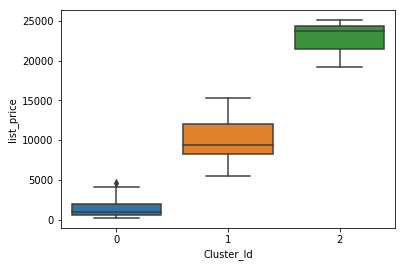

In [75]:
sns.boxplot(x='Cluster_Id', y='list_price',data=prod_cluster)
plt.show()

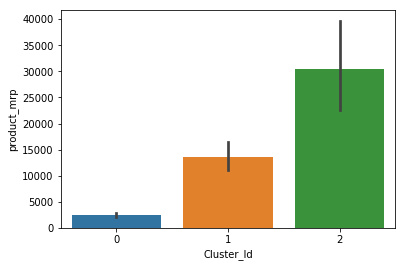

In [76]:
sns.barplot(x='Cluster_Id', y='product_mrp',data=prod_cluster)
plt.show()

In [77]:
df_clust_0 = prod_cluster[prod_cluster['Cluster_Id']==0]
print("Min. Product MRP: {1} & Max. Product MRP: {0} for Cluster 0".format(np.amax(df_clust_0['product_mrp'])
                                                                           ,np.amin(df_clust_0['product_mrp'])))
print("Min. List Price: {1} & Max. List Price: {0} for Cluster 0".format(np.amax(df_clust_0['list_price'])
                                                                         ,np.amin(df_clust_0['list_price'])))

print('\n')
df_clust_1 = prod_cluster[prod_cluster['Cluster_Id']==1]
print("Min. Product MRP: {1} & Max. Product MRP: {0} for Cluster 1".format(np.amax(df_clust_1['product_mrp'])
                                                                           ,np.amin(df_clust_1['product_mrp'])))
print("Min. List Price: {1} & Max. List Price: {0} for Cluster 1".format(np.amax(df_clust_1['list_price'])
                                                                         ,np.amin(df_clust_1['list_price'])))

print('\n')
df_clust_2 = prod_cluster[prod_cluster['Cluster_Id']==2]
print("Min. Product MRP: {1} & Max. Product MRP: {0} for Cluster 2".format(np.amax(df_clust_2['product_mrp'])
                                                                           ,np.amin(df_clust_2['product_mrp'])))
print("Min. List Price: {1} & Max. List Price: {0} for Cluster 2".format(np.amax(df_clust_2['list_price'])
                                                                         ,np.amin(df_clust_2['list_price'])))

print(pd.value_counts(prod_cluster['Cluster_Id']))

Min. Product MRP: 350.9183673469388 & Max. Product MRP: 7999.0 for Cluster 0
Min. List Price: 225.0 & Max. List Price: 4637.305719921104 for Cluster 0


Min. Product MRP: 8939.315940641456 & Max. Product MRP: 20490.0 for Cluster 1
Min. List Price: 5529.832015318334 & Max. List Price: 15299.0 for Cluster 1


Min. Product MRP: 22584.57900943396 & Max. Product MRP: 39695.57708258849 for Cluster 2
Min. List Price: 19160.26179245283 & Max. List Price: 25054.167093850556 for Cluster 2
0    61
1     7
2     3
Name: Cluster_Id, dtype: int64


In [78]:
count=[]
count=pd.value_counts(prod_cluster['Cluster_Id'])

for i in range(len(count)):
    if count[i] == np.amax(count):
        prod_cluster.loc[prod_cluster['Cluster_Id'] == i, 'product_type'] = 'Mass'
    elif count[i] == np.amin(count):
        prod_cluster.loc[prod_cluster['Cluster_Id'] == i, 'product_type'] = 'Premium'
    else:
        prod_cluster.loc[prod_cluster['Cluster_Id'] == i, 'product_type'] = 'Mid_level'

prod_cluster.head()

units    list_price   product_mrp product_analytic_vertical  Cluster_Id  \
0  1.006538   1778.074177   3092.602716         AmplifierReceiver           0   
1  1.015582   1253.217609   2785.749090            AudioMP3Player           0   
2  1.008676   1965.446727   3228.289166                Binoculars           0   
3  1.006854   3158.928391   3931.906566                   BoomBox           0   
4  1.003538  19160.261792  22584.579009                Camcorders           2   

  product_type  
0         Mass  
1         Mass  
2         Mass  
3         Mass  
4    Mid_level

In [79]:
# merging prod_cluster & consumer_media_df
consumer_media_df = consumer_media_df.merge(prod_cluster[['product_analytic_vertical','product_type']]
                                            , on='product_analytic_vertical')
consumer_media_df.head()

order_date  Year  Month     gmv  units  s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                           1   
1 2015-10-19 10:07:22  2015     10  6900.0      1                           1   
2 2015-10-20 15:45:56  2015     10  1990.0      1                           1   
3 2015-10-14 12:05:15  2015     10  1690.0      1                           0   
4 2015-10-17 21:25:03  2015     10  1618.0      1                           0   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ... Radio  Other      NPS  Stock Index  \
0               CameraAccessory  ...   0.0    0.0  44.3984         1210   
1               CameraAccessory  ...   0.0    0.0  44.3984         1210   
2               CameraAccessory  ...   0.0    0.0  44.3984         1210   
3               CameraAccessory  ...   0.0    0.0  44.3984         1210   
4               CameraAccessory  ...   0.0    0.0  44.3984         1210   

         date  holiday  payday  sale_day  discount  product_type  
0  2015-10-17        0       0         1     790.0          Mass  
1  2015-10-19        0       0         0     290.0          Mass  
2  2015-10-20        0       0         0     109.0          Mass  
3  2015-10-14        0       0         0     409.0          Mass  
4  2015-10-17        0       0         1     481.0          Mass  

[5 rows x 33 columns]

In [80]:
print(consumer_media_df.columns, consumer_media_df.shape)

Index(['order_date', 'Year', 'Month', 'gmv', 'units',
       's1_fact.order_payment_type', 'sla', 'product_analytic_super_category',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'product_mrp', 'product_procurement_sla',
       'week', 'list_price', 'Unnamed: 0', 'TV', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio',
       'Other', 'NPS', 'Stock Index', 'date', 'holiday', 'payday', 'sale_day',
       'discount', 'product_type'],
      dtype='object') (1584473, 33)


In [81]:
# KPI 9: Shelf Inflation
# Incremental Lag for list_price, discount & NPS
consumer_media_df['shelf_inflation'] = consumer_media_df['list_price'].shift(1)/consumer_media_df['list_price'] *100
consumer_media_df = consumer_media_df.fillna(0)
consumer_media_df.head()

order_date  Year  Month     gmv  units  s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                           1   
1 2015-10-19 10:07:22  2015     10  6900.0      1                           1   
2 2015-10-20 15:45:56  2015     10  1990.0      1                           1   
3 2015-10-14 12:05:15  2015     10  1690.0      1                           0   
4 2015-10-17 21:25:03  2015     10  1618.0      1                           0   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ... Other        NPS  Stock Index  \
0               CameraAccessory  ...   0.0  44.398389       1210.0   
1               CameraAccessory  ...   0.0  44.398389       1210.0   
2               CameraAccessory  ...   0.0  44.398389       1210.0   
3               CameraAccessory  ...   0.0  44.398389       1210.0   
4               CameraAccessory  ...   0.0  44.398389       1210.0   

         date  holiday  payday  sale_day  discount  product_type  \
0  2015-10-17        0       0         1     790.0          Mass   
1  2015-10-19        0       0         0     290.0          Mass   
2  2015-10-20        0       0         0     109.0          Mass   
3  2015-10-14        0       0         0     409.0          Mass   
4  2015-10-17        0       0         1     481.0          Mass   

   shelf_inflation  
0         0.000000  
1        92.753623  
2       346.733668  
3       117.751479  
4       104.449938  

[5 rows x 34 columns]

In [82]:
consumer_media_df['list_price'].describe()

count    1.584473e+06
mean     2.438156e+03
std      5.562839e+03
min      1.000000e+01
25%      3.390000e+02
50%      7.490000e+02
75%      1.990000e+03
max      2.269470e+05
Name: list_price, dtype: float64

In [83]:
# KPI 10:  % Discount offered using the (a) list price and discounted price (b) MRP and discounted price.

# Incremental Lag for list_price, discount & NPS
consumer_media_df['discout_list'] = consumer_media_df['discount']/consumer_media_df['list_price'] *100 
consumer_media_df['discout_mrp'] = consumer_media_df['discount']/consumer_media_df['product_mrp'] * 100 

consumer_media_df.head()

order_date  Year  Month     gmv  units  s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                           1   
1 2015-10-19 10:07:22  2015     10  6900.0      1                           1   
2 2015-10-20 15:45:56  2015     10  1990.0      1                           1   
3 2015-10-14 12:05:15  2015     10  1690.0      1                           0   
4 2015-10-17 21:25:03  2015     10  1618.0      1                           0   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ... Stock Index        date  holiday  payday  \
0               CameraAccessory  ...      1210.0  2015-10-17        0       0   
1               CameraAccessory  ...      1210.0  2015-10-19        0       0   
2               CameraAccessory  ...      1210.0  2015-10-20        0       0   
3               CameraAccessory  ...      1210.0  2015-10-14        0       0   
4               CameraAccessory  ...      1210.0  2015-10-17        0       0   

   sale_day  discount  product_type  shelf_inflation  discout_list  \
0         1     790.0          Mass         0.000000     12.343750   
1         0     290.0          Mass        92.753623      4.202899   
2         0     109.0          Mass       346.733668      5.477387   
3         0     409.0          Mass       117.751479     24.201183   
4         1     481.0          Mass       104.449938     29.728059   

   discout_mrp  
0    10.987483  
1     4.033380  
2     5.192949  
3    19.485469  
4    22.915674  

[5 rows x 36 columns]

In [84]:
#KPI : Brand perception KPI, dummies variables from product_type
new = pd.get_dummies(consumer_media_df.product_type, prefix= "product_type")

# merging gaming dataset with special sales, holiday and payday datasets
consumer_media_df = pd.concat([consumer_media_df, new], axis=1)
consumer_media_df.head()

order_date  Year  Month     gmv  units  s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                           1   
1 2015-10-19 10:07:22  2015     10  6900.0      1                           1   
2 2015-10-20 15:45:56  2015     10  1990.0      1                           1   
3 2015-10-14 12:05:15  2015     10  1690.0      1                           0   
4 2015-10-17 21:25:03  2015     10  1618.0      1                           0   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ... payday  sale_day  discount  product_type  \
0               CameraAccessory  ...      0         1     790.0          Mass   
1               CameraAccessory  ...      0         0     290.0          Mass   
2               CameraAccessory  ...      0         0     109.0          Mass   
3               CameraAccessory  ...      0         0     409.0          Mass   
4               CameraAccessory  ...      0         1     481.0          Mass   

   shelf_inflation  discout_list  discout_mrp  product_type_Mass  \
0         0.000000     12.343750    10.987483                  1   
1        92.753623      4.202899     4.033380                  1   
2       346.733668      5.477387     5.192949                  1   
3       117.751479     24.201183    19.485469                  1   
4       104.449938     29.728059    22.915674                  1   

   product_type_Mid_level  product_type_Premium  
0                       0                     0  
1                       0                     0  
2                       0                     0  
3                       0                     0  
4                       0                     0  

[5 rows x 39 columns]

#################################################################################################################

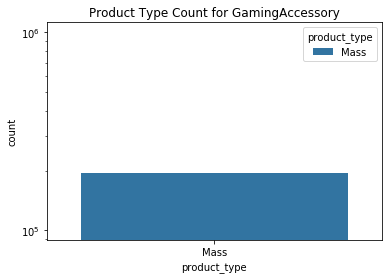

In [85]:
df_1=consumer_media_df[consumer_media_df.product_analytic_sub_category == 'GamingAccessory']
product_type_count(df_1)

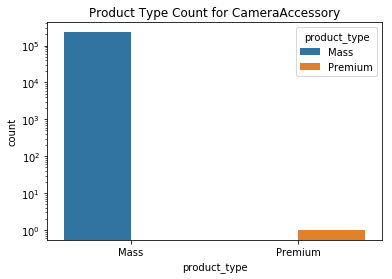

In [86]:
df_2=consumer_media_df[consumer_media_df.product_analytic_sub_category == 'CameraAccessory']
product_type_count(df_2)

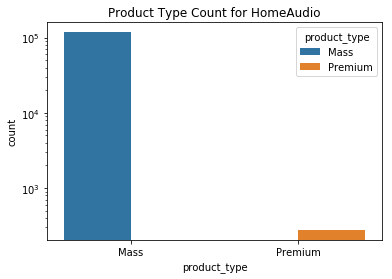

In [87]:
df_3=consumer_media_df[consumer_media_df.product_analytic_sub_category == 'HomeAudio']
product_type_count(df_3)

### **Converting Data week-wise**

In [88]:
#calculating percentage of orders for each payment type
ordr_type_prcnt = consumer_media_df.groupby('week').agg({'s1_fact.order_payment_type':['sum','count']})
ordr_type_prcnt.head()

s1_fact.order_payment_type       
                            sum  count
week                                  
1                             2    274
2                         16533  22927
3                         16452  22744
4                         17693  23538
5                         11500  15126

In [89]:
COD_prcnt=ordr_type_prcnt['s1_fact.order_payment_type','sum'].values/ordr_type_prcnt['s1_fact.order_payment_type','count']
Payment_type = pd.DataFrame(COD_prcnt)
Payment_type.columns = ['COD']
Payment_type['Prepaid'] = 1 - Payment_type['COD']
Payment_type.head()

COD   Prepaid
week                    
1     0.007299  0.992701
2     0.721115  0.278885
3     0.723356  0.276644
4     0.751678  0.248322
5     0.760280  0.239720

In [90]:
# week-wise payday data
payday_grp = consumer_media_df.groupby('week').agg({'payday':'sum'})
payday_grp.columns = payday_grp.columns.get_level_values(0)

ss = pd.DataFrame(np.where((payday_grp.payday > 0),1,0))
ss.index = payday_grp.index

payday_grp=ss
payday_grp.columns = ['payday_flag']
payday_grp.head()

payday_flag
week             
1               1
2               0
3               1
4               0
5               1

In [91]:
# week-wise special sales data
sales_grp = consumer_media_df.groupby('week').agg({'sale_day':'sum'})
sales_grp.columns = sales_grp.columns.get_level_values(0)

ss = pd.DataFrame(np.where((sales_grp.sale_day > 0),1,0))
ss.index = sales_grp.index

sales_grp=ss
sales_grp.columns = ['sale_day_flag']
sales_grp.head()

sale_day_flag
week               
1                 0
2                 0
3                 1
4                 0
5                 0

In [92]:
# week-wise holiday data
holiday_grp = consumer_media_df.groupby('week').agg({'holiday':'sum'})
holiday_grp.columns = holiday_grp.columns.get_level_values(0)

ss = pd.DataFrame(np.where((holiday_grp.holiday > 0),1,0))
ss.index = holiday_grp.index

holiday_grp=ss
holiday_grp.columns = ['holiday_flag']
holiday_grp.head()

holiday_flag
week              
1                1
2                0
3                0
4                0
5                0

**Extracting week-wise GamingAccessory data**

In [93]:
# gaming data
gaming_accessory = consumer_media_df[consumer_media_df.product_analytic_sub_category == 'GamingAccessory']
gaming_accessory.sample(10)

order_date  Year  Month     gmv  units  \
194620  2015-11-05 20:09:07  2015     11   279.0      1   
311903  2016-06-29 11:44:30  2016      6   199.0      1   
209213  2015-09-24 23:45:20  2015      9  4075.0      1   
189183  2015-10-03 20:58:56  2015     10   268.0      1   
323786  2015-10-04 19:30:00  2015     10   319.0      1   
346979  2015-12-06 11:30:29  2015     12  3949.0      1   
1010285 2015-09-06 13:38:12  2015      9   549.0      1   
244950  2015-10-30 12:22:08  2015     10   999.0      1   
219122  2016-02-24 23:35:26  2016      2   382.0      1   
289475  2016-01-23 19:14:10  2016      1   289.0      1   

         s1_fact.order_payment_type  sla product_analytic_super_category  \
194620                            1    3                              CE   
311903                            1    7                              CE   
209213                            1    5                              CE   
189183                            1    7                              CE   
323786                            1    2                              CE   
346979                            0    7                              CE   
1010285                           1    7                              CE   
244950                            1    6                              CE   
219122                            1    6                              CE   
289475                            1    6                              CE   

        product_analytic_category product_analytic_sub_category  ... payday  \
194620             GamingHardware               GamingAccessory  ...      0   
311903             GamingHardware               GamingAccessory  ...      0   
209213             GamingHardware               GamingAccessory  ...      0   
189183             GamingHardware               GamingAccessory  ...      0   
323786             GamingHardware               GamingAccessory  ...      0   
346979             GamingHardware               GamingAccessory  ...      0   
1010285            GamingHardware               GamingAccessory  ...      0   
244950             GamingHardware               GamingAccessory  ...      0   
219122             GamingHardware               GamingAccessory  ...      0   
289475             GamingHardware               GamingAccessory  ...      0   

         sale_day  discount  product_type  shelf_inflation  discout_list  \
194620          0     131.0          Mass        96.057348     46.953405   
311903          0     400.0          Mass       100.000000    201.005025   
209213          0     924.0          Mass        95.386503     22.674847   
189183          0     142.0          Mass       105.970149     52.985075   
323786          0     380.0          Mass       100.000000    119.122257   
346979          0    1750.0          Mass        87.338567     44.315016   
1010285         0     320.0          Mass       100.000000     58.287796   
244950          0     501.0          Mass        94.994995     50.150150   
219122          0     217.0          Mass       100.785340     56.806283   
289475          0     410.0          Mass       100.000000    141.868512   

         discout_mrp  product_type_Mass  product_type_Mid_level  \
194620     31.951220                  1                       0   
311903     66.777963                  1                       0   
209213     18.483697                  1                       0   
189183     34.634146                  1                       0   
323786     54.363376                  1                       0   
346979     30.707142                  1                       0   
1010285    36.823936                  1                       0   
244950     33.400000                  1                       0   
219122     36.227045                  1                       0   
289475     58.655222                  1                       0   

         product_type_Premium  
194620                      0  
311903               

In [94]:
gaming_accessory.columns

Index(['order_date', 'Year', 'Month', 'gmv', 'units',
       's1_fact.order_payment_type', 'sla', 'product_analytic_super_category',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'product_mrp', 'product_procurement_sla',
       'week', 'list_price', 'Unnamed: 0', 'TV', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio',
       'Other', 'NPS', 'Stock Index', 'date', 'holiday', 'payday', 'sale_day',
       'discount', 'product_type', 'shelf_inflation', 'discout_list',
       'discout_mrp', 'product_type_Mass', 'product_type_Mid_level',
       'product_type_Premium'],
      dtype='object')

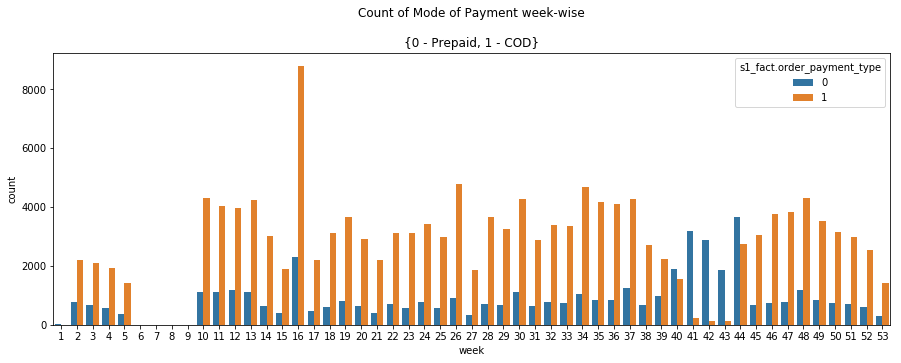

In [95]:
# Plotting payment type preferred week-wise based on holidays, paydays & sales days
plt.figure(figsize=(15,5))
sns.countplot('week', hue='s1_fact.order_payment_type', data = gaming_accessory)
plt.title("Count of Mode of Payment week-wise\n\n{0 - Prepaid, 1 - COD}")

plt.show()

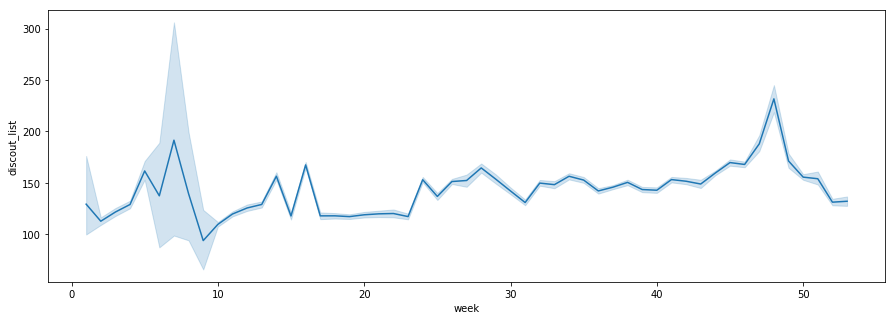

In [440]:
# Plotting the discount on list price
plt.figure(figsize=(15,5))
sns.lineplot('week', 'discout_list', data = consumer_media_df)

plt.show()

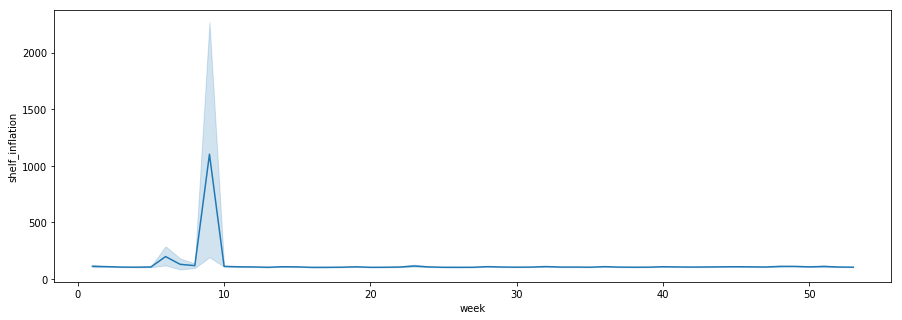

In [441]:
# Plotting the inflation on list price
plt.figure(figsize=(15,5))
sns.lineplot('week', 'shelf_inflation', data = consumer_media_df)

plt.show()

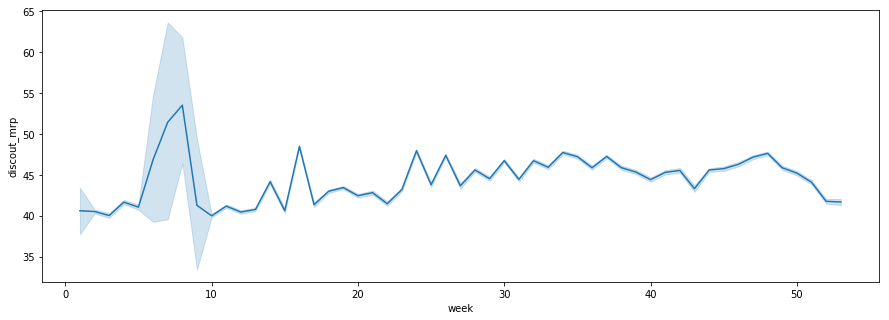

In [442]:
# Plotting the discount on mrp
plt.figure(figsize=(15,5))
sns.lineplot('week', 'discout_mrp', data = consumer_media_df)
plt.show()

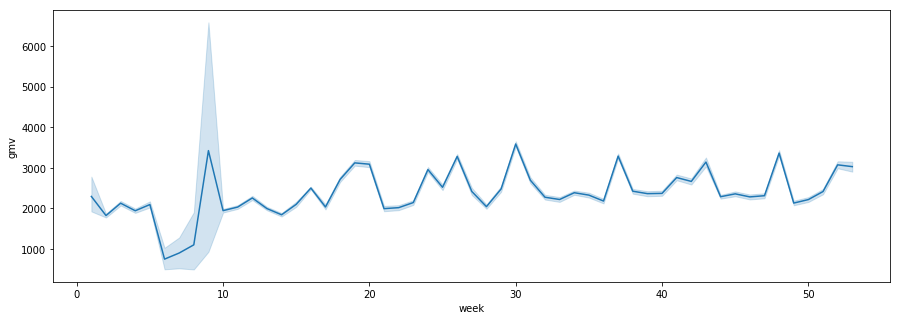

In [443]:
# Plotting the discount on mrp
plt.figure(figsize=(15,5))
sns.lineplot('week', 'gmv', data = consumer_media_df)
plt.show()

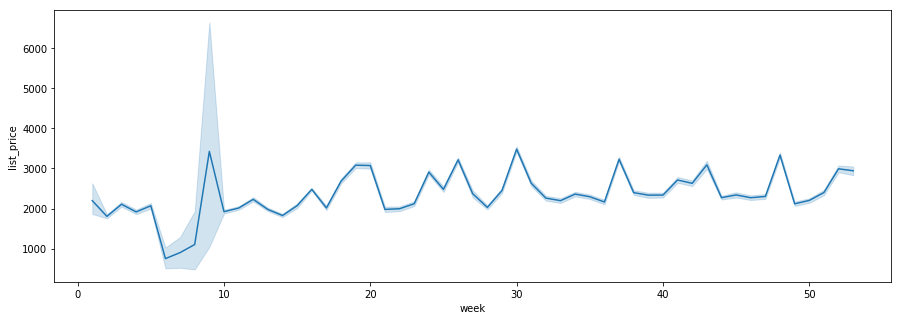

In [444]:
# Plotting the discount on mrp
plt.figure(figsize=(15,5))
sns.lineplot('week', 'list_price', data = consumer_media_df)
plt.show()

In [99]:
pd.value_counts(consumer_media_df.product_type)

Mass         1474379
Mid_level      66092
Premium        44002
Name: product_type, dtype: int64

In [100]:
# converting gaming dataset week-wise
gaming_accessory.index = gaming_accessory.week
gaming_accessory.drop(['product_analytic_sub_category', 'order_date','Year','Month','date','product_type'], 1, inplace=True)
gaming_accessory.head()

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


gmv  units  s1_fact.order_payment_type  sla  \
week                                                   
14    3075.0      1                           1    9   
16    2750.0      1                           1    7   
16    2899.0      1                           0    5   
16    2609.0      1                           0    5   
18    2772.0      1                           0    5   

     product_analytic_super_category product_analytic_category  \
week                                                             
14                                CE            GamingHardware   
16                                CE            GamingHardware   
16                                CE            GamingHardware   
16                                CE            GamingHardware   
18                                CE            GamingHardware   

     product_analytic_vertical  product_mrp  product_procurement_sla  week  \
week                                                                         
14                     GamePad         3999                        5    14   
16                     GamePad         3999                        5    16   
16                     GamePad         3999                        5    16   
16                     GamePad         3999                        5    16   
18                     GamePad         3999                        5    18   

      ...  holiday  payday  sale_day  discount  shelf_inflation  discout_list  \
week  ...                                                                       
14    ...        0       0         0     924.0         7.121951     30.048780   
16    ...        0       0         0    1249.0       111.818182     45.418182   
16    ...        0       1         1    1100.0        94.860297     37.944119   
16    ...        0       0         1    1390.0       111.115370     53.277118   
18    ...        0       0         0    1227.0        94.119769     44.264069   

      discout_mrp  product_type_Mass  product_type_Mid_level  \
week                                                           
14      23.105776                  1                       0   
16      31.232808                  1                       0   
16      27.506877                  1                       0   
16      34.758690                  1                       0   
18      30.682671                  1                       0   

      product_type_Premium  
week                        
14                       0  
16                       0  
16                       0  
16                       0  
18                       0  

[5 rows x 33 columns]

In [101]:
gaming_accessory['NPS'] = gaming_accessory.NPS.astype(float)
gaming_accessory['Stock Index'] = gaming_accessory['Stock Index'].astype(float)

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [102]:
gaming_weekly=gaming_accessory.groupby(gaming_accessory.week).agg({'gmv':['sum'],'units':['sum'],'sla':['mean'],'product_mrp':['sum']
                                          ,'product_procurement_sla':['mean'],'list_price':['sum'],'discount':['mean']
                                         ,'Stock Index':['mean'],'NPS':['mean'],'Other':['mean'],'Radio':['mean'],
                                          'SEM':['mean'],' Affiliates':['mean'],'Online marketing':['mean'],'Content Marketing':['mean']
                                         ,'Sponsorship':['mean'],'Digital':['mean'],'TV':['mean'],'shelf_inflation':['mean'],'discout_list':['mean'],
                                          'discout_mrp':['mean'],'product_type_Mass':['sum'],'product_type_Mid_level':['sum']
                                           ,'product_type_Premium':['sum'] })
gaming_weekly.columns = gaming_weekly.columns.get_level_values(0)
gaming_weekly.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
week                                                                        
1     3.760900e+04     29  3.071429       103027                 2.964286   
2     2.738062e+06   3174  5.284337      5507913                 2.981377   
3     2.310927e+06   3006  5.209666      4984618                 2.545058   
4     2.632806e+06   2606  5.313898      5801106                 2.398962   
5     1.886221e+06   1882  5.553751      8973939                 2.956327   

      list_price     discount  Stock Index        NPS  Other  ...  \
week                                                          ...   
1       37170.00  2352.035714  1177.000000  54.599588    0.0  ...   
2     2632421.00   956.266046  1177.000000  54.599588    0.0  ...   
3     2253957.36   992.245872  1177.000000  54.599588    0.0  ...   
4     2553560.50  1296.943091  1177.000000  54.599588    0.0  ...   
5     1804611.00  4014.181411  1177.016237  54.602605    0.0  ...   

      Content Marketing  Sponsorship   Digital        TV  shelf_inflation  \
week                                                                        
1              0.000933     7.414270  2.533014  0.215330        90.268159   
2              0.000933     7.414270  2.533014  0.215330       105.742100   
3              0.000933     7.414270  2.533014  0.215330       106.129159   
4              0.000933     7.414270  2.533014  0.215330       103.323293   
5              0.000932     7.410714  2.532311  0.215213       104.211178   

      discout_list  discout_mrp  product_type_Mass  product_type_Mid_level  \
week                                                                         
1       223.241280    29.560278               28.0                       0   
2       125.944696    40.644421             3007.0                       0   
3       180.692982    43.043698             2752.0                       0   
4       145.851777    37.938504             2504.0                       0   
5       511.665146    43.730407             1786.0                       0   

      product_type_Premium  
week                        
1                        0  
2                        0  
3                        0  
4                        0  
5                        0  

[5 rows x 24 columns]

In [103]:
# merging gaming dataset with special sales, holiday and payday datasets
gaming_1 = pd.concat([gaming_weekly, payday_grp, sales_grp, holiday_grp, Payment_type], axis=1)
gaming_1 = gaming_1.interpolate()
gaming_1.sample(5)

gmv  units       sla  product_mrp  product_procurement_sla  \
week                                                                        
50    3.583789e+06   4014  5.620530      6157108                 2.142526   
36    3.553429e+06   5071  5.846512      6480142                 2.394135   
7     4.875000e+03      4  6.000000        10333                 2.500000   
37    4.643528e+06   5702  5.342837      8155064                 2.546734   
28    3.415379e+06   4504  5.871918     11433189                 2.655251   

      list_price     discount  Stock Index        NPS      Other  ...  \
week                                                              ...   
50    3497135.84   684.325228  1194.000000  50.516687   0.000000  ...   
36    3479797.92   606.742989  1042.460465  49.193917  13.830221  ...   
7        4875.00  1364.500000  1206.000000  59.987101   0.000000  ...   
37    4528787.29   654.326364  1015.000000  49.020550  15.945545  ...   
28    3345172.00  1846.579224  1052.000000  47.093031  27.090000  ...   

      discout_list  discout_mrp  product_type_Mass  product_type_Mid_level  \
week                                                                         
50      143.300856    44.902332             3887.0                       0   
36      134.882541    48.132189             4945.0                       0   
7       133.033740    38.599200                4.0                       0   
37      127.856933    47.439600             5542.0                       0   
28      359.995928    47.404585             4380.0                       0   

      product_type_Premium  payday_flag  sale_day_flag  holiday_flag  \
week                                                                   
50                       0            0              0             0   
36                       0            1              0             0   
7                        0            1              1             0   
37                       0            0              0             0   
28                       0            0              0             0   

           COD   Prepaid  
week                      
50    0.798550  0.201450  
36    0.795743  0.204257  
7     0.769231  0.230769  
37    0.710779  0.289221  
28    0.818065  0.181935  

[5 rows x 29 columns]

**Extracting week-wise CameraAccessory data**

In [104]:
# camera data
camera_accessory = consumer_media_df[consumer_media_df.product_analytic_sub_category == 'CameraAccessory']
camera_accessory.head()

order_date  Year  Month     gmv  units  s1_fact.order_payment_type  \
0 2015-10-17 15:11:54  2015     10  6400.0      1                           1   
1 2015-10-19 10:07:22  2015     10  6900.0      1                           1   
2 2015-10-20 15:45:56  2015     10  1990.0      1                           1   
3 2015-10-14 12:05:15  2015     10  1690.0      1                           0   
4 2015-10-17 21:25:03  2015     10  1618.0      1                           0   

   sla product_analytic_super_category product_analytic_category  \
0    5                              CE           CameraAccessory   
1    7                              CE           CameraAccessory   
2   10                              CE           CameraAccessory   
3    4                              CE           CameraAccessory   
4    6                              CE           CameraAccessory   

  product_analytic_sub_category  ... payday  sale_day  discount  product_type  \
0               CameraAccessory  ...      0         1     790.0          Mass   
1               CameraAccessory  ...      0         0     290.0          Mass   
2               CameraAccessory  ...      0         0     109.0          Mass   
3               CameraAccessory  ...      0         0     409.0          Mass   
4               CameraAccessory  ...      0         1     481.0          Mass   

   shelf_inflation  discout_list  discout_mrp  product_type_Mass  \
0         0.000000     12.343750    10.987483                  1   
1        92.753623      4.202899     4.033380                  1   
2       346.733668      5.477387     5.192949                  1   
3       117.751479     24.201183    19.485469                  1   
4       104.449938     29.728059    22.915674                  1   

   product_type_Mid_level  product_type_Premium  
0                       0                     0  
1                       0                     0  
2                       0                     0  
3                       0                     0  
4                       0                     0  

[5 rows x 39 columns]

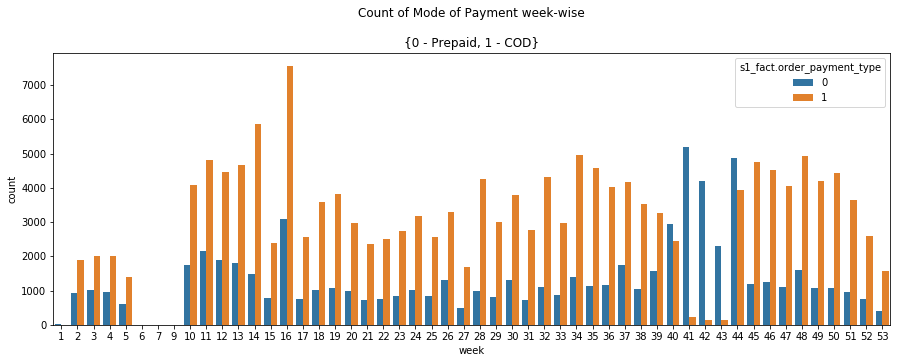

In [105]:
# Plotting payment type preferred week-wise based on holidays, paydays & sales days
plt.figure(figsize=(15,5))
sns.countplot('week', hue='s1_fact.order_payment_type', data = camera_accessory)
plt.title("Count of Mode of Payment week-wise\n\n{0 - Prepaid, 1 - COD}")

plt.show()

In [106]:
camera_accessory.index = camera_accessory.week
camera_accessory['NPS'] = camera_accessory.NPS.astype(float)
camera_accessory['Stock Index'] = camera_accessory['Stock Index'].astype(float)

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
camera_weekly=camera_accessory.groupby(camera_accessory.week).agg({'gmv':['sum'],'units':['sum'],'sla':['mean'],'product_mrp':['sum']
                                          ,'product_procurement_sla':['mean'],'list_price':['sum'],'discount':['mean']
                                         ,'Stock Index':['mean'],'NPS':['mean'],'Other':['mean'],'Radio':['mean'],
                                          'SEM':['mean'],' Affiliates':['mean'],'Online marketing':['mean'],'Content Marketing':['mean']
                                         ,'Sponsorship':['mean'],'Digital':['mean'],'TV':['mean'],'shelf_inflation':['mean'],'discout_list':['mean'],
                                          'discout_mrp':['mean'],'product_type_Mass':['sum'],'product_type_Mid_level':['sum']
                                           ,'product_type_Premium':['sum'] })
camera_weekly.columns = camera_weekly.columns.get_level_values(0)
camera_weekly.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
week                                                                     
1       17520.0     26  2.384615        39311                 2.807692   
2     3894413.0   2938  7.053718      6966304                 2.749555   
3     4523378.0   3117  6.382499      7740531                 2.781240   
4     4375438.0   3109  6.407890      7625956                 2.835841   
5     2925943.0   2082  6.368712      4951697                 2.784708   

      list_price     discount  Stock Index        NPS  Other  ...  \
week                                                          ...   
1        17520.0   838.115385  1177.000000  54.599588    0.0  ...   
2      3843690.0  1110.855212  1177.000000  54.599588    0.0  ...   
3      4466995.0  1085.030162  1177.000000  54.599588    0.0  ...   
4      4285722.0  1116.761618  1177.000000  54.599588    0.0  ...   
5      2883628.0  1040.276157  1177.029175  54.605008    0.0  ...   

      Content Marketing  Sponsorship   Digital       TV  shelf_inflation  \
week                                                                       
1              0.000933      7.41427  2.533014  0.21533       129.966747   
2              0.000933      7.41427  2.533014  0.21533       126.283845   
3              0.000933      7.41427  2.533014  0.21533       106.474504   
4              0.000933      7.41427  2.533014  0.21533       108.257899   
5              0.000932      7.40788  2.531751  0.21512       129.568954   

      discout_list  discout_mrp  product_type_Mass  product_type_Mid_level  \
week                                                                         
1       173.906662    51.612977               26.0                       0   
2       182.422832    44.998339             2811.0                       0   
3       159.139825    45.337546             3017.0                       0   
4       154.368837    44.562424             2991.0                       0   
5       136.968992    43.803299             1988.0                       0   

      product_type_Premium  
week                        
1                        0  
2                        0  
3                        0  
4                        0  
5                        0  

[5 rows x 24 columns]

In [108]:
# merging camera dataset with special sales, holida and payday datasets
camera_1 = pd.concat([camera_weekly, payday_grp, sales_grp, holiday_grp, Payment_type],axis=1)
camera_1 = camera_1.interpolate()

**Extracting week-wise HomeAudio data**

In [109]:
# home data
home_accessory = consumer_media_df[consumer_media_df.product_analytic_sub_category == 'HomeAudio']
home_accessory.head()

order_date  Year  Month     gmv  units  \
647329 2015-10-03 20:35:30  2015     10  7049.0      1   
647330 2015-10-16 09:03:09  2015     10  5489.0      1   
647331 2015-10-16 21:55:31  2015     10  6255.0      1   
647332 2015-10-16 23:25:07  2015     10  6099.0      1   
647333 2015-10-20 17:42:59  2015     10  6850.0      1   

        s1_fact.order_payment_type  sla product_analytic_super_category  \
647329                           0    5                              CE   
647330                           0    2                              CE   
647331                           0    9                              CE   
647332                           0    3                              CE   
647333                           1    9                              CE   

       product_analytic_category product_analytic_sub_category  ... payday  \
647329        EntertainmentSmall                     HomeAudio  ...      0   
647330        EntertainmentSmall                     HomeAudio  ...      0   
647331        EntertainmentSmall                     HomeAudio  ...      0   
647332        EntertainmentSmall                     HomeAudio  ...      0   
647333        EntertainmentSmall                     HomeAudio  ...      0   

        sale_day  discount  product_type  shelf_inflation  discout_list  \
647329         0     450.0          Mass        26.954178      6.383884   
647330         1    2010.0          Mass       128.420477     36.618692   
647331         1    1244.0          Mass        87.753797     19.888090   
647332         1    1400.0          Mass       102.557796     22.954583   
647333         0     649.0          Mass        89.036496      9.474453   

        discout_mrp  product_type_Mass  product_type_Mid_level  \
647329     6.000800                  1                       0   
647330    26.803574                  1                       0   
647331    16.588879                  1                       0   
647332    18.669156                  1                       0   
647333     8.654487                  1                       0   

        product_type_Premium  
647329                     0  
647330                     0  
647331                     0  
647332                     0  
647333                     0  

[5 rows x 39 columns]

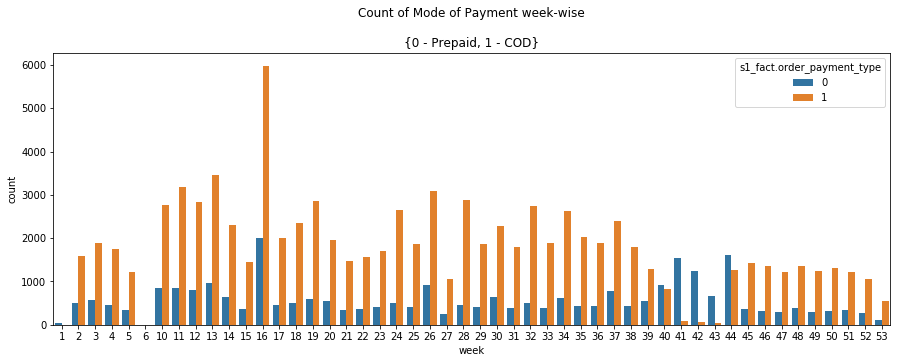

In [110]:
# Plotting payment type preferred week-wise based on holidays, paydays & sales days
plt.figure(figsize=(15,5))
sns.countplot('week', hue='s1_fact.order_payment_type', data = home_accessory)
plt.title("Count of Mode of Payment week-wise\n\n{0 - Prepaid, 1 - COD}")

plt.show()

In [111]:
home_accessory.index = home_accessory.week
home_accessory['NPS'] = home_accessory.NPS.astype(float)
home_accessory['Stock Index'] = home_accessory['Stock Index'].astype(float)

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
home_weekly=home_accessory.groupby(home_accessory.week).agg({'gmv':['sum'],'units':['sum'],'sla':['mean'],'product_mrp':['sum']
                                          ,'product_procurement_sla':['mean'],'list_price':['sum'],'discount':['mean']
                                         ,'Stock Index':['mean'],'NPS':['mean'],'Other':['mean'],'Radio':['mean'],
                                          'SEM':['mean'],' Affiliates':['mean'],'Online marketing':['mean'],'Content Marketing':['mean']
                                         ,'Sponsorship':['mean'],'Digital':['mean'],'TV':['mean'],'shelf_inflation':['mean'],'discout_list':['mean'],
                                          'discout_mrp':['mean'],'product_type_Mass':['sum'],'product_type_Mid_level':['sum']
                                           ,'product_type_Premium':['sum'] })
home_weekly.columns = home_weekly.columns.get_level_values(0)
home_weekly.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
week                                                                        
1     1.120440e+05     40  2.725000       187612                 3.375000   
2     4.686756e+06   2121  7.505955      7376128                 2.728919   
3     5.473343e+06   2473  7.112378      8881362                 2.649430   
4     4.728153e+06   2227  7.129982      7832168                 2.701993   
5     3.445256e+06   1569  7.308974      5613308                 2.660897   

      list_price     discount  Stock Index        NPS  Other  ...  \
week                                                          ...   
1      112044.00  1889.200000       1177.0  54.599588    0.0  ...   
2     4659974.13  1294.022806       1177.0  54.599588    0.0  ...   
3     5440775.00  1400.890472       1177.0  54.599588    0.0  ...   
4     4700286.00  1418.424819       1177.0  54.599588    0.0  ...   
5     3428591.00  1400.459615       1177.0  54.599588    0.0  ...   

      Content Marketing  Sponsorship   Digital       TV  shelf_inflation  \
week                                                                       
1              0.000933      7.41427  2.533014  0.21533        99.649162   
2              0.000933      7.41427  2.533014  0.21533       105.146500   
3              0.000933      7.41427  2.533014  0.21533       101.430540   
4              0.000933      7.41427  2.533014  0.21533       101.320421   
5              0.000933      7.41427  2.533014  0.21533       101.803334   

      discout_list  discout_mrp  product_type_Mass  product_type_Mid_level  \
week                                                                         
1        83.261615    36.420569               40.0                       0   
2        67.351539    32.735114             2091.0                       0   
3        69.813660    33.843726             2449.0                       0   
4        71.357988    33.624081             2204.0                       0   
5        70.018555    33.364355             1558.0                       0   

      product_type_Premium  
week                        
1                        0  
2                        8  
3                        7  
4                        4  
5                        2  

[5 rows x 24 columns]

In [113]:
# merging camera dataset with special sales, holida and payday datasets
home_1 = pd.concat([home_weekly, payday_grp, sales_grp, holiday_grp, Payment_type],axis=1)
home_1 = home_1.interpolate()
home_1.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
week                                                                         
1     1.120440e+05    40.0  2.725000     187612.0                 3.375000   
2     4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
3     5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
4     4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
5     3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

      list_price     discount  Stock Index        NPS  Other  ...  \
week                                                          ...   
1      112044.00  1889.200000       1177.0  54.599588    0.0  ...   
2     4659974.13  1294.022806       1177.0  54.599588    0.0  ...   
3     5440775.00  1400.890472       1177.0  54.599588    0.0  ...   
4     4700286.00  1418.424819       1177.0  54.599588    0.0  ...   
5     3428591.00  1400.459615       1177.0  54.599588    0.0  ...   

      discout_list  discout_mrp  product_type_Mass  product_type_Mid_level  \
week                                                                         
1        83.261615    36.420569               40.0                     0.0   
2        67.351539    32.735114             2091.0                     0.0   
3        69.813660    33.843726             2449.0                     0.0   
4        71.357988    33.624081             2204.0                     0.0   
5        70.018555    33.364355             1558.0                     0.0   

      product_type_Premium  payday_flag  sale_day_flag  holiday_flag  \
week                                                                   
1                      0.0            1              0             1   
2                      8.0            0              0             0   
3                      7.0            1              1             0   
4                      4.0            0              0             0   
5                      2.0            1              0             0   

           COD   Prepaid  
week                      
1     0.007299  0.992701  
2     0.721115  0.278885  
3     0.723356  0.276644  
4     0.751678  0.248322  
5     0.760280  0.239720  

[5 rows x 29 columns]

#### **Working with Climate Data**

In [114]:
# Climate data for year 2015
climate_2015 = pd.read_excel(r'C:/Users/abbasis/Desktop/Upgrad/ONTARIO-2015.xlsx',header=24)
climate_2015.head()

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  \
0 2015-01-01  2015      1    1            †            0.0           NaN   
1 2015-01-02  2015      1    2            †            3.0           NaN   
2 2015-01-03  2015      1    3            †            2.5           NaN   
3 2015-01-04  2015      1    4            †            2.5           NaN   
4 2015-01-05  2015      1    5            †          -10.0           NaN   

   Min Temp (°C) Min Temp Flag  Mean Temp (°C)  ... Total Snow (cm)  \
0           -8.5           NaN            -4.3  ...             0.0   
1           -3.0           NaN             0.0  ...             0.0   
2           -4.0           NaN            -0.8  ...             0.0   
3            0.0           NaN             1.3  ...             1.0   
4          -13.5           NaN           -11.8  ...             3.0   

   Total Snow Flag Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
0              NaN               0.0                NaN               0.0   
1              NaN               0.0                NaN               0.0   
2              NaN              24.0                NaN               0.0   
3              NaN               1.0                NaN               0.0   
4              NaN               3.0                NaN               1.0   

   Snow on Grnd Flag Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

  Spd of Max Gust (km/h)  Spd of Max Gust Flag  
0                    NaN                   NaN  
1                    NaN                   NaN  
2                    NaN                   NaN  
3                    NaN                   NaN  
4                    NaN                   NaN  

[5 rows x 27 columns]

In [115]:
# Climate data for year 2016
climate_2016 = pd.read_excel(r'C:/Users/abbasis/Desktop/Upgrad/ONTARIO-2016.xlsx',header=24)
climate_2016.head()

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  \
0 2016-01-01  2016      1    1          NaN            NaN           NaN   
1 2016-01-02  2016      1    2          NaN            NaN           NaN   
2 2016-01-03  2016      1    3          NaN            NaN           NaN   
3 2016-01-04  2016      1    4          NaN            NaN           NaN   
4 2016-01-05  2016      1    5          NaN            NaN           NaN   

   Min Temp (°C) Min Temp Flag  Mean Temp (°C)  ... Total Snow (cm)  \
0            NaN           NaN             NaN  ...             NaN   
1            NaN           NaN             NaN  ...             NaN   
2            NaN           NaN             NaN  ...             NaN   
3            NaN           NaN             NaN  ...             NaN   
4            NaN           NaN             NaN  ...             NaN   

   Total Snow Flag Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
0              NaN               NaN                NaN               NaN   
1              NaN               NaN                NaN               NaN   
2              NaN               NaN                NaN               NaN   
3              NaN               NaN                NaN               NaN   
4              NaN               NaN                NaN               NaN   

   Snow on Grnd Flag Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

  Spd of Max Gust (km/h)  Spd of Max Gust Flag  
0                    NaN                   NaN  
1                    NaN                   NaN  
2                    NaN                   NaN  
3                    NaN                   NaN  
4                    NaN                   NaN  

[5 rows x 27 columns]

In [116]:
climate = pd.concat([climate_2015,climate_2016])
climate.sample(5)

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  \
275 2016-10-02  2016     10    2            †           22.0           NaN   
31  2016-02-01  2016      2    1          NaN            NaN           NaN   
314 2016-11-10  2016     11   10          NaN            NaN           NaN   
219 2015-08-08  2015      8    8            †           25.0           NaN   
7   2016-01-08  2016      1    8            †            7.0           NaN   

     Min Temp (°C) Min Temp Flag  Mean Temp (°C)  ... Total Snow (cm)  \
275           11.0           NaN            16.5  ...             0.0   
31             NaN           NaN             NaN  ...             NaN   
314            NaN           NaN             NaN  ...             NaN   
219           15.0           NaN            20.0  ...             0.0   
7            -14.0           NaN            -3.5  ...             0.0   

     Total Snow Flag Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
275              NaN               0.0                NaN               0.0   
31               NaN               NaN                NaN               NaN   
314              NaN               NaN                NaN               NaN   
219              NaN               1.4                NaN               0.0   
7                NaN               9.0                NaN               0.0   

     Snow on Grnd Flag Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
275                NaN                       NaN                   NaN   
31                 NaN                       NaN                   NaN   
314                NaN                       NaN                   NaN   
219                NaN                       NaN                   NaN   
7                  NaN                       NaN                   NaN   

    Spd of Max Gust (km/h)  Spd of Max Gust Flag  
275                    NaN                   NaN  
31                     NaN                   NaN  
314                    NaN                   NaN  
219                    NaN                   NaN  
7                      NaN                   NaN  

[5 rows x 27 columns]

In [117]:
# Creating week feature in the climate dataset
climate['week'] = climate['Date/Time'].dt.week

climate.head()

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  \
0 2015-01-01  2015      1    1            †            0.0           NaN   
1 2015-01-02  2015      1    2            †            3.0           NaN   
2 2015-01-03  2015      1    3            †            2.5           NaN   
3 2015-01-04  2015      1    4            †            2.5           NaN   
4 2015-01-05  2015      1    5            †          -10.0           NaN   

   Min Temp (°C) Min Temp Flag  Mean Temp (°C)  ... Total Snow Flag  \
0           -8.5           NaN            -4.3  ...             NaN   
1           -3.0           NaN             0.0  ...             NaN   
2           -4.0           NaN            -0.8  ...             NaN   
3            0.0           NaN             1.3  ...             NaN   
4          -13.5           NaN           -11.8  ...             NaN   

   Total Precip (mm) Total Precip Flag  Snow on Grnd (cm) Snow on Grnd Flag  \
0                0.0               NaN                0.0               NaN   
1                0.0               NaN                0.0               NaN   
2               24.0               NaN                0.0               NaN   
3                1.0               NaN                0.0               NaN   
4                3.0               NaN                1.0               NaN   

   Dir of Max Gust (10s deg) Dir of Max Gust Flag  Spd of Max Gust (km/h)  \
0                        NaN                  NaN                     NaN   
1                        NaN                  NaN                     NaN   
2                        NaN                  NaN                     NaN   
3                        NaN                  NaN                     NaN   
4                        NaN                  NaN                     NaN   

  Spd of Max Gust Flag  week  
0                  NaN     1  
1                  NaN     1  
2                  NaN     1  
3                  NaN     1  
4                  NaN     2  

[5 rows x 28 columns]

In [118]:
climate = climate[((climate.Year == 2016) & (climate.week <= 26)) | ((climate.Year == 2015) & (climate.week >= 27)) ]
climate.index = range(len(climate.index))

In [119]:
climate.week.unique()

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26], dtype=int64)

In [120]:
climate['week'] = np.where((climate.Year == 2015), climate.week-26,climate.week)
climate['week'] = np.where((climate.Year == 2016), climate.week+27,climate.week)
climate.week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53], dtype=int64)

In [121]:
climate.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)',
       'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)',
       'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag',
       'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)',
       'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag',
       'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)',
       'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag', 'week'],
      dtype='object')

In [122]:
lst = ['Data Quality','Max Temp Flag','Min Temp Flag','Mean Temp Flag','Heat Deg Days Flag','Cool Deg Days Flag','Total Rain Flag','Total Snow Flag','Total Precip Flag','Snow on Grnd Flag','Dir of Max Gust (10s deg)','Dir of Max Gust Flag','Spd of Max Gust (km/h)','Spd of Max Gust Flag']
climate.drop(lst , 1, inplace = True)
climate.head()

Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0 2015-06-29  2015      6   29           24.5           15.0            19.8   
1 2015-06-30  2015      6   30           26.0           17.0            21.5   
2 2015-07-01  2015      7    1           24.5           17.0            20.8   
3 2015-07-02  2015      7    2           24.0           14.0            19.0   
4 2015-07-03  2015      7    3           25.0           10.0            17.5   

   Heat Deg Days (°C)  Cool Deg Days (°C)  Total Rain (mm)  Total Snow (cm)  \
0                 0.0                 1.8              1.8              0.0   
1                 0.0                 3.5              2.4              0.0   
2                 0.0                 2.8              0.0              0.0   
3                 0.0                 1.0              0.0              0.0   
4                 0.5                 0.0              0.0              0.0   

   Total Precip (mm)  Snow on Grnd (cm)  week  
0                1.8                0.0     1  
1                2.4                0.0     1  
2                0.0                0.0     1  
3                0.0                0.0     1  
4                0.0                0.0     1

In [123]:
np.sort(climate.isnull().sum(axis=1))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [124]:
climate = climate[climate.isnull().sum(axis=1)<6]
climate.head()

Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0 2015-06-29  2015      6   29           24.5           15.0            19.8   
1 2015-06-30  2015      6   30           26.0           17.0            21.5   
2 2015-07-01  2015      7    1           24.5           17.0            20.8   
3 2015-07-02  2015      7    2           24.0           14.0            19.0   
4 2015-07-03  2015      7    3           25.0           10.0            17.5   

   Heat Deg Days (°C)  Cool Deg Days (°C)  Total Rain (mm)  Total Snow (cm)  \
0                 0.0                 1.8              1.8              0.0   
1                 0.0                 3.5              2.4              0.0   
2                 0.0                 2.8              0.0              0.0   
3                 0.0                 1.0              0.0              0.0   
4                 0.5                 0.0              0.0              0.0   

   Total Precip (mm)  Snow on Grnd (cm)  week  
0                1.8                0.0     1  
1                2.4                0.0     1  
2                0.0                0.0     1  
3                0.0                0.0     1  
4                0.0                0.0     1

In [125]:
climate.shape

(219, 14)

In [126]:
climate.week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53], dtype=int64)

In [127]:
climate.index=climate.week
climate.drop(['Month','Year','Day'],1, inplace=True)

In [128]:
# Converting climate data week-wise
climate = climate.groupby(climate.week).mean()
climate=climate.interpolate()
climate.head()

Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  \
week                                                                     
1         25.428571      14.000000       19.728571            0.071429   
2         24.833333      15.333333       20.100000            0.283333   
3         28.750000      17.583333       23.183333            0.000000   
4         29.750000      16.600000       23.060000            0.000000   
5         31.583333      17.500000       24.566667            0.000000   

      Cool Deg Days (°C)  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  \
week                                                                            
1               1.800000         0.600000              0.0           0.600000   
2               2.383333         4.416667              0.0           4.416667   
3               5.183333         1.400000              0.0           1.400000   
4               5.060000         0.900000              0.0           0.900000   
5               6.566667         4.633333              0.0           4.633333   

      Snow on Grnd (cm)  
week                     
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
5                   0.0

#### **Final Dataset**

In [129]:
# Final gaming accessory dataset
gaming_accessory_final = pd.concat([gaming_1,climate],1)
gaming_accessory_final.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
week                                                                        
1     3.760900e+04     29  3.071429       103027                 2.964286   
2     2.738062e+06   3174  5.284337      5507913                 2.981377   
3     2.310927e+06   3006  5.209666      4984618                 2.545058   
4     2.632806e+06   2606  5.313898      5801106                 2.398962   
5     1.886221e+06   1882  5.553751      8973939                 2.956327   

      list_price     discount  Stock Index        NPS  Other  ...   Prepaid  \
week                                                          ...             
1       37170.00  2352.035714  1177.000000  54.599588    0.0  ...  0.992701   
2     2632421.00   956.266046  1177.000000  54.599588    0.0  ...  0.278885   
3     2253957.36   992.245872  1177.000000  54.599588    0.0  ...  0.276644   
4     2553560.50  1296.943091  1177.000000  54.599588    0.0  ...  0.248322   
5     1804611.00  4014.181411  1177.016237  54.602605    0.0  ...  0.239720   

      Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  \
week                                                                     
1         25.428571      14.000000       19.728571            0.071429   
2         24.833333      15.333333       20.100000            0.283333   
3         28.750000      17.583333       23.183333            0.000000   
4         29.750000      16.600000       23.060000            0.000000   
5         31.583333      17.500000       24.566667            0.000000   

      Cool Deg Days (°C)  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  \
week                                                                            
1               1.800000         0.600000              0.0           0.600000   
2               2.383333         4.416667              0.0           4.416667   
3               5.183333         1.400000              0.0           1.400000   
4               5.060000         0.900000              0.0           0.900000   
5               6.566667         4.633333              0.0           4.633333   

      Snow on Grnd (cm)  
week                     
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
5                   0.0  

[5 rows x 38 columns]

In [130]:
gaming_accessory_final['week'] = gaming_accessory_final.index
gaming_accessory_final.rename(columns={' Affiliates':'Affiliates'},inplace=True)
gaming_accessory_final.index = range(len(gaming_accessory_final))
gaming_accessory_final.columns

Index(['gmv', 'units', 'sla', 'product_mrp', 'product_procurement_sla',
       'list_price', 'discount', 'Stock Index', 'NPS', 'Other', 'Radio', 'SEM',
       'Affiliates', 'Online marketing', 'Content Marketing', 'Sponsorship',
       'Digital', 'TV', 'shelf_inflation', 'discout_list', 'discout_mrp',
       'product_type_Mass', 'product_type_Mid_level', 'product_type_Premium',
       'payday_flag', 'sale_day_flag', 'holiday_flag', 'COD', 'Prepaid',
       'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
       'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'week'],
      dtype='object')

In [131]:
# Final camera accessory dataset
camera_accessory_final = pd.concat([camera_1,climate],1)
camera_accessory_final.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
week                                                                      
1       17520.0    26.0  2.384615      39311.0                 2.807692   
2     3894413.0  2938.0  7.053718    6966304.0                 2.749555   
3     4523378.0  3117.0  6.382499    7740531.0                 2.781240   
4     4375438.0  3109.0  6.407890    7625956.0                 2.835841   
5     2925943.0  2082.0  6.368712    4951697.0                 2.784708   

      list_price     discount  Stock Index        NPS  Other  ...   Prepaid  \
week                                                          ...             
1        17520.0   838.115385  1177.000000  54.599588    0.0  ...  0.992701   
2      3843690.0  1110.855212  1177.000000  54.599588    0.0  ...  0.278885   
3      4466995.0  1085.030162  1177.000000  54.599588    0.0  ...  0.276644   
4      4285722.0  1116.761618  1177.000000  54.599588    0.0  ...  0.248322   
5      2883628.0  1040.276157  1177.029175  54.605008    0.0  ...  0.239720   

      Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  \
week                                                                     
1         25.428571      14.000000       19.728571            0.071429   
2         24.833333      15.333333       20.100000            0.283333   
3         28.750000      17.583333       23.183333            0.000000   
4         29.750000      16.600000       23.060000            0.000000   
5         31.583333      17.500000       24.566667            0.000000   

      Cool Deg Days (°C)  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  \
week                                                                            
1               1.800000         0.600000              0.0           0.600000   
2               2.383333         4.416667              0.0           4.416667   
3               5.183333         1.400000              0.0           1.400000   
4               5.060000         0.900000              0.0           0.900000   
5               6.566667         4.633333              0.0           4.633333   

      Snow on Grnd (cm)  
week                     
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
5                   0.0  

[5 rows x 38 columns]

In [132]:
camera_accessory_final['week'] = camera_accessory_final.index
camera_accessory_final.rename(columns={' Affiliates':'Affiliates'},inplace=True)
camera_accessory_final.index = range(len(camera_accessory_final))
camera_accessory_final.columns

Index(['gmv', 'units', 'sla', 'product_mrp', 'product_procurement_sla',
       'list_price', 'discount', 'Stock Index', 'NPS', 'Other', 'Radio', 'SEM',
       'Affiliates', 'Online marketing', 'Content Marketing', 'Sponsorship',
       'Digital', 'TV', 'shelf_inflation', 'discout_list', 'discout_mrp',
       'product_type_Mass', 'product_type_Mid_level', 'product_type_Premium',
       'payday_flag', 'sale_day_flag', 'holiday_flag', 'COD', 'Prepaid',
       'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
       'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'week'],
      dtype='object')

In [133]:
# Final home accessory dataset
home_accessory_final = pd.concat([home_1,climate],1)
home_accessory_final.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
week                                                                         
1     1.120440e+05    40.0  2.725000     187612.0                 3.375000   
2     4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
3     5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
4     4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
5     3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

      list_price     discount  Stock Index        NPS  Other  ...   Prepaid  \
week                                                          ...             
1      112044.00  1889.200000       1177.0  54.599588    0.0  ...  0.992701   
2     4659974.13  1294.022806       1177.0  54.599588    0.0  ...  0.278885   
3     5440775.00  1400.890472       1177.0  54.599588    0.0  ...  0.276644   
4     4700286.00  1418.424819       1177.0  54.599588    0.0  ...  0.248322   
5     3428591.00  1400.459615       1177.0  54.599588    0.0  ...  0.239720   

      Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  \
week                                                                     
1         25.428571      14.000000       19.728571            0.071429   
2         24.833333      15.333333       20.100000            0.283333   
3         28.750000      17.583333       23.183333            0.000000   
4         29.750000      16.600000       23.060000            0.000000   
5         31.583333      17.500000       24.566667            0.000000   

      Cool Deg Days (°C)  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  \
week                                                                            
1               1.800000         0.600000              0.0           0.600000   
2               2.383333         4.416667              0.0           4.416667   
3               5.183333         1.400000              0.0           1.400000   
4               5.060000         0.900000              0.0           0.900000   
5               6.566667         4.633333              0.0           4.633333   

      Snow on Grnd (cm)  
week                     
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
5                   0.0  

[5 rows x 38 columns]

In [134]:
home_accessory_final['week'] = home_accessory_final.index
home_accessory_final.rename(columns={' Affiliates':'Affiliates'},inplace=True)
home_accessory_final.index = range(len(home_accessory_final))
home_accessory_final.columns

Index(['gmv', 'units', 'sla', 'product_mrp', 'product_procurement_sla',
       'list_price', 'discount', 'Stock Index', 'NPS', 'Other', 'Radio', 'SEM',
       'Affiliates', 'Online marketing', 'Content Marketing', 'Sponsorship',
       'Digital', 'TV', 'shelf_inflation', 'discout_list', 'discout_mrp',
       'product_type_Mass', 'product_type_Mid_level', 'product_type_Premium',
       'payday_flag', 'sale_day_flag', 'holiday_flag', 'COD', 'Prepaid',
       'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
       'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'week'],
      dtype='object')

**Writing each category's dataset into a csv file.**

In [135]:
gaming_accessory_final.to_csv(r'C:/Users/abbasis/Desktop/Upgrad/gaming_accessory_final.csv')
camera_accessory_final.to_csv(r'C:/Users/abbasis/Desktop/Upgrad/camera_accessory_final.csv')
home_accessory_final.to_csv(r'C:/Users/abbasis/Desktop/Upgrad/home_audio_final.csv')

# **Exploratory Data Analysis**

### **1. Gaming Accessory**

In [137]:
# Reading the gaming accessory dataset
gaming_df = pd.read_csv(r'C:/Users/abbasis/Desktop/Upgrad/gaming_accessory_final.csv')
gaming_df.drop(['Unnamed: 0'],1,inplace=True)
gaming_df.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
0  3.760900e+04     29  3.071429       103027                 2.964286   
1  2.738062e+06   3174  5.284337      5507913                 2.981377   
2  2.310927e+06   3006  5.209666      4984618                 2.545058   
3  2.632806e+06   2606  5.313898      5801106                 2.398962   
4  1.886221e+06   1882  5.553751      8973939                 2.956327   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0    37170.00  2352.035714  1177.000000  54.599588    0.0  ...      25.428571   
1  2632421.00   956.266046  1177.000000  54.599588    0.0  ...      24.833333   
2  2253957.36   992.245872  1177.000000  54.599588    0.0  ...      28.750000   
3  2553560.50  1296.943091  1177.000000  54.599588    0.0  ...      29.750000   
4  1804611.00  4014.181411  1177.016237  54.602605    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

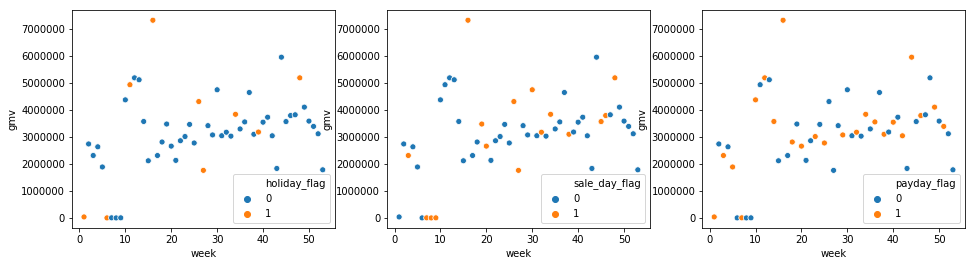

In [138]:
EDA_1(gaming_df)

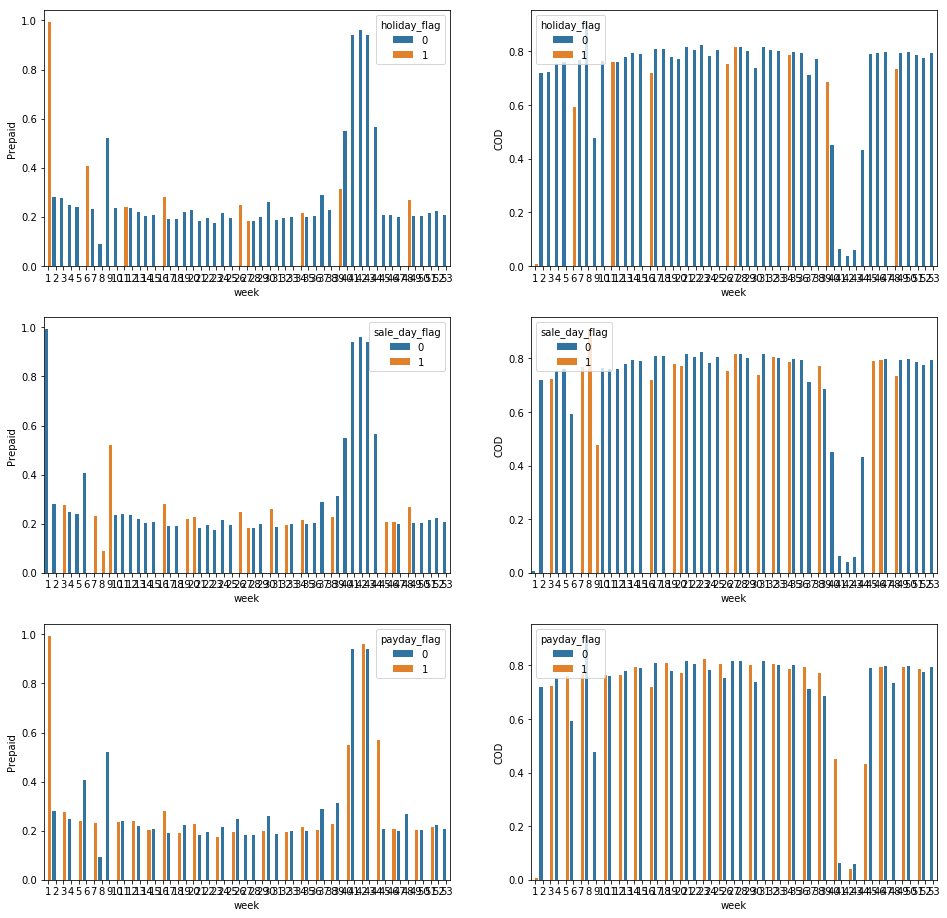

In [139]:
EDA_2(gaming_df)

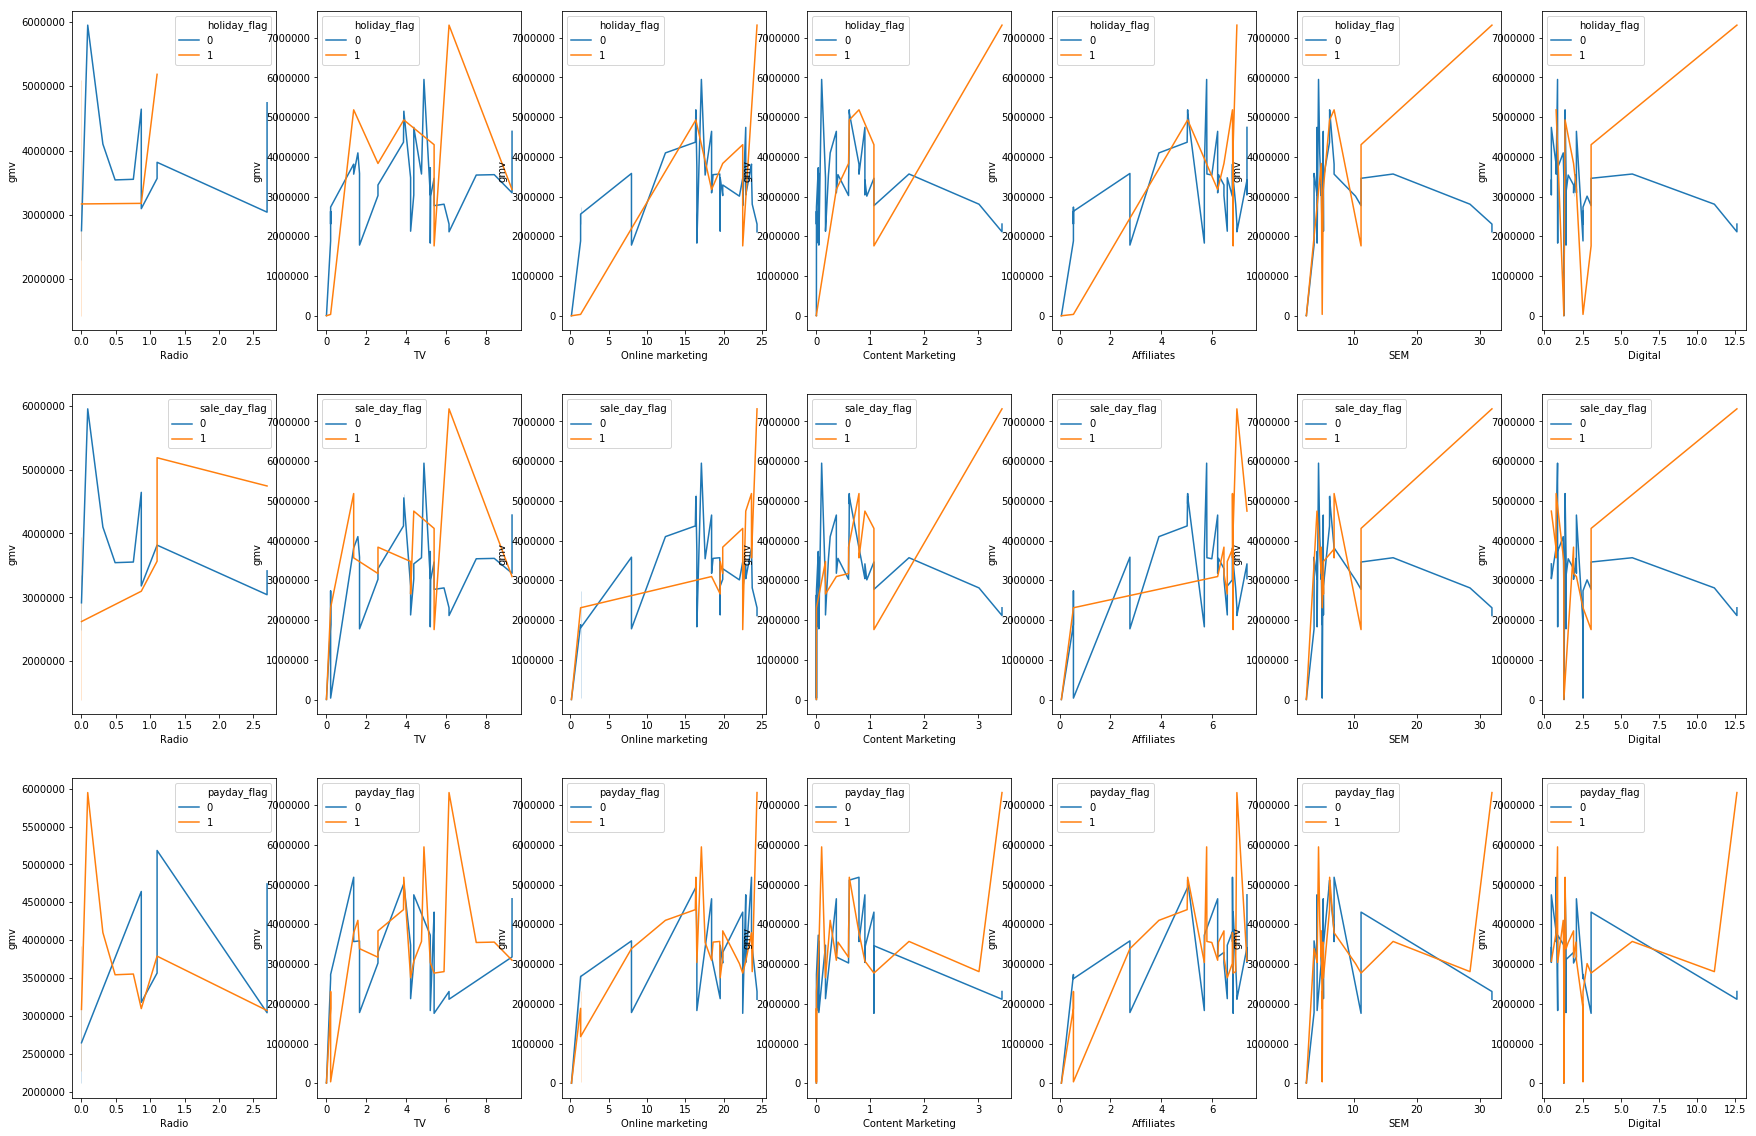

In [140]:
EDA_3(gaming_df,'gmv')

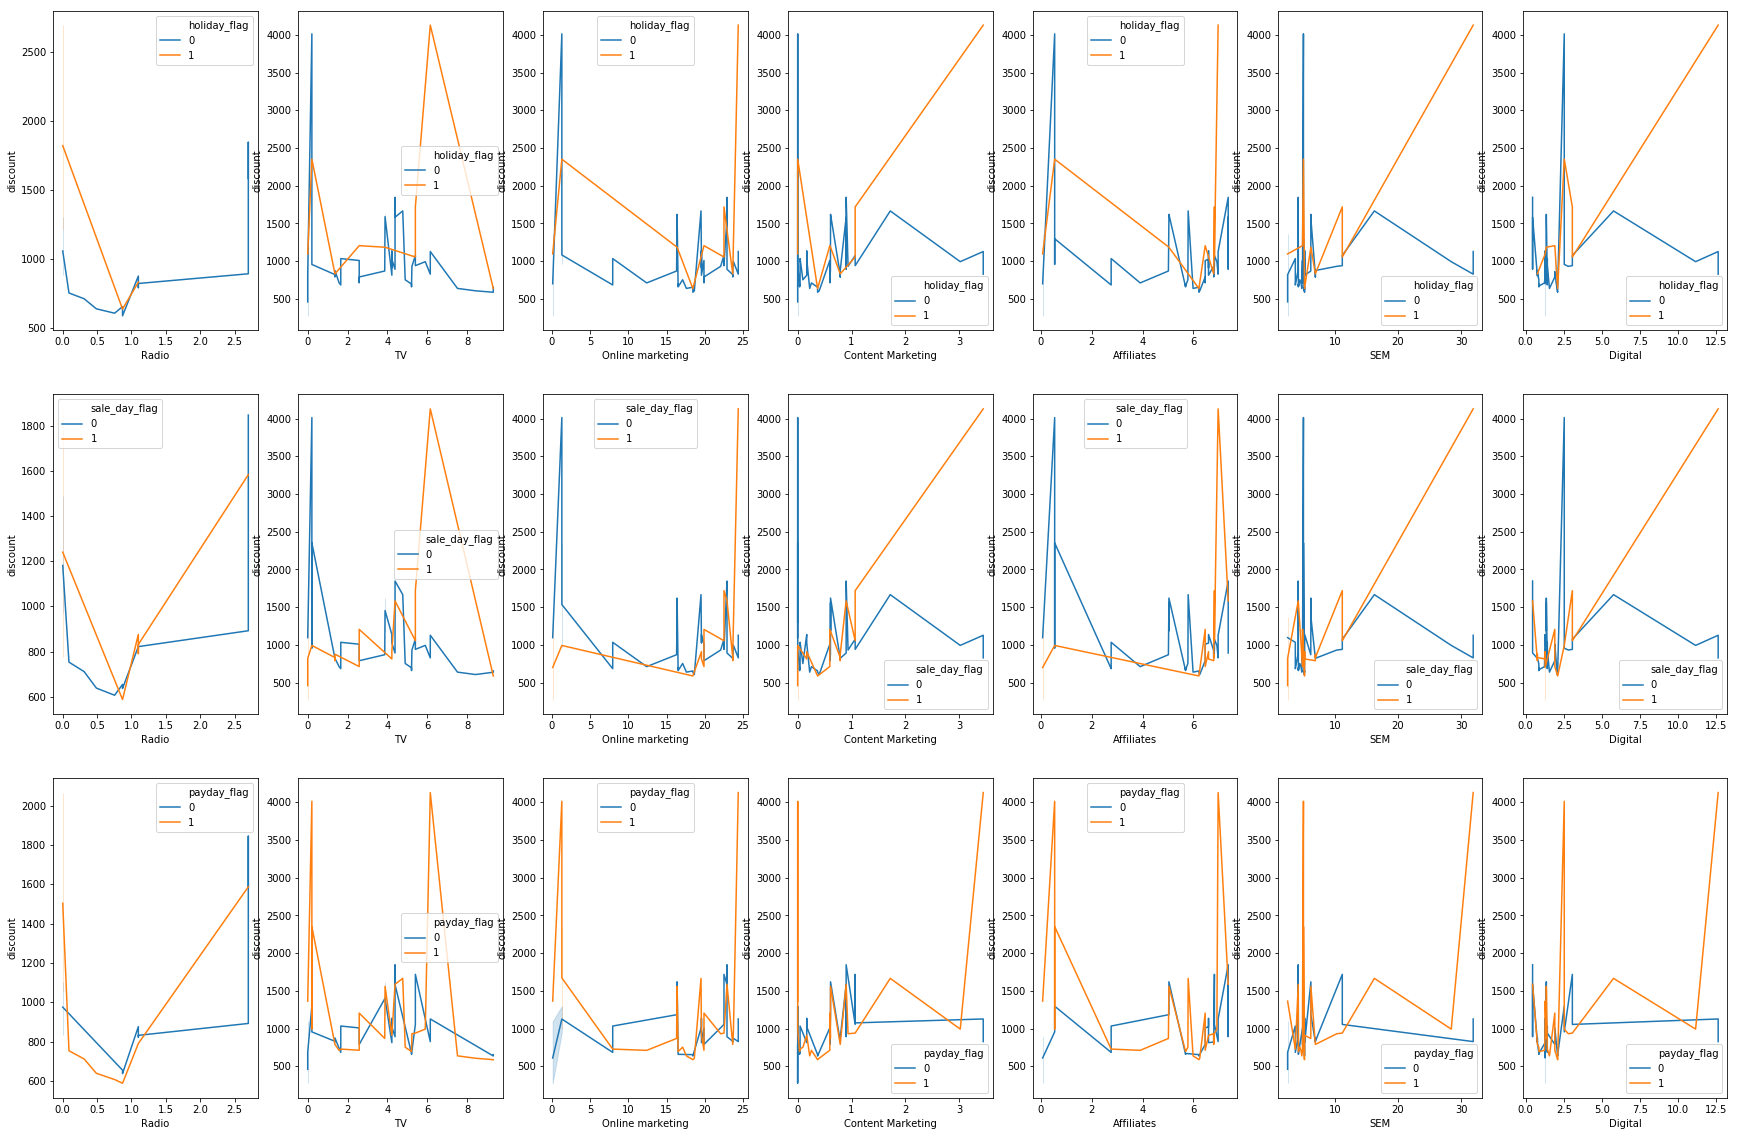

In [141]:
EDA_3(gaming_df,'discount')

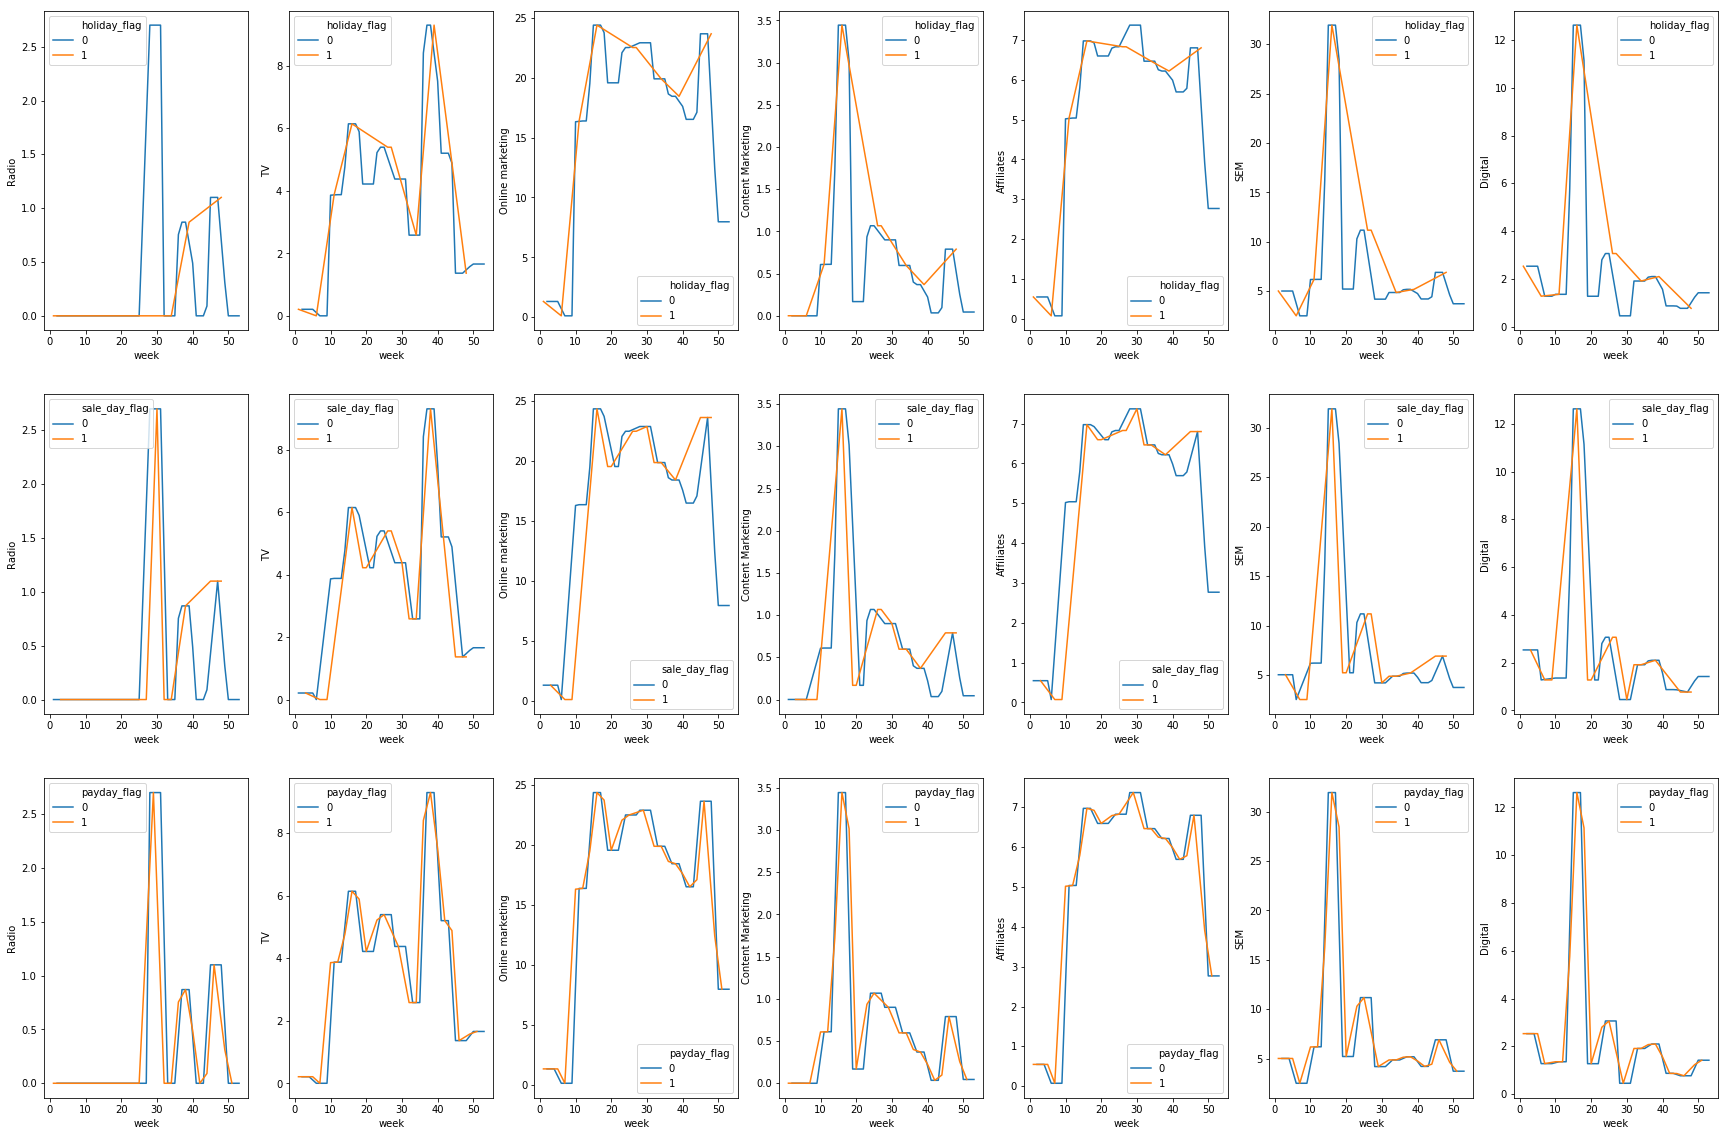

In [142]:
EDA_3(gaming_df, 'week')

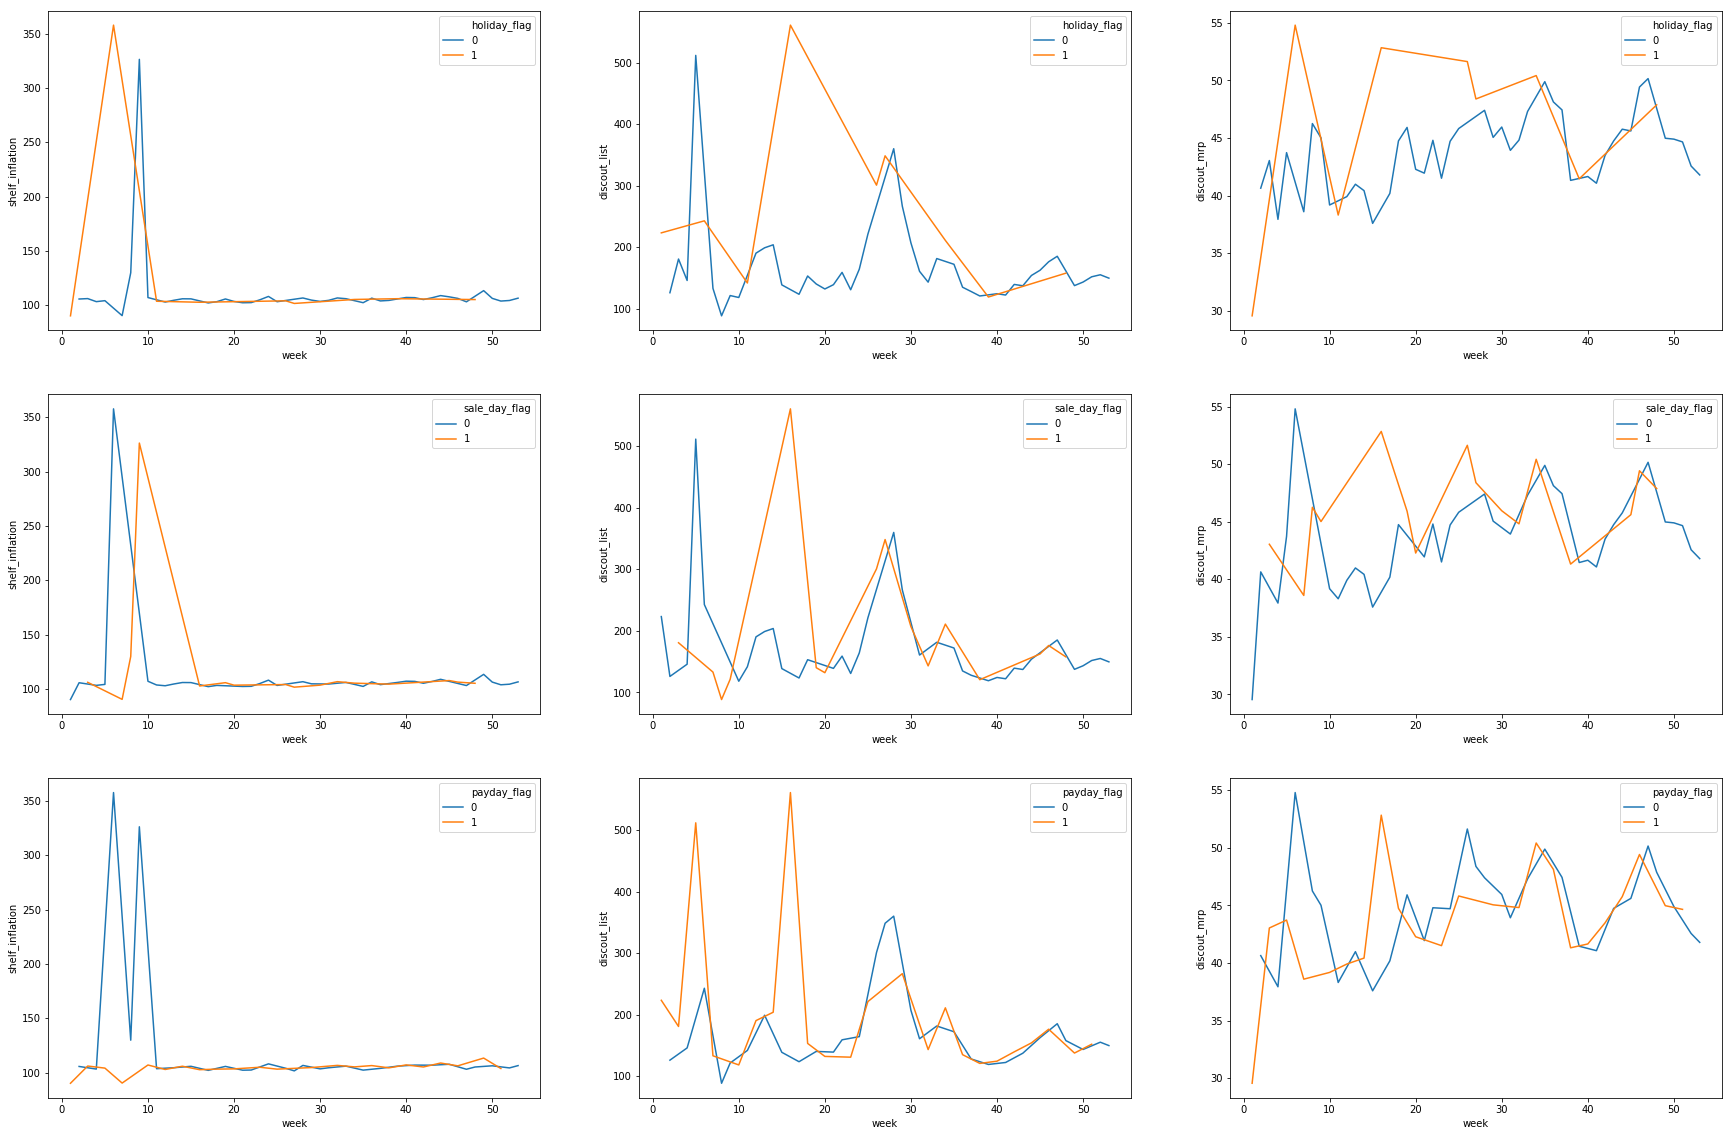

In [143]:
EDA_4(gaming_df)

### **2. Camera Accessory**

In [144]:
camera_df = pd.read_csv(r'C:/Users/abbasis/Desktop/Upgrad/camera_accessory_final.csv')
camera_df.drop(['Unnamed: 0'],1,inplace=True)
camera_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0    17520.0    26.0  2.384615      39311.0                 2.807692   
1  3894413.0  2938.0  7.053718    6966304.0                 2.749555   
2  4523378.0  3117.0  6.382499    7740531.0                 2.781240   
3  4375438.0  3109.0  6.407890    7625956.0                 2.835841   
4  2925943.0  2082.0  6.368712    4951697.0                 2.784708   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0     17520.0   838.115385  1177.000000  54.599588    0.0  ...      25.428571   
1   3843690.0  1110.855212  1177.000000  54.599588    0.0  ...      24.833333   
2   4466995.0  1085.030162  1177.000000  54.599588    0.0  ...      28.750000   
3   4285722.0  1116.761618  1177.000000  54.599588    0.0  ...      29.750000   
4   2883628.0  1040.276157  1177.029175  54.605008    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

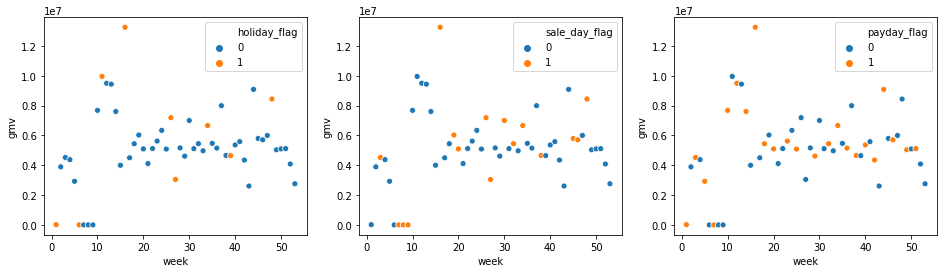

In [145]:
EDA_1(camera_df)

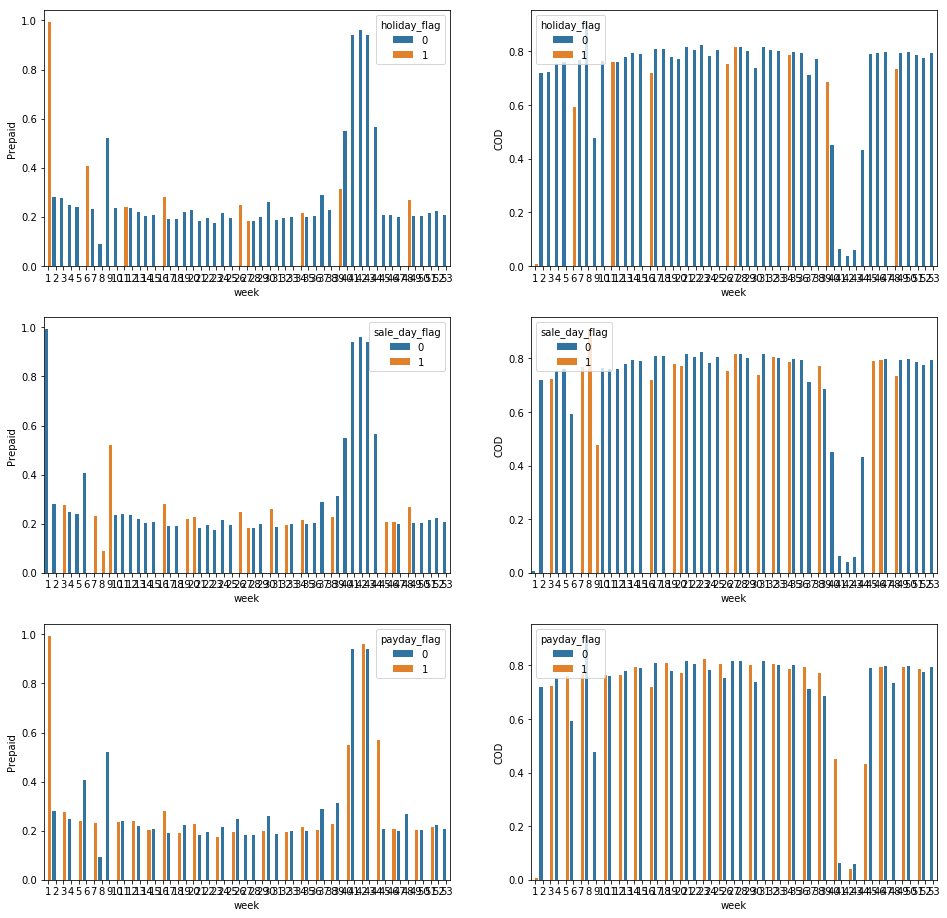

In [146]:
EDA_2(camera_df)

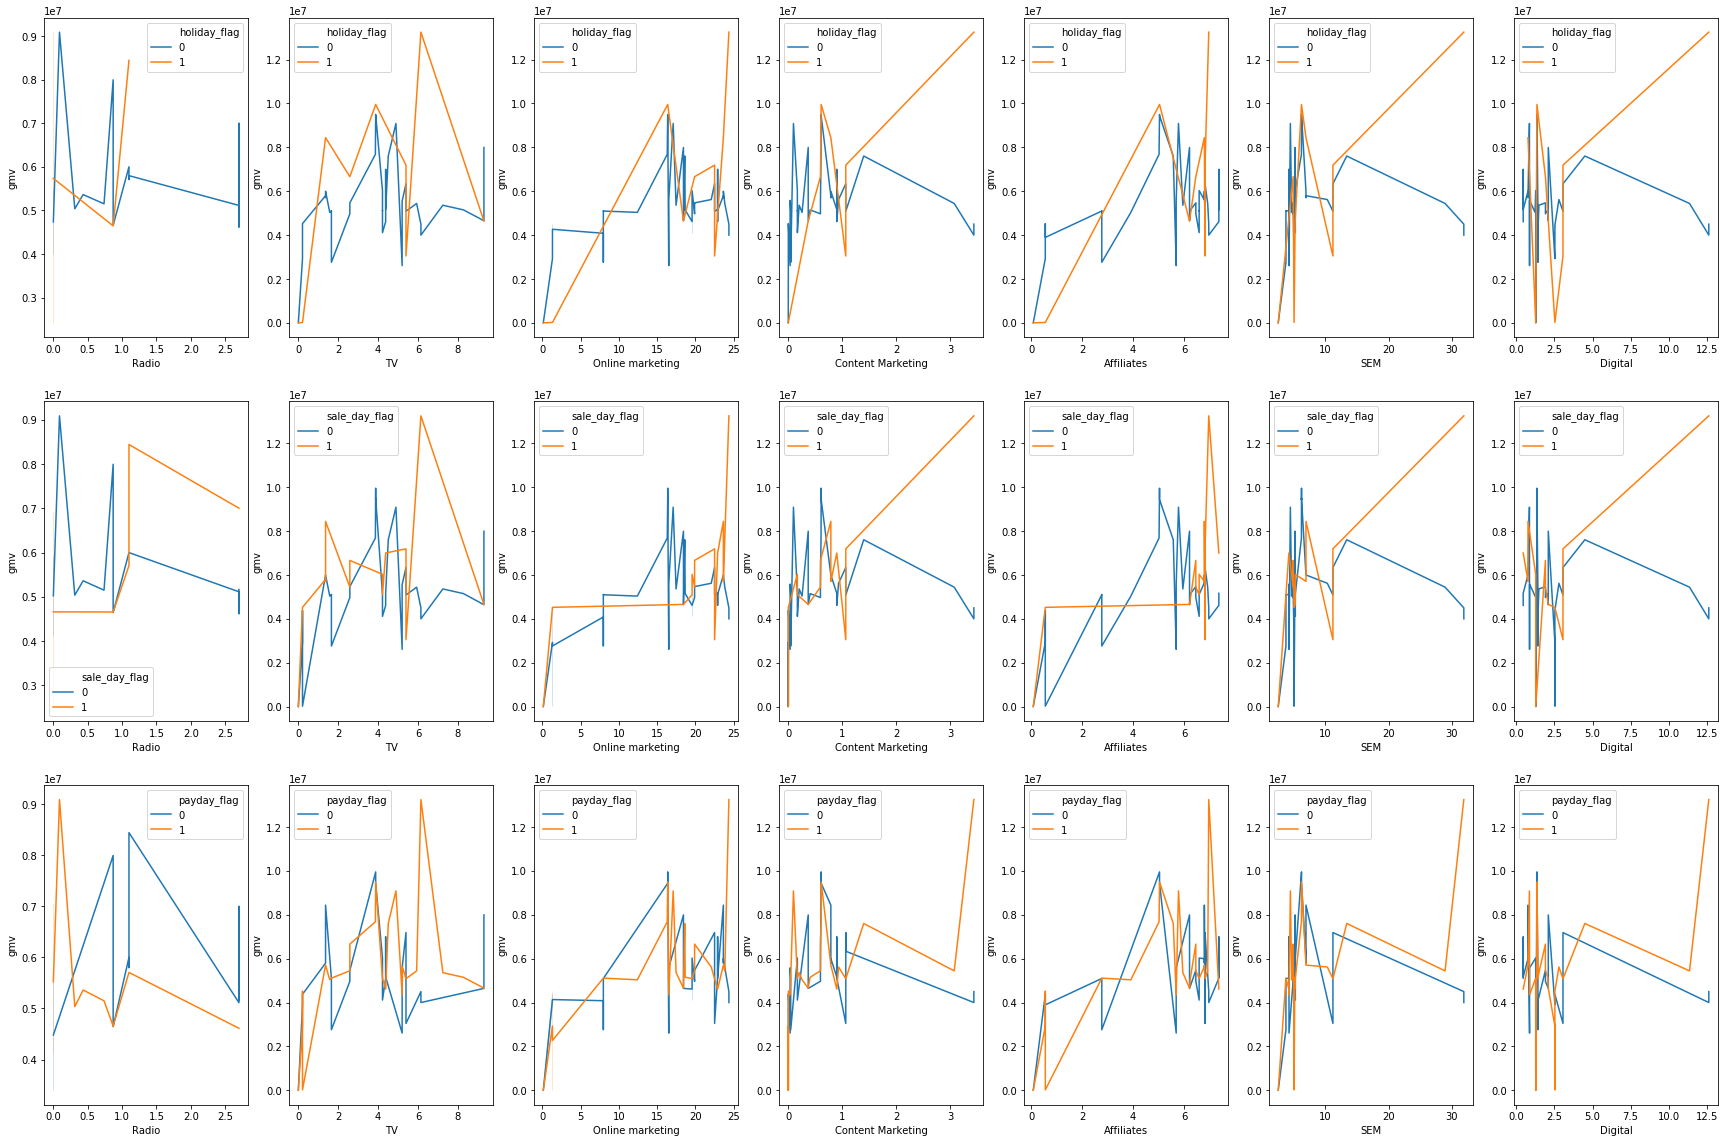

In [147]:
EDA_3(camera_df, 'gmv')

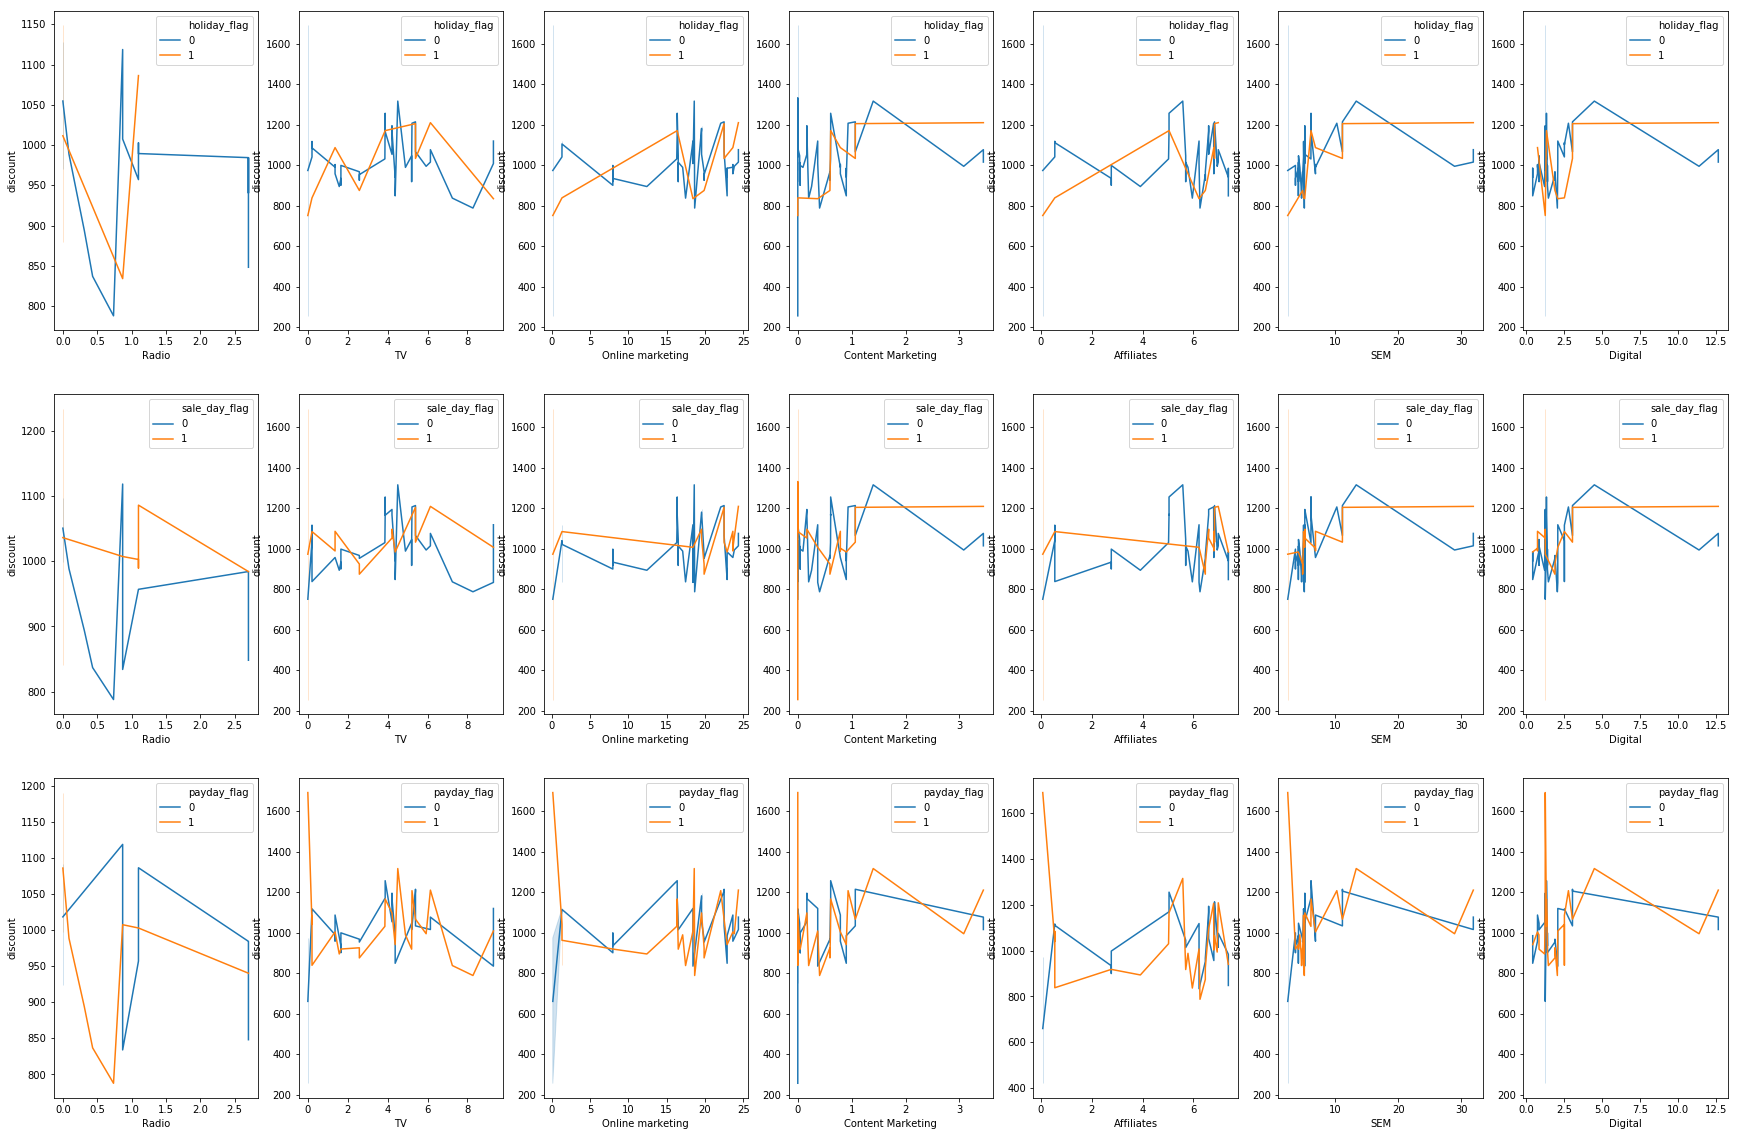

In [148]:
EDA_3(camera_df, 'discount')

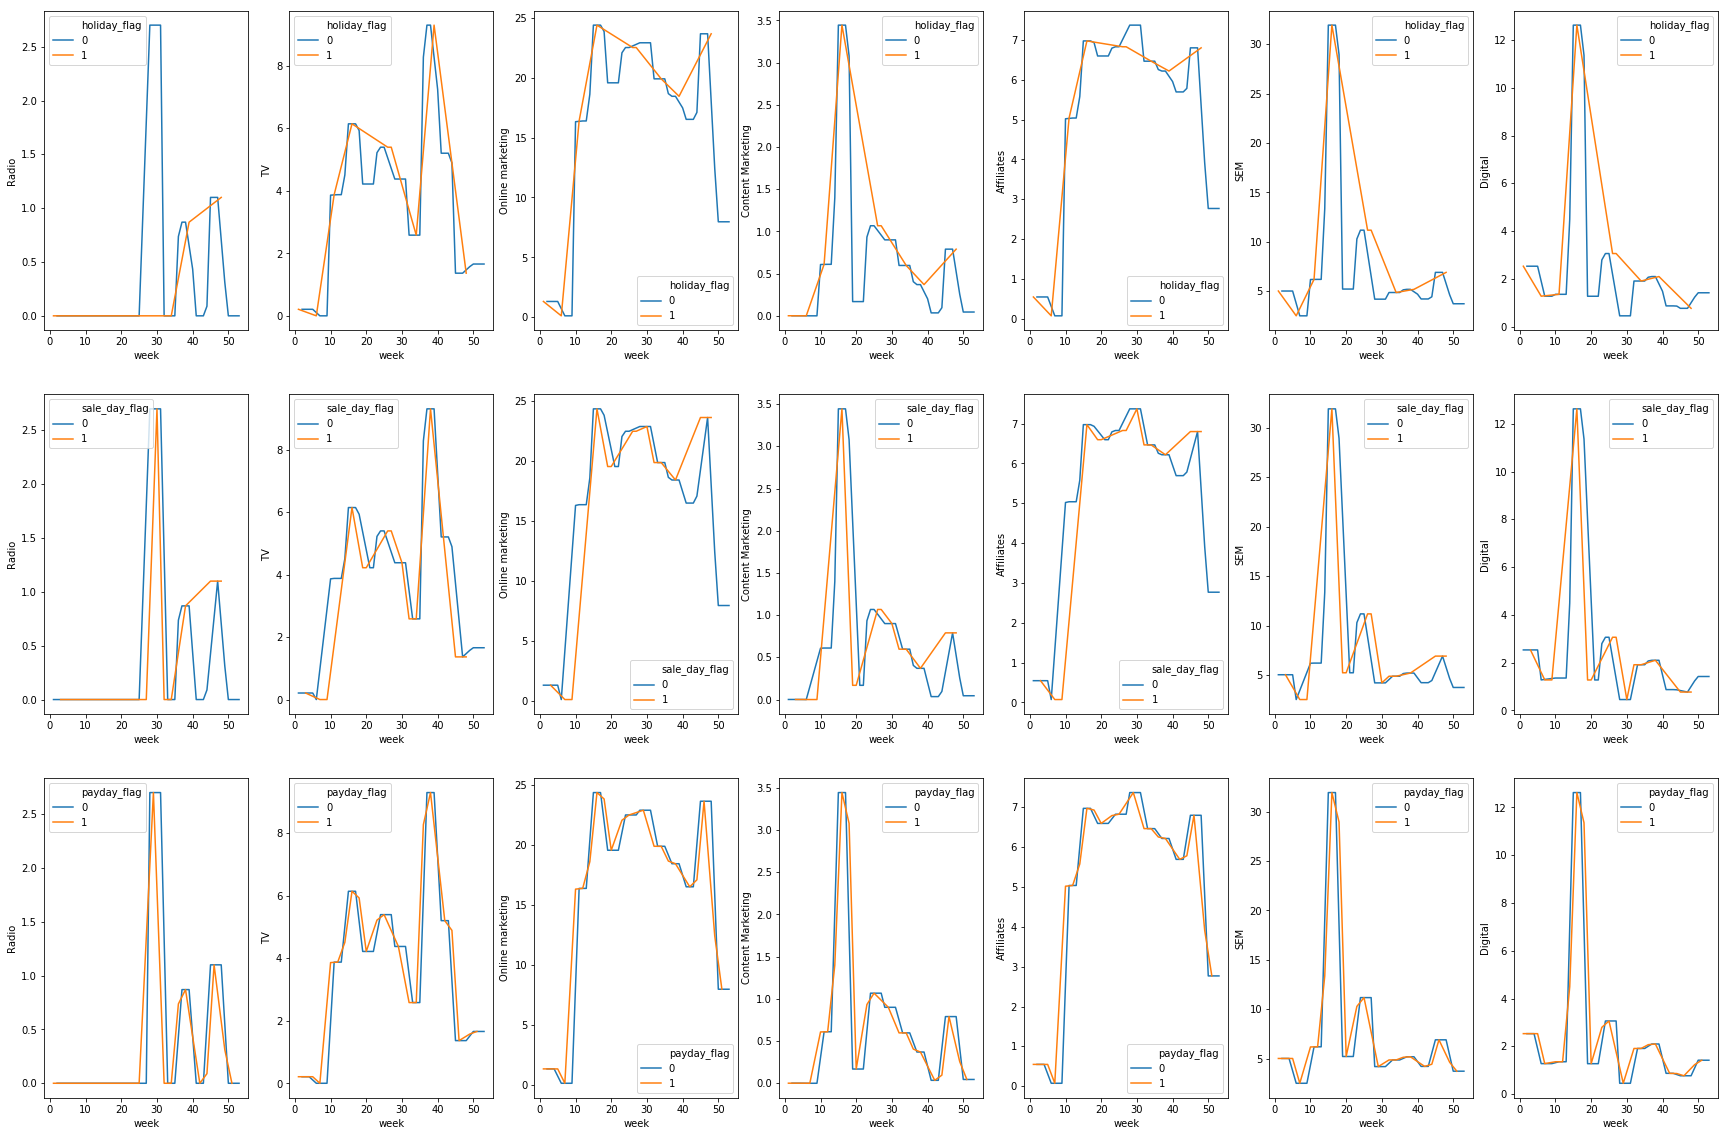

In [149]:
EDA_3(camera_df, 'week')

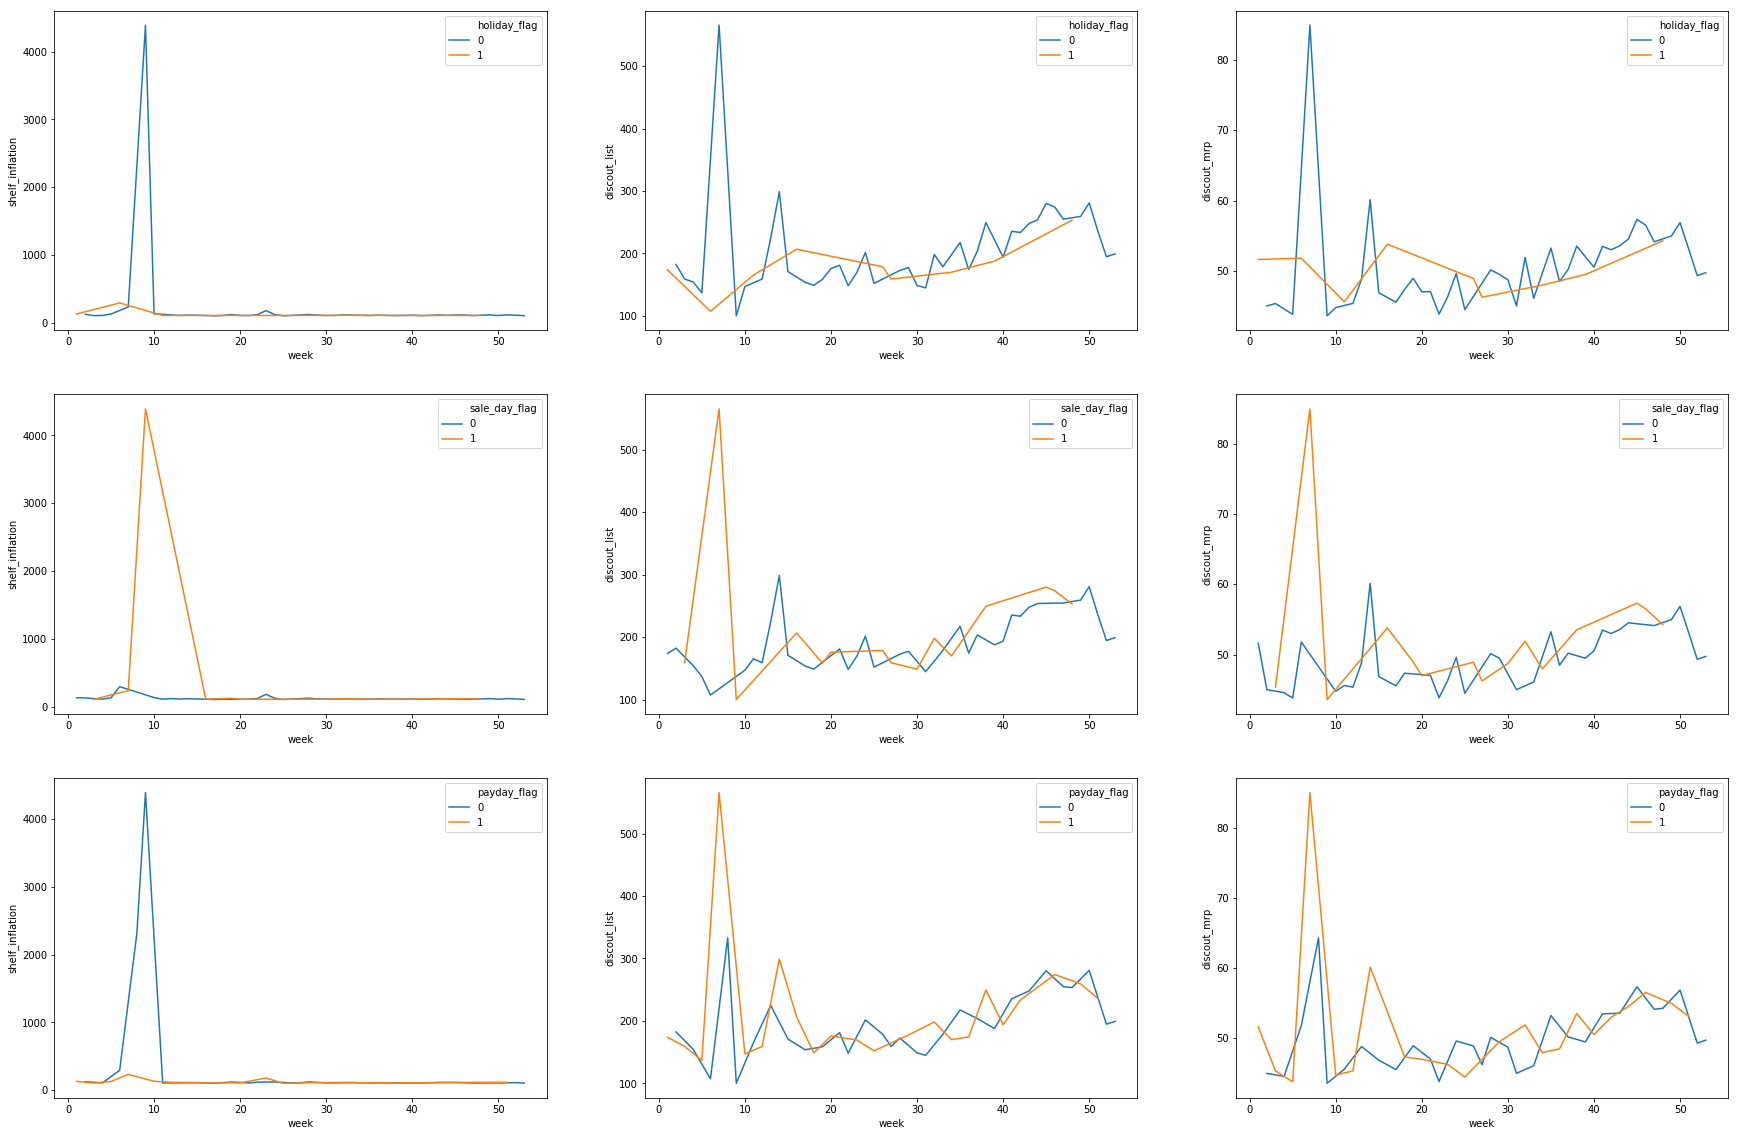

In [150]:
EDA_4(camera_df)

### **3. Home Audio**

In [151]:
home_df = pd.read_csv(r'C:/Users/abbasis/Desktop/Upgrad/home_audio_final.csv')
home_df.drop(['Unnamed: 0'],1,inplace=True)
home_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0  1.120440e+05    40.0  2.725000     187612.0                 3.375000   
1  4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
2  5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
3  4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
4  3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0   112044.00  1889.200000       1177.0  54.599588    0.0  ...      25.428571   
1  4659974.13  1294.022806       1177.0  54.599588    0.0  ...      24.833333   
2  5440775.00  1400.890472       1177.0  54.599588    0.0  ...      28.750000   
3  4700286.00  1418.424819       1177.0  54.599588    0.0  ...      29.750000   
4  3428591.00  1400.459615       1177.0  54.599588    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

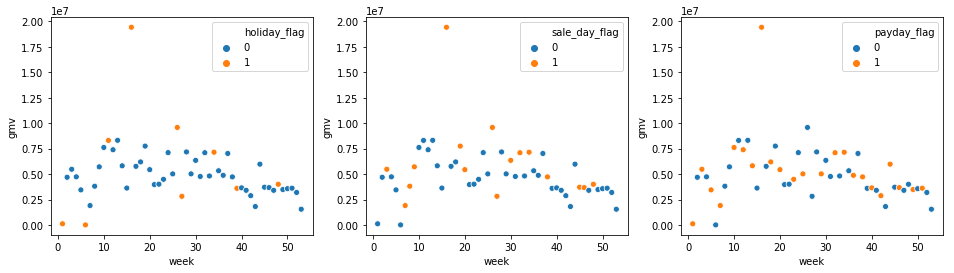

In [152]:
EDA_1(home_df)

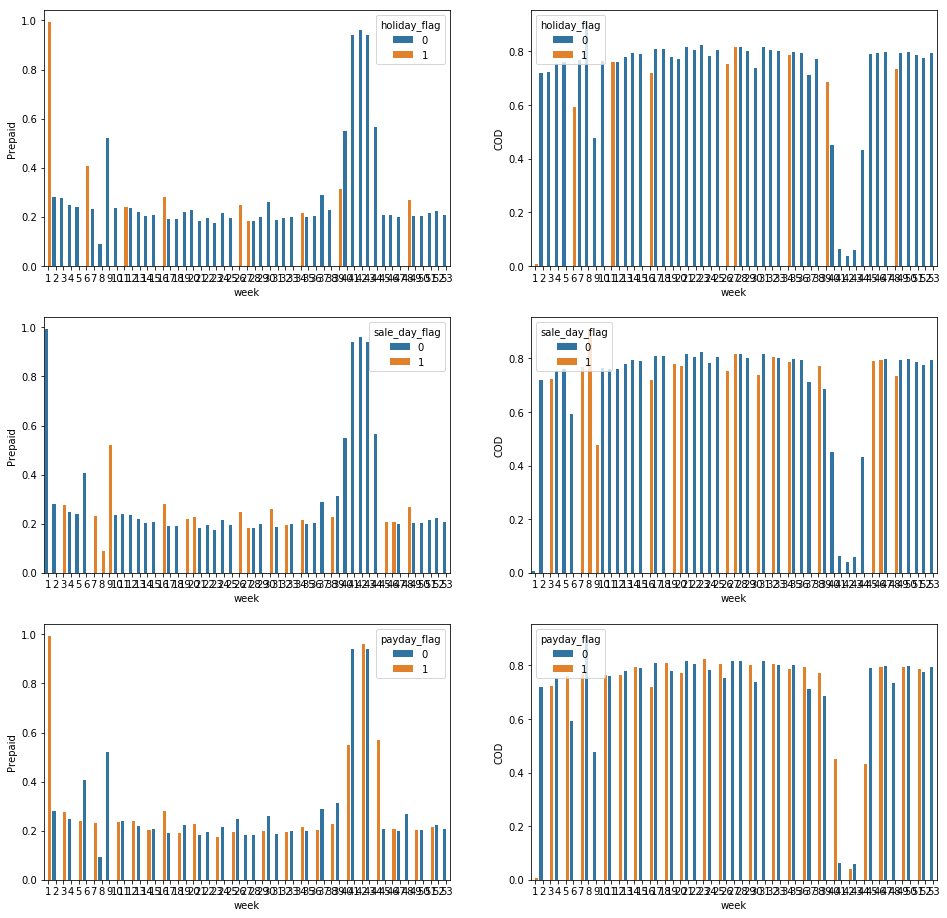

In [153]:
EDA_2(home_df)

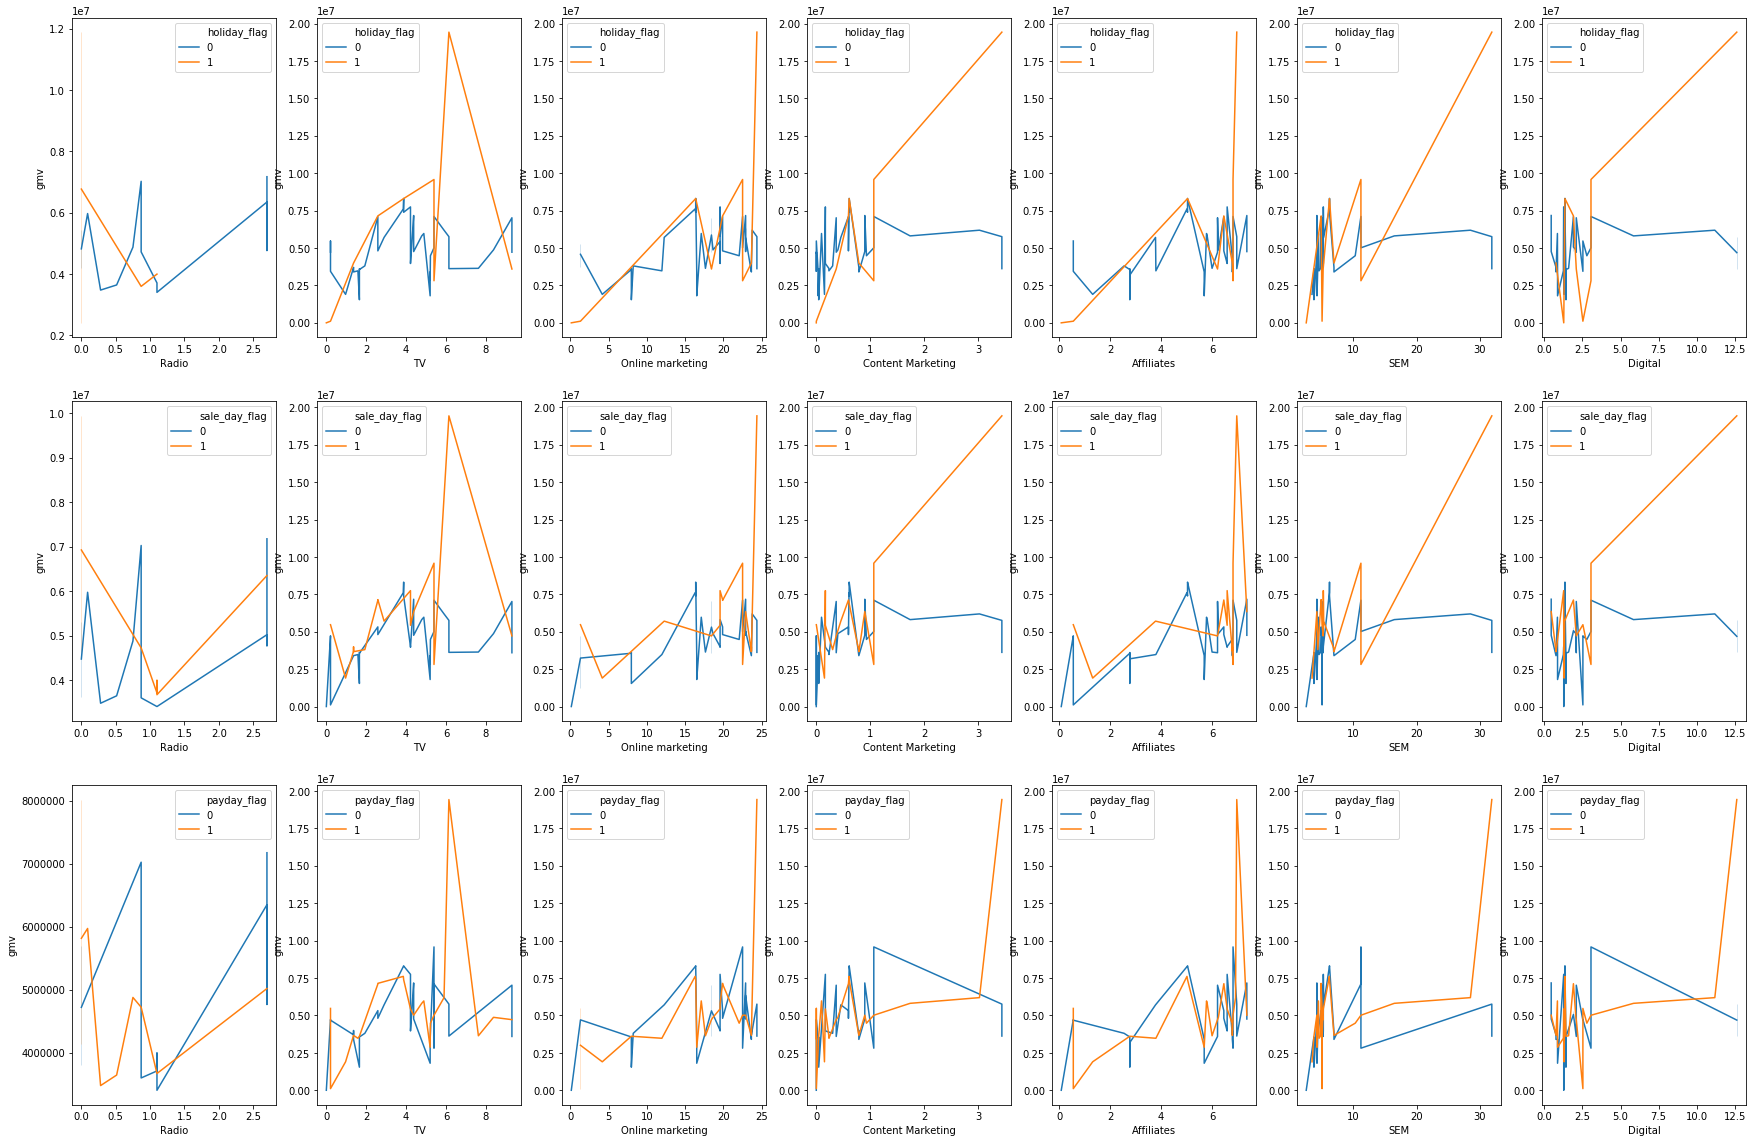

In [154]:
EDA_3(home_df, 'gmv')

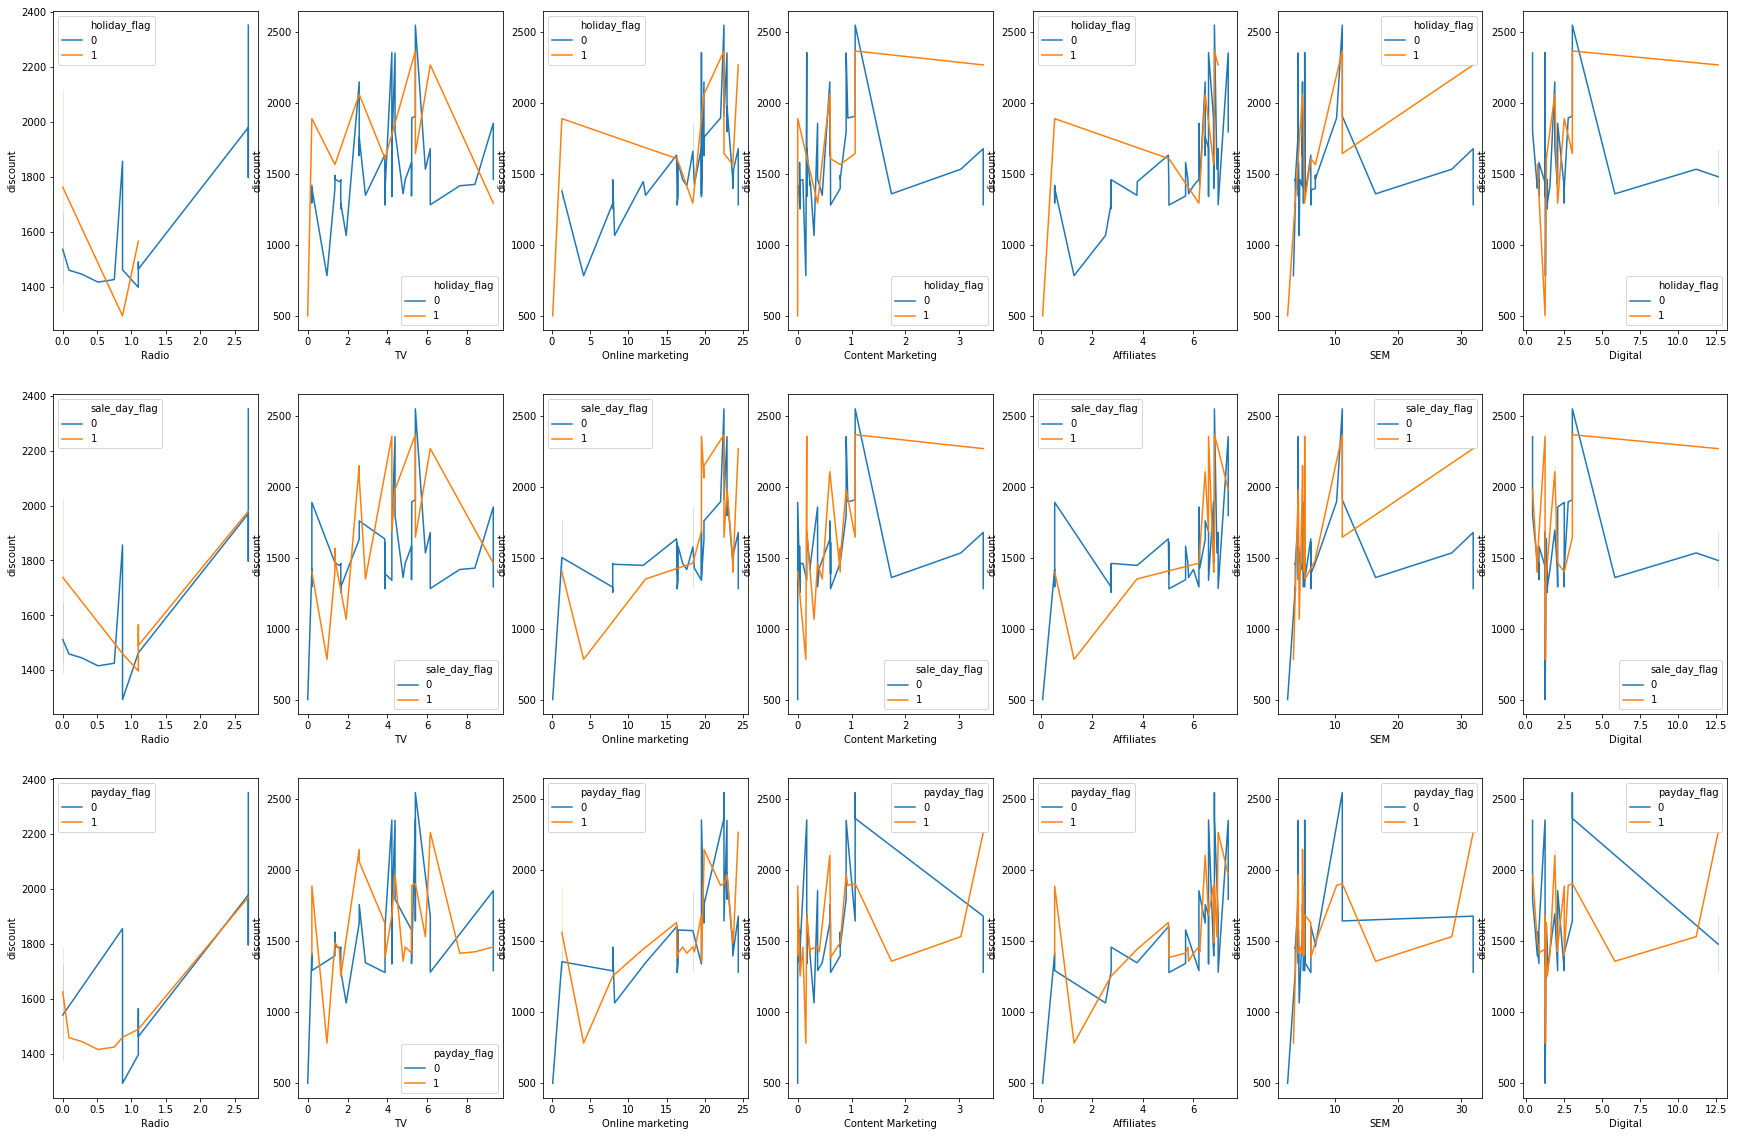

In [155]:
EDA_3(home_df, 'discount')

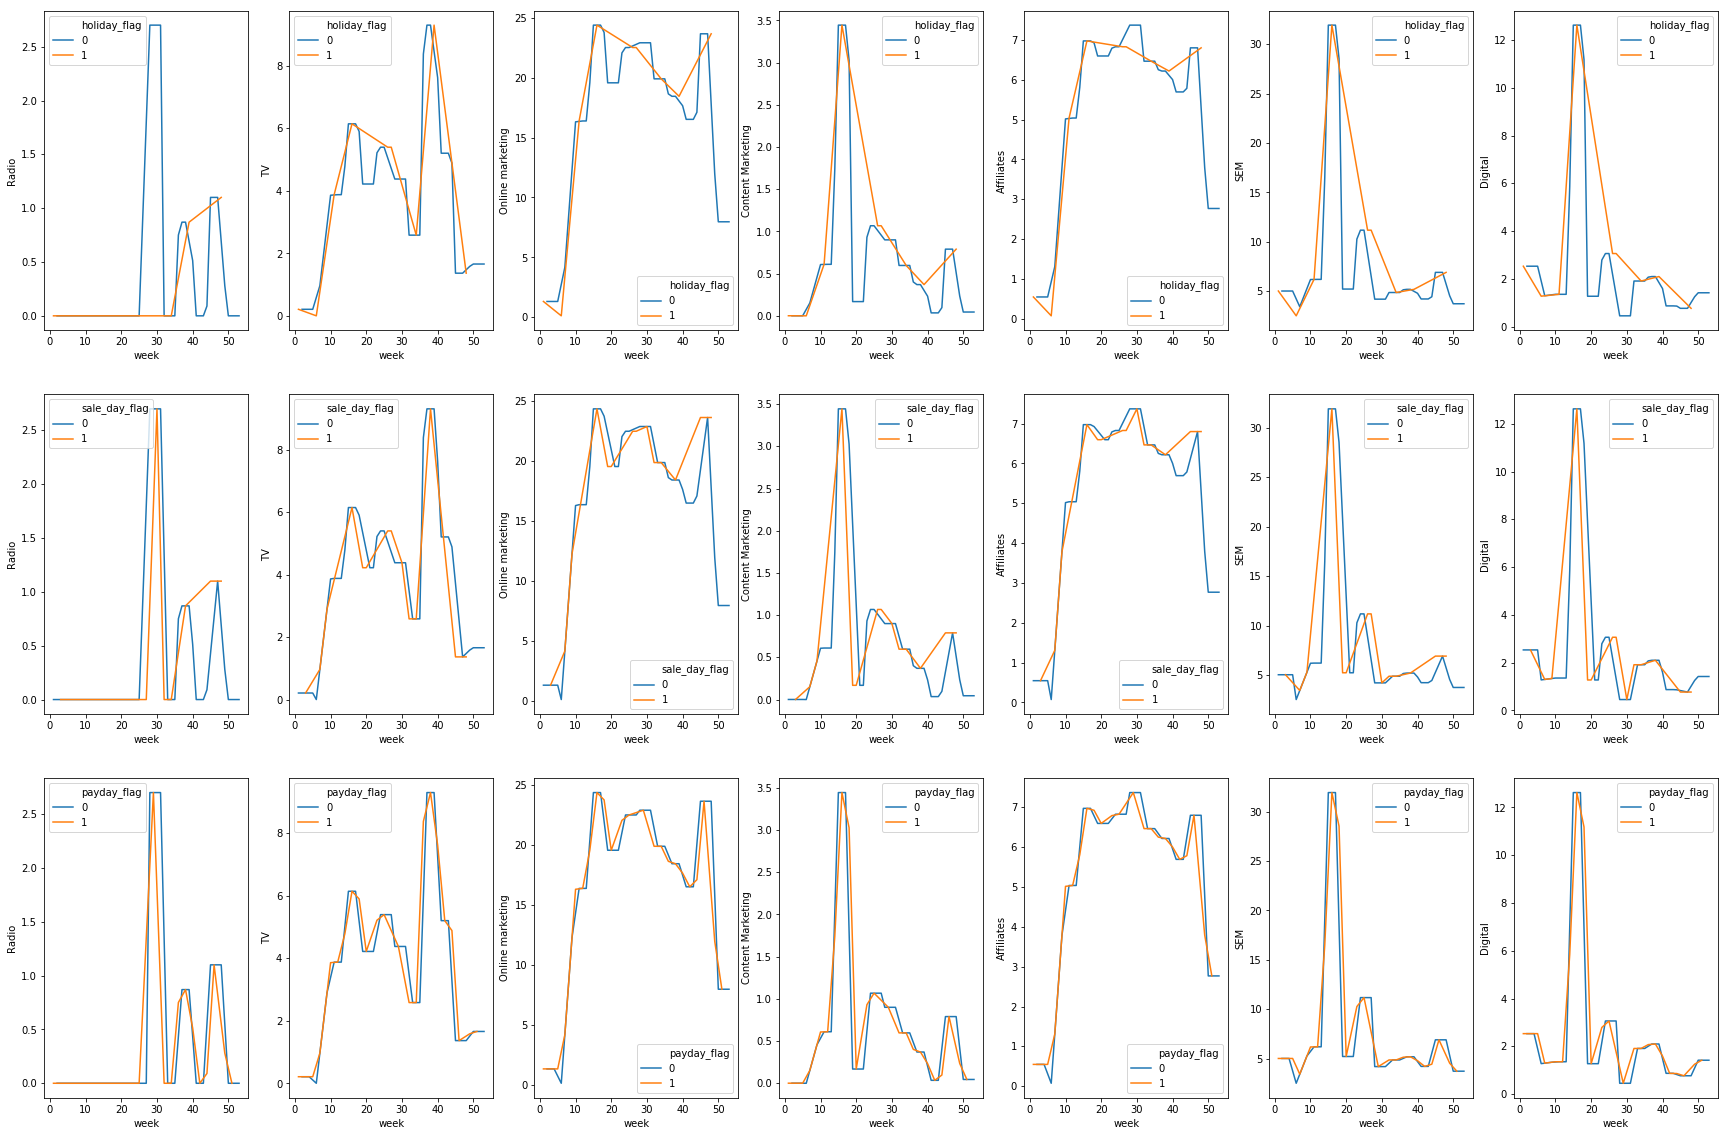

In [156]:
EDA_3(home_df, 'week')

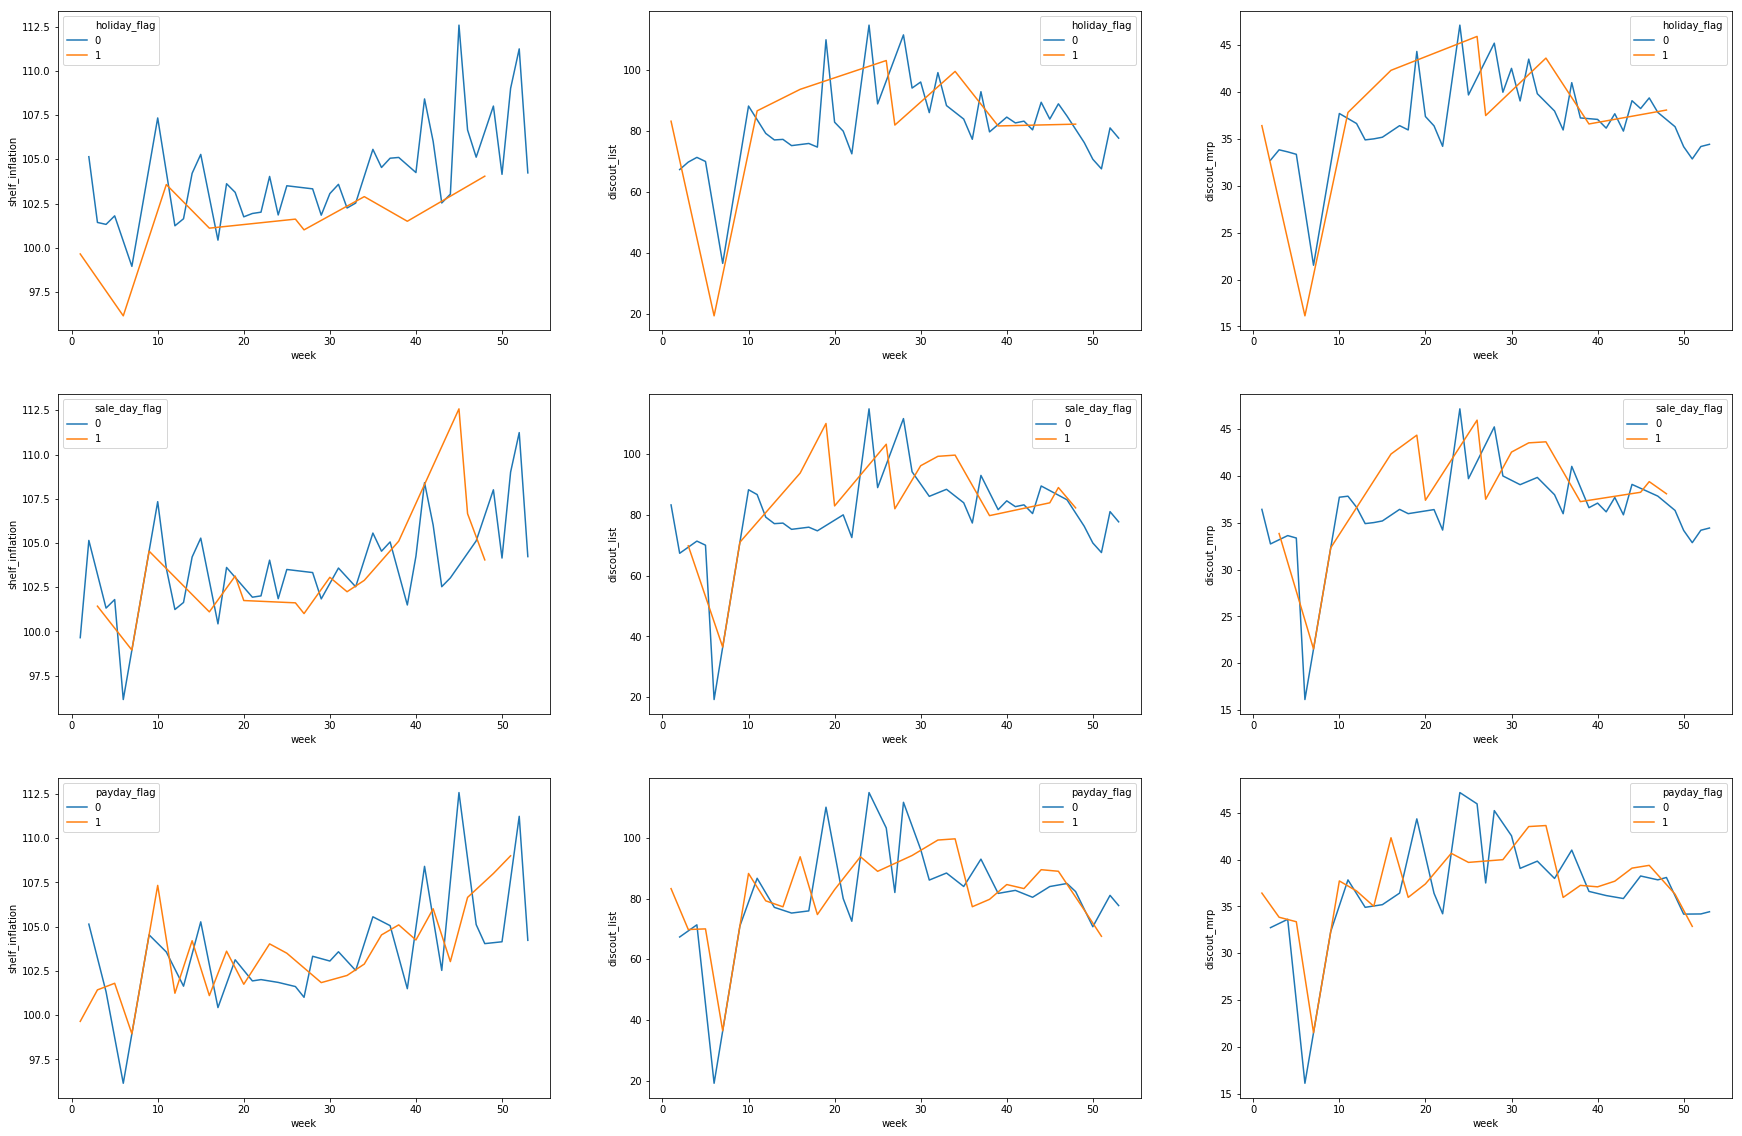

In [157]:
EDA_4(home_df)

# **Model Building**

## 1. Gaming Accessory

### **1(A): Linear Regression Model**

In [158]:
# Splitting the dataset into train & test dataset
gaming_train, gaming_test = train_test_split(gaming_df, train_size=0.7, test_size=0.3, random_state=100)

In [159]:
# Scaling the train dataset
scaler=MinMaxScaler()
gaming_train = pd.DataFrame(scaler.fit_transform(gaming_train), columns=gaming_train.columns)

# Splitting into X & Y features
y_lin_train = pd.DataFrame(gaming_train.pop('gmv'))
x_lin_train = gaming_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [160]:
# Feature Selection using RFE technique
linreg = LinearRegression()
linreg.fit(x_lin_train,y_lin_train)

rfe = RFE(linreg, 15)
rfe = rfe.fit(x_lin_train,y_lin_train)

# Keeping the features that are supported by RFE
x_lin_train_rfe = x_lin_train[x_lin_train.columns[rfe.support_]]

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


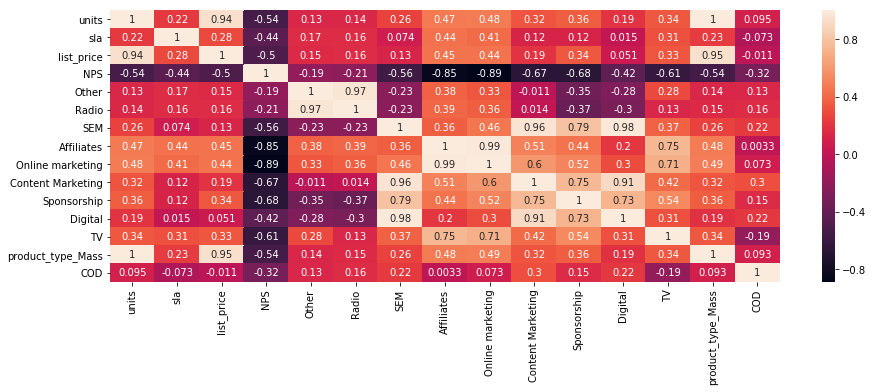

In [161]:
# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_lin_train_rfe.corr(), annot=True)
plt.show()

In [162]:
# Creating the linear regression model
x_lin_train_sm = sm.add_constant(x_lin_train_rfe)
lin_lm_1 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.642e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.98e-39
Time:                        20:55:33   Log-Likelihood:                 182.16
No. Observations:                  37   AIC:                            -332.3
Df Residuals:                      21   BIC:                            -306.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4240      0.39

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [163]:
x_lin_train_sm.drop(['Digital'], 1, inplace=True)
lin_lm_2 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.763e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.48e-41
Time:                        20:55:33   Log-Likelihood:                 181.34
No. Observations:                  37   AIC:                            -332.7
Df Residuals:                      22   BIC:                            -308.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0428      0.02

In [164]:
x_lin_train_sm.drop(['Affiliates'], 1, inplace=True)
lin_lm_3 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.909e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.76e-43
Time:                        20:55:33   Log-Likelihood:                 180.61
No. Observations:                  37   AIC:                            -333.2
Df Residuals:                      23   BIC:                            -310.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0208      0.01

In [166]:
x_lin_train_sm.drop(['product_type_Mass'], 1, inplace=True)
lin_lm_4 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.976e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.16e-45
Time:                        20:56:55   Log-Likelihood:                 178.98
No. Observations:                  37   AIC:                            -332.0
Df Residuals:                      24   BIC:                            -311.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0278      0.00

In [167]:
x_lin_train_sm.drop(['Sponsorship'], 1,inplace=True)
lin_lm_5 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.243e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.68e-47
Time:                        20:57:26   Log-Likelihood:                 178.96
No. Observations:                  37   AIC:                            -333.9
Df Residuals:                      25   BIC:                            -314.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0271      0.00

In [168]:
x_lin_train_sm.drop(['Online marketing'], 1,inplace=True)
lin_lm_6 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.476e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.50e-49
Time:                        20:57:46   Log-Likelihood:                 178.30
No. Observations:                  37   AIC:                            -334.6
Df Residuals:                      26   BIC:                            -316.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0272      0.00

In [169]:
x_lin_train_sm.drop(['units'], 1,inplace=True)
lin_lm_7 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.811e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.18e-51
Time:                        20:57:59   Log-Likelihood:                 178.00
No. Observations:                  37   AIC:                            -336.0
Df Residuals:                      27   BIC:                            -319.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0270      0.00

In [170]:
x_lin_train_sm.drop(['Content Marketing'], 1,inplace=True)
lin_lm_8 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.999e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.91e-53
Time:                        20:58:14   Log-Likelihood:                 176.35
No. Observations:                  37   AIC:                            -334.7
Df Residuals:                      28   BIC:                            -320.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.007      3.952      0.0

In [171]:
x_lin_train_sm.drop(['sla'], 1,inplace=True)
lin_lm_9 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.142e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.76e-54
Time:                        20:58:38   Log-Likelihood:                 174.09
No. Observations:                  37   AIC:                            -332.2
Df Residuals:                      29   BIC:                            -319.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0199      0.006      3.384      0.0

r2 score is 99.99%
RMSE is 0.0


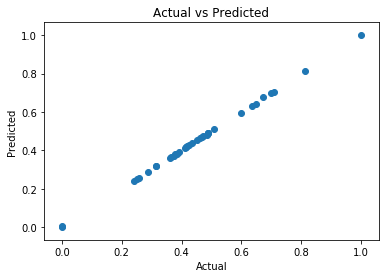

In [172]:
# Predicitng results on x_train
evaluate_model(lin_lm_9, x_lin_train_sm, y_lin_train)

*Remaining featues product_type_Mass , list_price & units are all significant features as thier p-value is less than 0.05. Therefore, accepting linear model 9 (lin_lm_9) as the final model.*

**Predicting on test data:**

In [173]:
# Scaling the test data
gaming_test = pd.DataFrame(scaler.transform(gaming_test), columns=gaming_test.columns)

# Splitting into X & Y features
y_lin_test = pd.DataFrame(gaming_test.pop('gmv'))
x_lin_test = gaming_test

# Keeping the significant features
x_lin_test_rfe=x_lin_test[x_lin_train_sm.iloc[:,1:].columns]

In [174]:
# Keeping the significant features
x_lin_test_rfe=x_lin_test[x_lin_train_sm.iloc[:,1:].columns]

r2 score is 99.95%
RMSE is 0.0


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


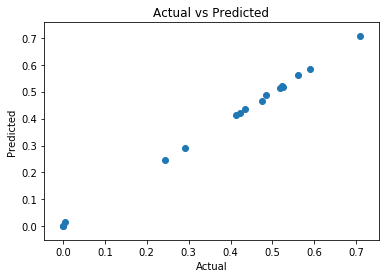

In [175]:
# Predicting the results
x_lin_test_sm = sm.add_constant(x_lin_test_rfe)
evaluate_model(lin_lm_9, x_lin_test_sm, y_lin_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.7186
0.9931
0.9599
0.2211
0.9906
0.9712
Avg. r2 score 0.8090833333333333

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  84.04 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  78.2 %


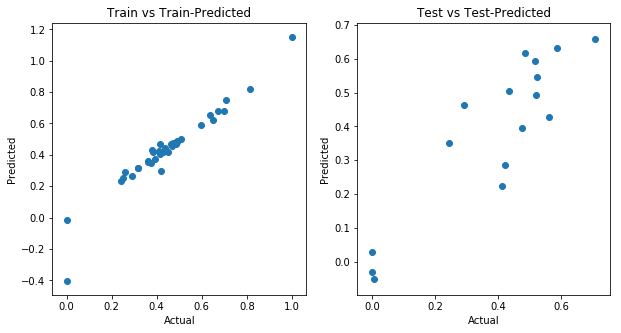

In [176]:
kfold(linreg,x_lin_train,y_lin_train,x_lin_test,y_lin_test)

**Elasticity Analysis**<br>
elasticity(in terms of var) = coefficient(var) * mean(df[var])/mean(df['gmv'])

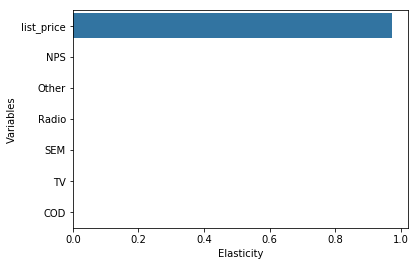

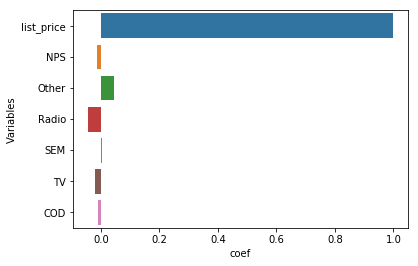

Variables      coef  Elasticity
0  list_price  0.996863      0.9732
1         NPS -0.013168     -0.0000
2       Other  0.044922      0.0000
3       Radio -0.043063     -0.0000
4         SEM  0.004330      0.0000
5          TV -0.019787     -0.0000
6         COD -0.008007     -0.0000

In [178]:
elax_df = elasticity(lin_lm_9,gaming_df)
sns.barplot(x='coef',y='Variables',data=elax_df)
plt.show()
elax_df

### **1(B): Multiplicative Model**

In [197]:
multiplicative_df = gaming_df.copy()

multiplicative_df=multiplicative_df.replace(0,0.01)
multiplicative_df.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
0  3.760900e+04     29  3.071429       103027                 2.964286   
1  2.738062e+06   3174  5.284337      5507913                 2.981377   
2  2.310927e+06   3006  5.209666      4984618                 2.545058   
3  2.632806e+06   2606  5.313898      5801106                 2.398962   
4  1.886221e+06   1882  5.553751      8973939                 2.956327   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0    37170.00  2352.035714  1177.000000  54.599588   0.01  ...      25.428571   
1  2632421.00   956.266046  1177.000000  54.599588   0.01  ...      24.833333   
2  2253957.36   992.245872  1177.000000  54.599588   0.01  ...      28.750000   
3  2553560.50  1296.943091  1177.000000  54.599588   0.01  ...      29.750000   
4  1804611.00  4014.181411  1177.016237  54.602605   0.01  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.010000            5.183333   
3      16.600000       23.060000            0.010000            5.060000   
4      17.500000       24.566667            0.010000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000             0.01           0.600000               0.01   
1         4.416667             0.01           4.416667               0.01   
2         1.400000             0.01           1.400000               0.01   
3         0.900000             0.01           0.900000               0.01   
4         4.633333             0.01           4.633333               0.01   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

In [198]:
multiplicative_df = np.log(multiplicative_df)
multiplicative_df.head()

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


gmv     units       sla  product_mrp  product_procurement_sla  \
0  10.534999  3.367296  1.122143    11.542746                 1.086636   
1  14.822761  8.062748  1.664747    15.521696                 1.092385   
2  14.653159  8.008366  1.650516    15.421867                 0.934153   
3  14.783561  7.865572  1.670326    15.573559                 0.875036   
4  14.450086  7.540090  1.714474    16.009835                 1.083948   

   list_price  discount  Stock Index       NPS    Other  ...  Max Temp (°C)  \
0   10.523257  7.763036     7.070724  4.000026 -4.60517  ...       3.235873   
1   14.783415  6.863036     7.070724  4.000026 -4.60517  ...       3.212187   
2   14.628198  6.899971     7.070724  4.000026 -4.60517  ...       3.358638   
3   14.752999  7.167765     7.070724  4.000026 -4.60517  ...       3.392829   
4   14.405856  8.297589     7.070738  4.000082 -4.60517  ...       3.452630   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0       2.639057        2.982068           -2.639057            0.587787   
1       2.730029        3.000720           -1.261131            0.868500   
2       2.866951        3.143434           -4.605170            1.645448   
3       2.809403        3.138100           -4.605170            1.621366   
4       2.862201        3.201391           -4.605170            1.882006   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0        -0.510826         -4.60517          -0.510826           -4.60517   
1         1.485385         -4.60517           1.485385           -4.60517   
2         0.336472         -4.60517           0.336472           -4.60517   
3        -0.105361         -4.60517          -0.105361           -4.60517   
4         1.533277         -4.60517           1.533277           -4.60517   

       week  
0  0.000000  
1  0.693147  
2  1.098612  
3  1.386294  
4  1.609438  

[5 rows x 39 columns]

In [199]:
multiplicative_df.isnull().sum()

gmv                         0
units                       0
sla                         0
product_mrp                 0
product_procurement_sla     0
list_price                  0
discount                    0
Stock Index                 0
NPS                         0
Other                       0
Radio                       0
SEM                         0
Affiliates                  0
Online marketing            0
Content Marketing           0
Sponsorship                 0
Digital                     0
TV                          0
shelf_inflation             0
discout_list                0
discout_mrp                 0
product_type_Mass           0
product_type_Mid_level      0
product_type_Premium        0
payday_flag                 0
sale_day_flag               0
holiday_flag                0
COD                         0
Prepaid                     0
Max Temp (°C)               1
Min Temp (°C)              14
Mean Temp (°C)              6
Heat Deg Days (°C)          0
Cool Deg D

In [200]:
multiplicative_df['Max Temp (°C)'] = multiplicative_df['Max Temp (°C)'].fillna(multiplicative_df['Max Temp (°C)'].mean())
multiplicative_df['Min Temp (°C)'] = multiplicative_df['Min Temp (°C)'].fillna(multiplicative_df['Min Temp (°C)'].mean())
multiplicative_df['Mean Temp (°C)'] = multiplicative_df['Mean Temp (°C)'].fillna(multiplicative_df['Mean Temp (°C)'].mean())
multiplicative_df.isnull().sum()

gmv                        0
units                      0
sla                        0
product_mrp                0
product_procurement_sla    0
list_price                 0
discount                   0
Stock Index                0
NPS                        0
Other                      0
Radio                      0
SEM                        0
Affiliates                 0
Online marketing           0
Content Marketing          0
Sponsorship                0
Digital                    0
TV                         0
shelf_inflation            0
discout_list               0
discout_mrp                0
product_type_Mass          0
product_type_Mid_level     0
product_type_Premium       0
payday_flag                0
sale_day_flag              0
holiday_flag               0
COD                        0
Prepaid                    0
Max Temp (°C)              0
Min Temp (°C)              0
Mean Temp (°C)             0
Heat Deg Days (°C)         0
Cool Deg Days (°C)         0
Total Rain (mm

In [201]:
multi_train, multi_test = train_test_split(multiplicative_df, train_size=0.7, test_size=0.3, random_state=100)

y_multi_train = pd.DataFrame(multi_train.pop('gmv'))
x_multi_train = multi_train

In [202]:
lr = LinearRegression()
lr.fit(x_multi_train,y_multi_train)

rfe = RFE(lr, 15)
rfe = rfe.fit(x_multi_train,y_multi_train)

# Keeping the features that are supported by RFE
x_multi_train_rfe = x_multi_train[x_multi_train.columns[rfe.support_]]

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


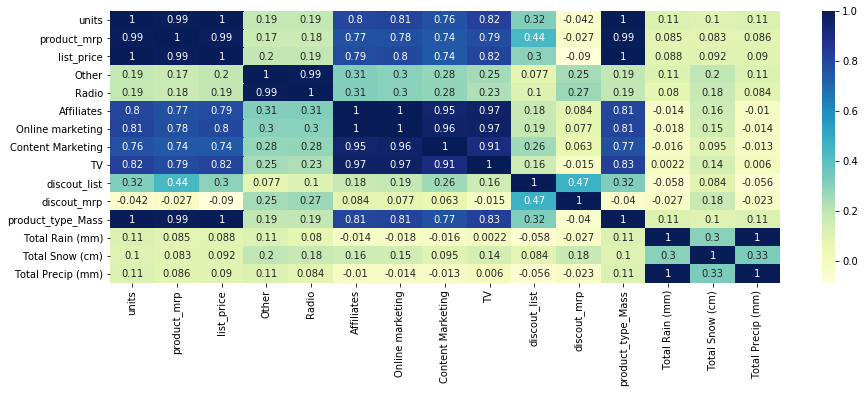

In [203]:
# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_multi_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [204]:
# Creating the linear regression model
x_multi_train_sm = sm.add_constant(x_multi_train_rfe)
mulit_lr1 = get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.388e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.55e-49
Time:                        21:03:33   Log-Likelihood:                 141.36
No. Observations:                  37   AIC:                            -250.7
Df Residuals:                      21   BIC:                            -224.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1693      0.20

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [205]:
x_multi_train_sm.drop(['Affiliates'], 1, inplace=True)
multi_lr2=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.557e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.36e-51
Time:                        21:03:47   Log-Likelihood:                 141.36
No. Observations:                  37   AIC:                            -252.7
Df Residuals:                      22   BIC:                            -228.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1695      0.19

In [206]:
x_multi_train_sm.drop(['Content Marketing'], 1, inplace=True)
multi_lr_3=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.753e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.18e-54
Time:                        21:04:08   Log-Likelihood:                 141.35
No. Observations:                  37   AIC:                            -254.7
Df Residuals:                      23   BIC:                            -232.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1603      0.17

In [207]:
x_multi_train_sm.drop(['Other'], 1, inplace=True)
multi_lr_4=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.890e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.22e-56
Time:                        21:04:30   Log-Likelihood:                 140.48
No. Observations:                  37   AIC:                            -255.0
Df Residuals:                      24   BIC:                            -234.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1428      0.17

In [208]:
x_multi_train_sm.drop(['Radio'], 1, inplace=True)
multi_lr_5=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.147e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.55e-59
Time:                        21:04:45   Log-Likelihood:                 140.47
No. Observations:                  37   AIC:                            -256.9
Df Residuals:                      25   BIC:                            -237.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1467      0.16

In [209]:
x_multi_train_sm.drop(['Online marketing'], 1, inplace=True)
multi_lr6=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.455e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.02e-62
Time:                        21:05:01   Log-Likelihood:                 140.46
No. Observations:                  37   AIC:                            -258.9
Df Residuals:                      26   BIC:                            -241.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1523      0.15

In [210]:
x_multi_train_sm.drop(['discout_mrp'], 1, inplace=True)
multi_lr7=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.791e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.11e-64
Time:                        21:05:16   Log-Likelihood:                 140.18
No. Observations:                  37   AIC:                            -260.4
Df Residuals:                      27   BIC:                            -244.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0606      0.05

In [211]:
x_multi_train_sm.drop(['discout_list'], 1, inplace=True)
multi_lr8=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.955e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.26e-67
Time:                        21:05:29   Log-Likelihood:                 138.39
No. Observations:                  37   AIC:                            -258.8
Df Residuals:                      28   BIC:                            -244.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0791      0.05

In [212]:
x_multi_train_sm.drop(['Total Rain (mm)'], 1, inplace=True)
multi_lr8=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.451e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.43e-69
Time:                        21:05:44   Log-Likelihood:                 138.14
No. Observations:                  37   AIC:                            -260.3
Df Residuals:                      29   BIC:                            -247.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0832      0.05

In [214]:
x_multi_train_sm.drop(['Total Precip (mm)'], 1, inplace=True)
multi_lr8=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.164e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.11e-72
Time:                        21:06:04   Log-Likelihood:                 138.14
No. Observations:                  37   AIC:                            -262.3
Df Residuals:                      30   BIC:                            -251.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0828      0.04

In [215]:
x_multi_train_sm.drop(['Total Snow (cm)'], 1, inplace=True)
multi_lr8=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.160e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.81e-75
Time:                        21:06:24   Log-Likelihood:                 138.12
No. Observations:                  37   AIC:                            -264.2
Df Residuals:                      31   BIC:                            -254.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0827      0.04

In [216]:
x_multi_train_sm.drop(['TV'], 1, inplace=True)
multi_lr8=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.494e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.79e-78
Time:                        21:06:49   Log-Likelihood:                 137.66
No. Observations:                  37   AIC:                            -265.3
Df Residuals:                      32   BIC:                            -257.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0833      0.04

In [217]:
x_multi_train_sm.drop(['product_mrp'], 1, inplace=True)
multi_lr8=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.667e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.57e-81
Time:                        21:07:07   Log-Likelihood:                 137.11
No. Observations:                  37   AIC:                            -266.2
Df Residuals:                      33   BIC:                            -259.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0627      0.04

r2 score is 100.0%
RMSE is 0.01


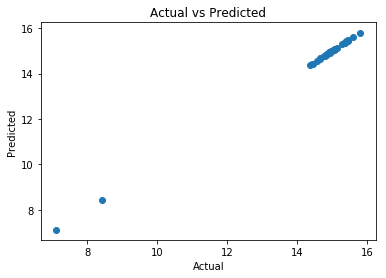

In [218]:
# Predicitng results on x_train
evaluate_model(multi_lr8, x_multi_train_sm, y_multi_train)

*Remaining featues product_type_Mass, units, list_price, Online marketing, Affiliates, sla, TV & Content Marketing are all significant features as thier p-value is less than 0.05. Therefore, accepting linear model 8 (multi_lm_8) as the final model.*

**Predicting On Test Data**

In [219]:
# Splitting into X & Y features
y_multi_test = pd.DataFrame(multi_test.pop('gmv'))
x_multi_test = multi_test

# Keeping the significant features
x_multi_test_rfe=x_multi_test[x_multi_train_sm.iloc[:,1:].columns]
x_multi_test_rfe.head()

units  list_price  product_type_Mass
25  8.686430   15.249258           8.647344
48  8.411833   15.210122           8.385261
52  7.477038   14.373108           7.445418
37  8.166216   14.914139           8.130648
6   1.386294    8.491875           1.386294

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


r2 score is 100.0%
RMSE is 0.01


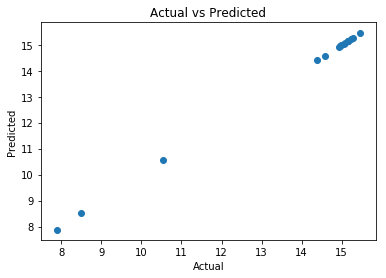

In [220]:
# Predicting the results
x_multi_test_sm = sm.add_constant(x_multi_test_rfe)
evaluate_model(multi_lr8, x_multi_test_sm, y_multi_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.8958
0.8408
0.9986
0.9946
0.963
0.6242
Avg. r2 score 0.8861666666666667

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  99.4 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  96.89999999999999 %


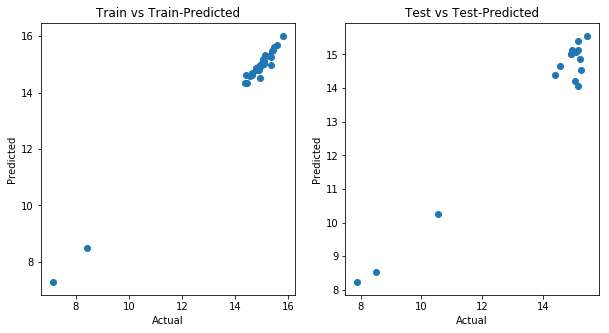

In [221]:
kfold(lr,x_multi_train,y_multi_train,x_multi_test,y_multi_test)

**Elasticity Analysis**<br>
*elasticity(in terms of var) = coefficient(var) * mean(df[var])/mean(df['gmv'])*

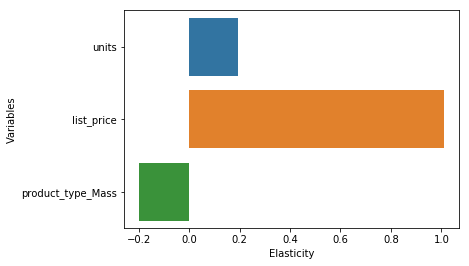

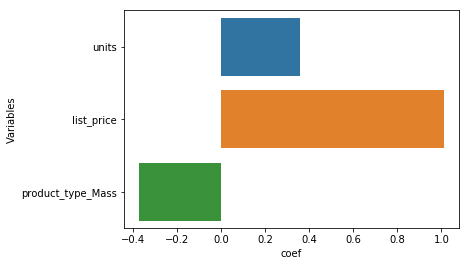

Variables      coef  Elasticity
0              units  0.360719      0.1926
1         list_price  1.010585      1.0090
2  product_type_Mass -0.370929     -0.1973

In [222]:
elax_df=elasticity(multi_lr8, multiplicative_df)
sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df


### **1(C) Koyck Model**

In [223]:
koyck_df = gaming_df.copy()
koyck_df.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
0  3.760900e+04     29  3.071429       103027                 2.964286   
1  2.738062e+06   3174  5.284337      5507913                 2.981377   
2  2.310927e+06   3006  5.209666      4984618                 2.545058   
3  2.632806e+06   2606  5.313898      5801106                 2.398962   
4  1.886221e+06   1882  5.553751      8973939                 2.956327   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0    37170.00  2352.035714  1177.000000  54.599588    0.0  ...      25.428571   
1  2632421.00   956.266046  1177.000000  54.599588    0.0  ...      24.833333   
2  2253957.36   992.245872  1177.000000  54.599588    0.0  ...      28.750000   
3  2553560.50  1296.943091  1177.000000  54.599588    0.0  ...      29.750000   
4  1804611.00  4014.181411  1177.016237  54.602605    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

**Creating Lag variable for Koyck Model**

In [224]:
koyck_df['gmv-1'] = koyck_df['gmv'].shift(-1)
koyck_df.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
0  3.760900e+04     29  3.071429       103027                 2.964286   
1  2.738062e+06   3174  5.284337      5507913                 2.981377   
2  2.310927e+06   3006  5.209666      4984618                 2.545058   
3  2.632806e+06   2606  5.313898      5801106                 2.398962   
4  1.886221e+06   1882  5.553751      8973939                 2.956327   

   list_price     discount  Stock Index        NPS  Other  ...  Min Temp (°C)  \
0    37170.00  2352.035714  1177.000000  54.599588    0.0  ...      14.000000   
1  2632421.00   956.266046  1177.000000  54.599588    0.0  ...      15.333333   
2  2253957.36   992.245872  1177.000000  54.599588    0.0  ...      17.583333   
3  2553560.50  1296.943091  1177.000000  54.599588    0.0  ...      16.600000   
4  1804611.00  4014.181411  1177.016237  54.602605    0.0  ...      17.500000   

   Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  Total Rain (mm)  \
0       19.728571            0.071429            1.800000         0.600000   
1       20.100000            0.283333            2.383333         4.416667   
2       23.183333            0.000000            5.183333         1.400000   
3       23.060000            0.000000            5.060000         0.900000   
4       24.566667            0.000000            6.566667         4.633333   

   Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  week         gmv-1  
0              0.0           0.600000                0.0     1  2.738062e+06  
1              0.0           4.416667                0.0     2  2.310927e+06  
2              0.0           1.400000                0.0     3  2.632806e+06  
3              0.0           0.900000                0.0     4  1.886221e+06  
4              0.0           4.633333                0.0     5  2.644000e+03  

[5 rows x 40 columns]

In [225]:
koyck_df = koyck_df.fillna(0)

In [226]:
koyck_train, koyck_test = train_test_split(koyck_df, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the dataset
koyck_scaler = MinMaxScaler()
koyck_train = pd.DataFrame(koyck_scaler.fit_transform(koyck_train), columns=koyck_train.columns)

y_koyck_train = pd.DataFrame(koyck_train.pop('gmv'))
x_koyck_train = koyck_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [227]:
koyck_lr = LinearRegression()
koyck_lr.fit(x_koyck_train,y_koyck_train)

rfe = RFE(koyck_lr, 15)
rfe = rfe.fit(x_koyck_train,y_koyck_train)

# Keeping the features that are supported by RFE
x_koyck_train_rfe = x_koyck_train[x_koyck_train.columns[rfe.support_]]

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


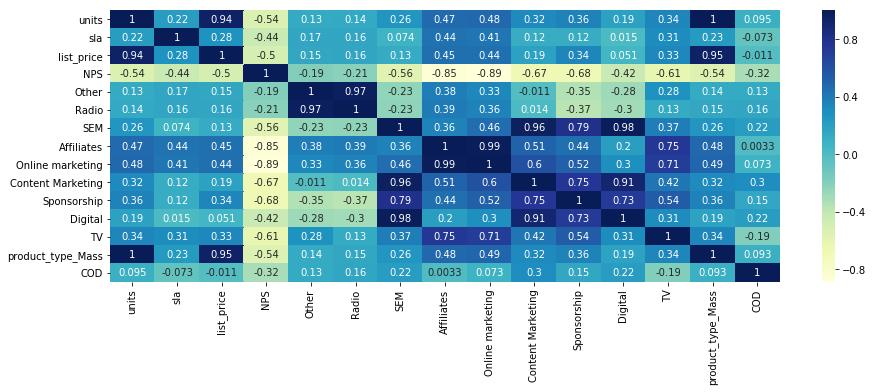

In [228]:
# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_koyck_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [229]:
# Creating the linear regression model
x_koyck_train_sm = sm.add_constant(x_koyck_train_rfe)
koyck_lr1 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.642e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.98e-39
Time:                        21:07:47   Log-Likelihood:                 182.16
No. Observations:                  37   AIC:                            -332.3
Df Residuals:                      21   BIC:                            -306.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4240      0.39

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [230]:
x_koyck_train_sm.drop(['Digital'], 1, inplace=True)
koyck_lr2 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.763e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.48e-41
Time:                        21:08:02   Log-Likelihood:                 181.34
No. Observations:                  37   AIC:                            -332.7
Df Residuals:                      22   BIC:                            -308.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0428      0.02

In [231]:
x_koyck_train_sm.drop(['Affiliates'],1,inplace=True)
koyck_lr3 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.909e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.76e-43
Time:                        21:08:03   Log-Likelihood:                 180.61
No. Observations:                  37   AIC:                            -333.2
Df Residuals:                      23   BIC:                            -310.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0208      0.01

In [234]:
x_koyck_train_sm.drop(['Content Marketing'],1,inplace=True)
koyck_lr4 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.120e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.07e-45
Time:                        21:08:20   Log-Likelihood:                 180.29
No. Observations:                  37   AIC:                            -334.6
Df Residuals:                      24   BIC:                            -313.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0232      0.00

In [235]:
x_koyck_train_sm.drop(['Online marketing'],1,inplace=True)
koyck_lr5 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.394e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.07e-47
Time:                        21:08:34   Log-Likelihood:                 180.17
No. Observations:                  37   AIC:                            -336.3
Df Residuals:                      25   BIC:                            -317.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0238      0.00

In [236]:
x_koyck_train_sm.drop(['product_type_Mass'],1,inplace=True)
koyck_lr6 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.508e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.79e-49
Time:                        21:08:54   Log-Likelihood:                 178.54
No. Observations:                  37   AIC:                            -335.1
Df Residuals:                      26   BIC:                            -317.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0309      0.007      4.286      

In [237]:
x_koyck_train_sm.drop(['units'],1,inplace=True)
koyck_lr7 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.636e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.59e-51
Time:                        21:09:16   Log-Likelihood:                 176.81
No. Observations:                  37   AIC:                            -333.6
Df Residuals:                      27   BIC:                            -317.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0295      0.007      4.012      

In [238]:
x_koyck_train_sm.drop(['Sponsorship'],1,inplace=True)
koyck_lr8 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.999e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.91e-53
Time:                        21:09:39   Log-Likelihood:                 176.35
No. Observations:                  37   AIC:                            -334.7
Df Residuals:                      28   BIC:                            -320.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.007      3.952      0.0

In [239]:
x_koyck_train_sm.drop(['SEM'],1,inplace=True)
koyck_lr9 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.127e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.89e-54
Time:                        21:09:49   Log-Likelihood:                 174.00
No. Observations:                  37   AIC:                            -332.0
Df Residuals:                      29   BIC:                            -319.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0286      0.008      3.782      0.0

In [240]:
x_koyck_train_sm.drop(['sla'],1,inplace=True)
koyck_lr10 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.296e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.04e-56
Time:                        21:10:02   Log-Likelihood:                 171.50
No. Observations:                  37   AIC:                            -329.0
Df Residuals:                      30   BIC:                            -317.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.006      3.046      0.0

r2 score is 99.98%
RMSE is 0.0


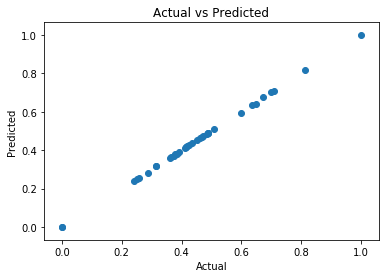

In [242]:
# Predicitng results on x_train
evaluate_model(koyck_lr10, x_koyck_train_sm, y_koyck_train)

*Remaining featues product_type_Mass, units, list_price are all significant features as thier p-value is less than 0.05. Therefore, accepting linear model 13 (koyck_lr8) as the final model.*

In [243]:
#Scaling the test data
koyck_test = pd.DataFrame(koyck_scaler.transform(koyck_test), columns=koyck_test.columns)

# Splitting into X & Y features
y_koyck_test = pd.DataFrame(koyck_test.pop('gmv'))
x_koyck_test = koyck_test

# Keeping the significant features
x_koyck_test_rfe=x_koyck_test[x_koyck_train_sm.iloc[:,1:].columns]
x_koyck_test_rfe.head()

list_price       NPS     Other     Radio            TV       COD
0    0.584958  0.089912  0.000000  0.000000  5.800859e-01  0.821918
1    0.562500  0.334218  0.052093  0.115286  1.693051e-01  0.869672
2    0.243465  0.392483  0.000000  0.000000  1.782179e-01  0.866904
3    0.418343  0.296507  0.588614  0.322222  1.000000e+00  0.843021
4    0.000506  1.000000  0.000000  0.000000  1.084202e-19  0.839330

r2 score is 99.96%
RMSE is 0.0


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


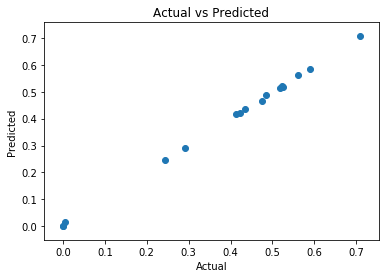

In [244]:
# Predicting the results
x_koyck_test_sm = sm.add_constant(x_koyck_test_rfe)
evaluate_model(koyck_lr10, x_koyck_test_sm, y_koyck_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.8238
0.9944
0.9555
0.9174
0.9805
0.9852
Avg. r2 score 0.9428

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  95.97 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  79.7 %


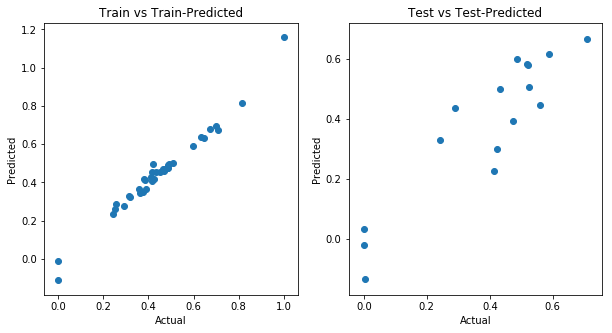

In [245]:
kfold(koyck_lr,x_koyck_train,y_koyck_train,x_koyck_test,y_koyck_test)

**Elasticity Analysis**

*elasticity(in terms of var) = coefficient(var) * mean(df[var])/mean(df['gmv'])*

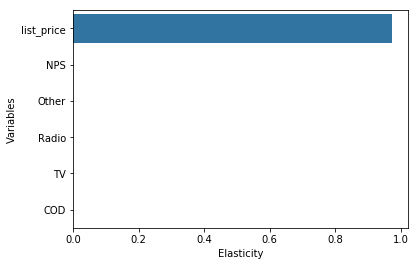

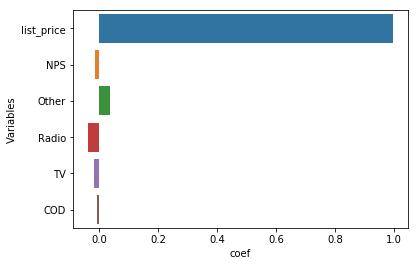

Variables      coef  Elasticity
0  list_price  0.996063      0.9724
1         NPS -0.013692     -0.0000
2       Other  0.038016      0.0000
3       Radio -0.037666     -0.0000
4          TV -0.016310     -0.0000
5         COD -0.006287     -0.0000

In [246]:
elax_df=elasticity(koyck_lr10, koyck_df)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

**1(D): Distributed Lag Model**

In [247]:
df_with_lag = gaming_df.copy()
df_with_lag.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
0  3.760900e+04     29  3.071429       103027                 2.964286   
1  2.738062e+06   3174  5.284337      5507913                 2.981377   
2  2.310927e+06   3006  5.209666      4984618                 2.545058   
3  2.632806e+06   2606  5.313898      5801106                 2.398962   
4  1.886221e+06   1882  5.553751      8973939                 2.956327   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0    37170.00  2352.035714  1177.000000  54.599588    0.0  ...      25.428571   
1  2632421.00   956.266046  1177.000000  54.599588    0.0  ...      24.833333   
2  2253957.36   992.245872  1177.000000  54.599588    0.0  ...      28.750000   
3  2553560.50  1296.943091  1177.000000  54.599588    0.0  ...      29.750000   
4  1804611.00  4014.181411  1177.016237  54.602605    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

In [248]:
# Creating lag variables
create_lag_var(df_with_lag)

df_with_lag['gmv-1'] = df_with_lag['gmv'].shift(-1)
df_with_lag['gmv-2'] = df_with_lag['gmv'].shift(-2)
df_with_lag['gmv-3'] = df_with_lag['gmv'].shift(-3)

df_with_lag = df_with_lag.fillna(0)

df_with_lag.head()

gmv  units       sla  product_mrp  product_procurement_sla  \
0  3.760900e+04     29  3.071429       103027                 2.964286   
1  2.738062e+06   3174  5.284337      5507913                 2.981377   
2  2.310927e+06   3006  5.209666      4984618                 2.545058   
3  2.632806e+06   2606  5.313898      5801106                 2.398962   
4  1.886221e+06   1882  5.553751      8973939                 2.956327   

   list_price     discount  Stock Index        NPS  Other  ...       LP-3  \
0    37170.00  2352.035714  1177.000000  54.599588    0.0  ...  2553560.5   
1  2632421.00   956.266046  1177.000000  54.599588    0.0  ...  1804611.0   
2  2253957.36   992.245872  1177.000000  54.599588    0.0  ...     2644.0   
3  2553560.50  1296.943091  1177.000000  54.599588    0.0  ...     4875.0   
4  1804611.00  4014.181411  1177.016237  54.602605    0.0  ...     1246.0   

         Dis-1        Dis-2        Dis-3      NPS-1      NPS-2      NPS-3  \
0   956.266046   992.245872  1296.943091  54.599588  54.599588  54.599588   
1   992.245872  1296.943091  4014.181411  54.599588  54.599588  54.602605   
2  1296.943091  4014.181411  1095.800000  54.599588  54.602605  59.987101   
3  4014.181411  1095.800000  1364.500000  54.602605  59.987101  59.987101   
4  1095.800000  1364.500000   275.000000  59.987101  59.987101  59.987101   

          gmv-1         gmv-2      gmv-3  
0  2.738062e+06  2.310927e+06  2632805.5  
1  2.310927e+06  2.632806e+06  1886221.0  
2  2.632806e+06  1.886221e+06     2644.0  
3  1.886221e+06  2.644000e+03     4875.0  
4  2.644000e+03  4.875000e+03     1246.0  

[5 rows x 51 columns]

In [249]:
df_with_lag_train, df_with_lag_test = train_test_split(df_with_lag, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the dataset
distributed_scaler = MinMaxScaler()
df_with_lag_train = pd.DataFrame(distributed_scaler.fit_transform(df_with_lag_train),columns=df_with_lag_train.columns)

y_df_with_lag_train = pd.DataFrame(df_with_lag_train.pop('gmv'))
x_df_with_lag_train = df_with_lag_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [250]:
distributed_lr = LinearRegression()
distributed_lr.fit(x_df_with_lag_train,y_df_with_lag_train)

rfe = RFE(distributed_lr, 15)
rfe = rfe.fit(x_df_with_lag_train,y_df_with_lag_train)

# Keeping the features that are supported by RFE
x_df_with_lag_train_rfe = x_df_with_lag_train[x_df_with_lag_train.columns[rfe.support_]]

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


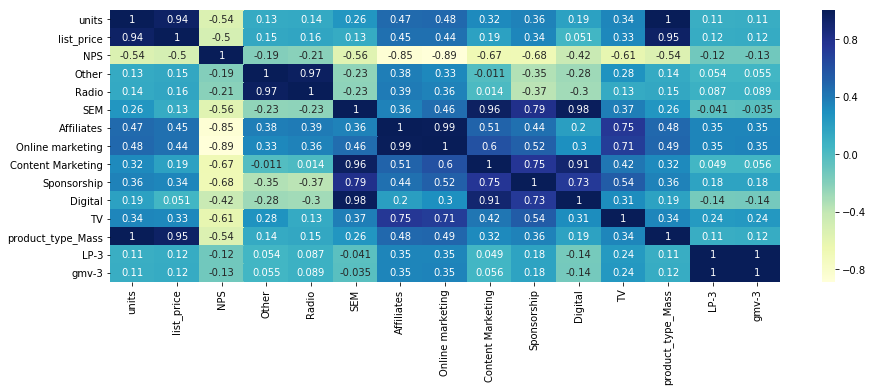

In [251]:
# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_df_with_lag_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [252]:
# Creating the linear regression model
x_df_with_lag_train_sm = sm.add_constant(x_df_with_lag_train_rfe)

distributed_lr1 = get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.289e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.79e-38
Time:                        21:11:14   Log-Likelihood:                 177.68
No. Observations:                  37   AIC:                            -323.4
Df Residuals:                      21   BIC:                            -297.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2092      0.42

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [253]:
x_df_with_lag_train_sm.drop(['LP-3'], 1, inplace=True)
distributed_lr2=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.422e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.71e-40
Time:                        21:11:24   Log-Likelihood:                 177.36
No. Observations:                  37   AIC:                            -324.7
Df Residuals:                      22   BIC:                            -300.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2012      0.42

In [254]:
x_df_with_lag_train_sm.drop(['gmv-3'], 1, inplace=True)
distributed_lr3=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.598e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.90e-42
Time:                        21:11:25   Log-Likelihood:                 177.33
No. Observations:                  37   AIC:                            -326.7
Df Residuals:                      23   BIC:                            -304.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2136      0.40

In [255]:
x_df_with_lag_train_sm.drop(['Content Marketing'], 1, inplace=True)
distributed_lr4=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.787e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.39e-44
Time:                        21:11:27   Log-Likelihood:                 177.12
No. Observations:                  37   AIC:                            -328.2
Df Residuals:                      24   BIC:                            -307.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0066      0.00

In [256]:
x_df_with_lag_train_sm.drop(['Sponsorship'], 1, inplace=True)
distributed_lr5=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.005e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.90e-46
Time:                        21:11:28   Log-Likelihood:                 176.89
No. Observations:                  37   AIC:                            -329.8
Df Residuals:                      25   BIC:                            -310.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0049      0.00

In [257]:
x_df_with_lag_train_sm.drop(['Other'], 1, inplace=True)
distributed_lr6=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.281e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.30e-48
Time:                        21:11:31   Log-Likelihood:                 176.78
No. Observations:                  37   AIC:                            -331.6
Df Residuals:                      26   BIC:                            -313.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0040      0.00

In [259]:
x_df_with_lag_train_sm.drop(['SEM'], 1, inplace=True)
distributed_lr7=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.572e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.06e-50
Time:                        21:11:45   Log-Likelihood:                 176.36
No. Observations:                  37   AIC:                            -332.7
Df Residuals:                      27   BIC:                            -316.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0054      0.00

In [260]:
x_df_with_lag_train_sm.drop(['TV'], 1, inplace=True)
distributed_lr8=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.962e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.01e-53
Time:                        21:11:56   Log-Likelihood:                 176.12
No. Observations:                  37   AIC:                            -334.2
Df Residuals:                      28   BIC:                            -319.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0060      0.00

In [261]:
x_df_with_lag_train_sm.drop(['Radio'], 1, inplace=True)
distributed_lr9=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.246e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.10e-54
Time:                        21:12:10   Log-Likelihood:                 174.69
No. Observations:                  37   AIC:                            -333.4
Df Residuals:                      29   BIC:                            -320.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0052      0.00

In [262]:
x_df_with_lag_train_sm.drop(['NPS'], 1, inplace=True)
distributed_lr10=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.753e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.00e-56
Time:                        21:12:24   Log-Likelihood:                 173.90
No. Observations:                  37   AIC:                            -333.8
Df Residuals:                      30   BIC:                            -322.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0011      0.00

In [263]:
x_df_with_lag_train_sm.drop(['Affiliates'], 1, inplace=True)
distributed_lr12=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.286e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.57e-58
Time:                        21:12:47   Log-Likelihood:                 172.38
No. Observations:                  37   AIC:                            -332.8
Df Residuals:                      31   BIC:                            -323.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0019      0.00

In [264]:
x_df_with_lag_train_sm.drop(['Online marketing'], 1, inplace=True)
distributed_lr14=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.530e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           6.23e-61
Time:                        21:13:00   Log-Likelihood:                 172.38
No. Observations:                  37   AIC:                            -334.8
Df Residuals:                      32   BIC:                            -326.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0019      0.00

r2 score is 99.99%
RMSE is 0.0


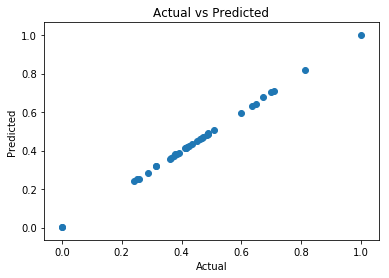

In [265]:
# Predicitng results on x_train
evaluate_model(distributed_lr14, x_df_with_lag_train_sm,y_df_with_lag_train)

*Remaining featues list_price, gmv-2 are all significant features as thier p-value is less than 0.05. Therefore, accepting linear model 14 (distributed_lr_14) as the final model.*

In [266]:
# Scaling the test dataset
df_with_lag_test = pd.DataFrame(distributed_scaler.transform(df_with_lag_test), columns=df_with_lag_test.columns)

# Splitting into X & Y features
y_df_with_lag_test = pd.DataFrame(df_with_lag_test.pop('gmv'))
x_df_with_lag_test = df_with_lag_test

# Keeping the significant features
x_df_with_lag_test_rfe=x_df_with_lag_test[x_df_with_lag_train_sm.iloc[:,1:].columns]
x_df_with_lag_test_rfe.head()

units  list_price   Digital  product_type_Mass
0  0.513626    0.584958  0.214307           0.512241
1  0.390210    0.562500  0.064161           0.394059
2  0.153012    0.243465  0.079297           0.153735
3  0.305155    0.418343  0.135125           0.305401
4  0.000000    0.000506  0.067569           0.000000

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


r2 score is 99.98%
RMSE is 0.0


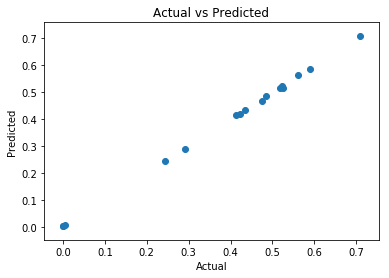

In [267]:
# Predict results on test set
x_df_with_lag_test_sm = sm.add_constant(x_df_with_lag_test_rfe)
evaluate_model(distributed_lr14,x_df_with_lag_test_sm,y_df_with_lag_test)

**K-Fold Validation**

r2 score of cross validation on train dataset:
0.2822
0.8791
0.9307
0.8926
0.9098
0.9537
Avg. r2 score 0.8080166666666667

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  91.07 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  62.3 %


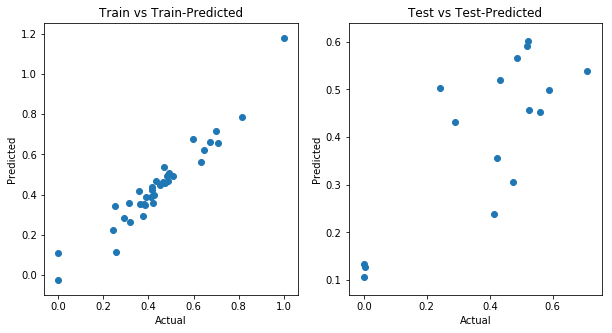

In [268]:
kfold(distributed_lr, x_df_with_lag_train,y_df_with_lag_train,x_df_with_lag_test,y_df_with_lag_test)

**Elasticity Analysis**

*elasticity(in terms of var) = coefficient(var) * mean(df[var])/mean(df['gmv'])*

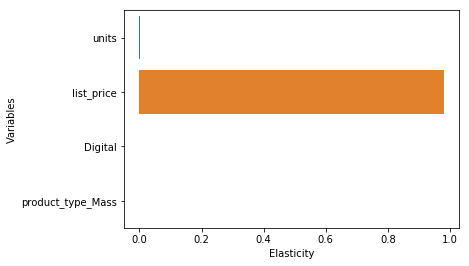

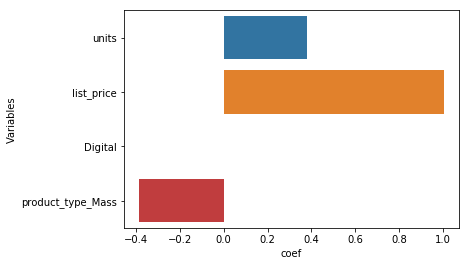

Variables      coef  Elasticity
0              units  0.379801      0.0005
1         list_price  1.003356      0.9795
2            Digital  0.001467      0.0000
3  product_type_Mass -0.385210     -0.0005

In [269]:
elax_df=elasticity(distributed_lr14, df_with_lag)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

## 2. Camera Accessory

### **2(A): Linear Model**

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


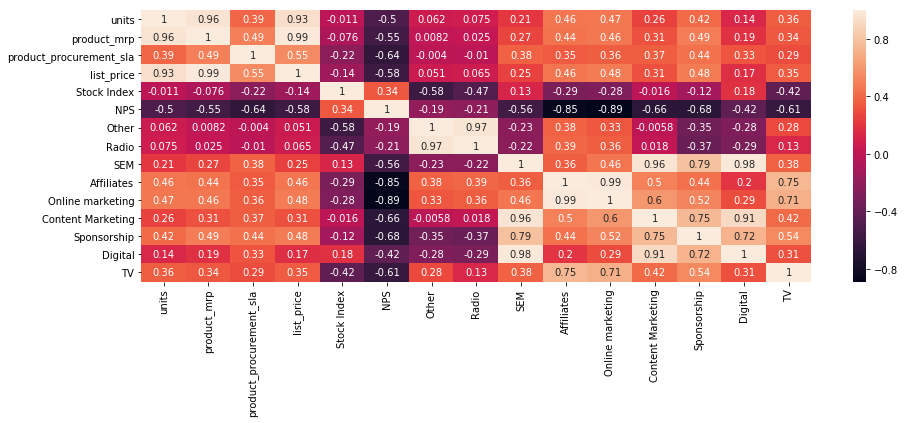

In [283]:
# Splitting the dataset into train & test dataset
camera_train, camera_test = train_test_split(camera_df, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the train dataset
scaler=MinMaxScaler()
camera_train = pd.DataFrame(scaler.fit_transform(camera_train), columns=camera_train.columns)

# Splitting into X & Y features
y_lin_train = pd.DataFrame(camera_train.pop('gmv'))
x_lin_train = camera_train

# Feature Selection using RFE technique
linreg = LinearRegression()
linreg.fit(x_lin_train,y_lin_train)

rfe = RFE(linreg, 15)
rfe = rfe.fit(x_lin_train,y_lin_train)

# Keeping the features that are supported by RFE
x_lin_train_rfe = x_lin_train[x_lin_train.columns[rfe.support_]]

# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_lin_train_rfe.corr(), annot=True)
plt.show()

In [284]:
# Creating the linear regression model
x_lin_train_sm = sm.add_constant(x_lin_train_rfe)
lin_lm_1 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.269e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.27e-46
Time:                        21:14:53   Log-Likelihood:                 212.48
No. Observations:                  37   AIC:                            -393.0
Df Residuals:                      21   BIC:                            -367.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [285]:
x_lin_train_sm.drop(['product_mrp'], 1, inplace=True)
lin_lm_2 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.181e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.57e-49
Time:                        21:14:53   Log-Likelihood:                 212.28
No. Observations:                  37   AIC:                            -394.6
Df Residuals:                      22   BIC:                            -370.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [286]:
x_lin_train_sm.drop(['Content Marketing'], 1, inplace=True)
lin_lm_3 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.012e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.76e-51
Time:                        21:14:53   Log-Likelihood:                 211.89
No. Observations:                  37   AIC:                            -395.8
Df Residuals:                      23   BIC:                            -373.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [287]:
x_lin_train_sm.drop(['SEM'], 1, inplace=True)
lin_lm_4 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.035e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.69e-53
Time:                        21:14:53   Log-Likelihood:                 210.03
No. Observations:                  37   AIC:                            -394.1
Df Residuals:                      24   BIC:                            -373.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [288]:
x_lin_train_sm.drop(['Stock Index'], 1, inplace=True)
lin_lm_5 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.131e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.69e-56
Time:                        21:14:53   Log-Likelihood:                 209.32
No. Observations:                  37   AIC:                            -394.6
Df Residuals:                      25   BIC:                            -375.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [289]:
x_lin_train_sm.drop(['Online marketing'], 1, inplace=True)
lin_lm_6 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.239e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.66e-58
Time:                        21:14:53   Log-Likelihood:                 208.51
No. Observations:                  37   AIC:                            -395.0
Df Residuals:                      26   BIC:                            -377.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [290]:
x_lin_train_sm.drop(['Affiliates'], 1, inplace=True)
lin_lm_7 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.405e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.17e-60
Time:                        21:14:53   Log-Likelihood:                 208.20
No. Observations:                  37   AIC:                            -396.4
Df Residuals:                      27   BIC:                            -380.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [291]:
x_lin_train_sm.drop(['NPS'], 1, inplace=True)
lin_lm_8 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.434e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.81e-62
Time:                        21:14:53   Log-Likelihood:                 205.72
No. Observations:                  37   AIC:                            -393.4
Df Residuals:                      28   BIC:                            -378.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

r2 score is 100.0%
RMSE is 0.0


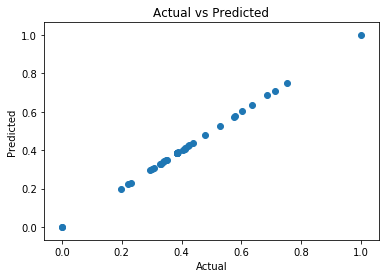

In [292]:
# Predicitng results on x_train
evaluate_model(lin_lm_8, x_lin_train_sm, y_lin_train)

*Remaining featues units, product_procurement_sla, list_price, Other, Radio, Sponsorship, Digital, TV are all significant features as thier p-value is less than 0.05. Therefore, accepting linear model 7 (lin_mn_7) as the final model.*

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


r2 score is 99.99%
RMSE is 0.0


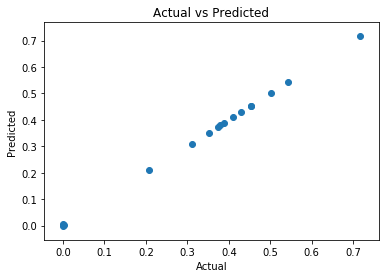

In [293]:
# Scaling the test data
camera_test = pd.DataFrame(scaler.transform(camera_test), columns=camera_test.columns)

# Splitting into X & Y features
y_lin_test = pd.DataFrame(camera_test.pop('gmv'))
x_lin_test = camera_test

# Keeping the significant features
x_lin_test_rfe=x_lin_test[x_lin_train_sm.iloc[:,1:].columns]

# Predicting the results
x_lin_test_sm = sm.add_constant(x_lin_test_rfe)
evaluate_model(lin_lm_8, x_lin_test_sm, y_lin_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.9124
0.9902
0.9965
0.9798
0.999
0.9943
Avg. r2 score 0.9787

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  99.11999999999999 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  75.2 %


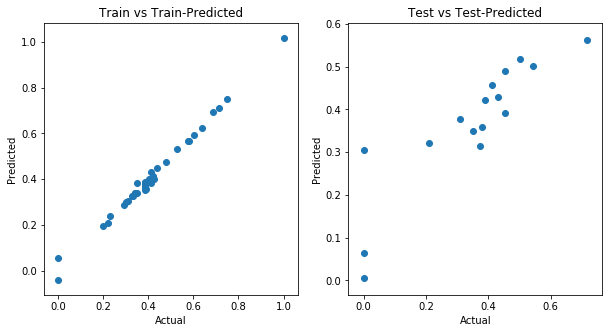

In [294]:
kfold(linreg,x_lin_train,y_lin_train,x_lin_test,y_lin_test)

**Elasticity**

*elasticity(in terms of var) = coefficient(var) * mean(df[var])/mean(df['gmv'])*

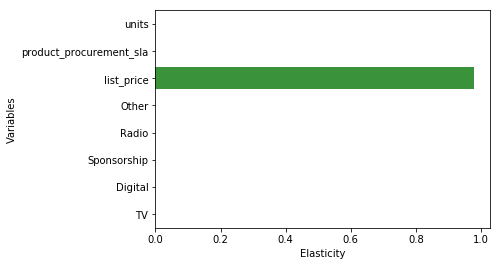

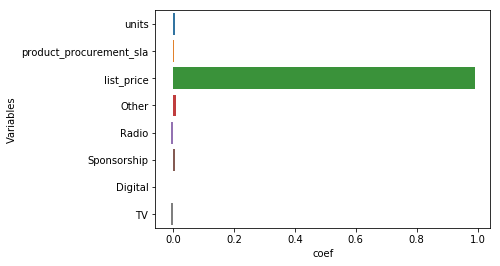

Variables      coef  Elasticity
0                    units  0.006135      0.0000
1  product_procurement_sla  0.004445      0.0000
2               list_price  0.991643      0.9797
3                    Other  0.009198      0.0000
4                    Radio -0.008129     -0.0000
5              Sponsorship  0.005458      0.0000
6                  Digital -0.001751     -0.0000
7                       TV -0.006010     -0.0000

In [295]:
elax_df=elasticity(lin_lm_8,camera_df)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

### **2(B): Multiplicative Model**

In [296]:
multiplicative_df = camera_df.copy()

multiplicative_df=multiplicative_df.replace(0,0.01).fillna(0.01)
multiplicative_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0    17520.0    26.0  2.384615      39311.0                 2.807692   
1  3894413.0  2938.0  7.053718    6966304.0                 2.749555   
2  4523378.0  3117.0  6.382499    7740531.0                 2.781240   
3  4375438.0  3109.0  6.407890    7625956.0                 2.835841   
4  2925943.0  2082.0  6.368712    4951697.0                 2.784708   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0     17520.0   838.115385  1177.000000  54.599588   0.01  ...      25.428571   
1   3843690.0  1110.855212  1177.000000  54.599588   0.01  ...      24.833333   
2   4466995.0  1085.030162  1177.000000  54.599588   0.01  ...      28.750000   
3   4285722.0  1116.761618  1177.000000  54.599588   0.01  ...      29.750000   
4   2883628.0  1040.276157  1177.029175  54.605008   0.01  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.010000            5.183333   
3      16.600000       23.060000            0.010000            5.060000   
4      17.500000       24.566667            0.010000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000             0.01           0.600000               0.01   
1         4.416667             0.01           4.416667               0.01   
2         1.400000             0.01           1.400000               0.01   
3         0.900000             0.01           0.900000               0.01   
4         4.633333             0.01           4.633333               0.01   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

In [297]:
multiplicative_df = np.log(multiplicative_df)
multiplicative_df.head()

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


gmv     units       sla  product_mrp  product_procurement_sla  \
0   9.771098  3.258097  0.869038    10.579260                 1.032363   
1  15.175054  7.985484  1.953555    15.756595                 1.011439   
2  15.324770  8.044626  1.853560    15.861981                 1.022897   
3  15.291517  8.042056  1.857530    15.847068                 1.042338   
4  14.889127  7.641084  1.851397    15.415241                 1.024143   

   list_price  discount  Stock Index       NPS    Other  ...  Max Temp (°C)  \
0    9.771098  6.731156     7.070724  4.000026 -4.60517  ...       3.235873   
1   15.161943  7.012885     7.070724  4.000026 -4.60517  ...       3.212187   
2   15.312226  6.989363     7.070724  4.000026 -4.60517  ...       3.358638   
3   15.270800  7.018188     7.070724  4.000026 -4.60517  ...       3.392829   
4   14.874560  6.947241     7.070749  4.000126 -4.60517  ...       3.452630   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0       2.639057        2.982068           -2.639057            0.587787   
1       2.730029        3.000720           -1.261131            0.868500   
2       2.866951        3.143434           -4.605170            1.645448   
3       2.809403        3.138100           -4.605170            1.621366   
4       2.862201        3.201391           -4.605170            1.882006   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0        -0.510826         -4.60517          -0.510826           -4.60517   
1         1.485385         -4.60517           1.485385           -4.60517   
2         0.336472         -4.60517           0.336472           -4.60517   
3        -0.105361         -4.60517          -0.105361           -4.60517   
4         1.533277         -4.60517           1.533277           -4.60517   

       week  
0  0.000000  
1  0.693147  
2  1.098612  
3  1.386294  
4  1.609438  

[5 rows x 39 columns]

In [298]:
multiplicative_df.isnull().sum()

gmv                         0
units                       0
sla                         0
product_mrp                 0
product_procurement_sla     0
list_price                  0
discount                    0
Stock Index                 0
NPS                         0
Other                       0
Radio                       0
SEM                         0
Affiliates                  0
Online marketing            0
Content Marketing           0
Sponsorship                 0
Digital                     0
TV                          0
shelf_inflation             0
discout_list                0
discout_mrp                 0
product_type_Mass           0
product_type_Mid_level      0
product_type_Premium        0
payday_flag                 0
sale_day_flag               0
holiday_flag                0
COD                         0
Prepaid                     0
Max Temp (°C)               1
Min Temp (°C)              14
Mean Temp (°C)              6
Heat Deg Days (°C)          0
Cool Deg D

In [299]:
multiplicative_df['Max Temp (°C)'] = multiplicative_df['Max Temp (°C)'].fillna(multiplicative_df['Max Temp (°C)'].mean())
multiplicative_df['Min Temp (°C)'] = multiplicative_df['Min Temp (°C)'].fillna(multiplicative_df['Min Temp (°C)'].mean())
multiplicative_df['Mean Temp (°C)'] = multiplicative_df['Mean Temp (°C)'].fillna(multiplicative_df['Mean Temp (°C)'].mean())

multiplicative_df.isnull().sum()

gmv                        0
units                      0
sla                        0
product_mrp                0
product_procurement_sla    0
list_price                 0
discount                   0
Stock Index                0
NPS                        0
Other                      0
Radio                      0
SEM                        0
Affiliates                 0
Online marketing           0
Content Marketing          0
Sponsorship                0
Digital                    0
TV                         0
shelf_inflation            0
discout_list               0
discout_mrp                0
product_type_Mass          0
product_type_Mid_level     0
product_type_Premium       0
payday_flag                0
sale_day_flag              0
holiday_flag               0
COD                        0
Prepaid                    0
Max Temp (°C)              0
Min Temp (°C)              0
Mean Temp (°C)             0
Heat Deg Days (°C)         0
Cool Deg Days (°C)         0
Total Rain (mm

In [300]:
# Train Test Split
multi_train, multi_test = train_test_split(multiplicative_df, train_size=0.7, test_size=0.3, random_state=100)

# Splitting X & Y features
y_multi_train = pd.DataFrame(multi_train.pop('gmv'))
x_multi_train = multi_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


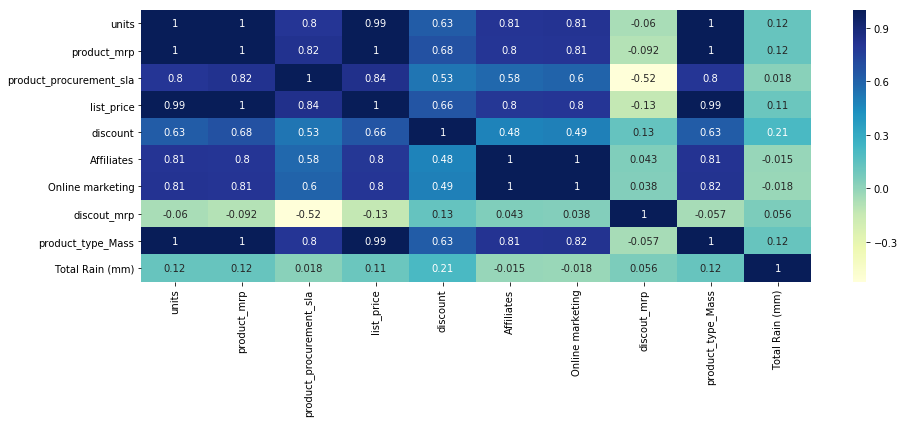

In [301]:
lr = LinearRegression()
lr.fit(x_multi_train,y_multi_train)

rfe = RFE(lr,10)
rfe = rfe.fit(x_multi_train,y_multi_train)

# Keeping the features that are supported by RFE
x_multi_train_rfe = x_multi_train[x_multi_train.columns[rfe.support_]]

# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_multi_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [302]:
# Creating the linear regression model
x_multi_train_sm = sm.add_constant(x_multi_train_rfe)
mulit_lr1 = get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.382e+06
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.42e-75
Time:                        21:15:12   Log-Likelihood:                 178.51
No. Observations:                  37   AIC:                            -335.0
Df Residuals:                      26   BIC:                            -317.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [303]:
x_multi_train_sm.drop(['discout_mrp'], 1, inplace=True)
multi_lr2=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.616e+06
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           8.40e-78
Time:                        21:15:13   Log-Likelihood:                 177.59
No. Observations:                  37   AIC:                            -335.2
Df Residuals:                      27   BIC:                            -319.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [304]:
x_multi_train_sm.drop(['Online marketing'], 1, inplace=True)
multi_lr3=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.946e+06
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.57e-81
Time:                        21:15:14   Log-Likelihood:                 176.94
No. Observations:                  37   AIC:                            -335.9
Df Residuals:                      28   BIC:                            -321.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [305]:
x_multi_train_sm.drop(['Affiliates'], 1, inplace=True)
multi_lr4=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.459e+06
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.37e-84
Time:                        21:15:15   Log-Likelihood:                 176.79
No. Observations:                  37   AIC:                            -337.6
Df Residuals:                      29   BIC:                            -324.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [306]:
x_multi_train_sm.drop(['product_mrp'], 1, inplace=True)
multi_lr5=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.129e+06
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.41e-87
Time:                        21:15:15   Log-Likelihood:                 176.58
No. Observations:                  37   AIC:                            -339.2
Df Residuals:                      30   BIC:                            -327.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [309]:
x_multi_train_sm.drop(['discount'], 1, inplace=True)
multi_lr6=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.795e+06
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.76e-90
Time:                        21:15:29   Log-Likelihood:                 175.37
No. Observations:                  37   AIC:                            -338.7
Df Residuals:                      31   BIC:                            -329.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [310]:
x_multi_train_sm.drop(['Total Rain (mm)'], 1, inplace=True)
multi_lr7=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.604e+06
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.06e-93
Time:                        21:15:45   Log-Likelihood:                 173.54
No. Observations:                  37   AIC:                            -337.1
Df Residuals:                      32   BIC:                            -329.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

r2 score is 100.0%
RMSE is 0.0


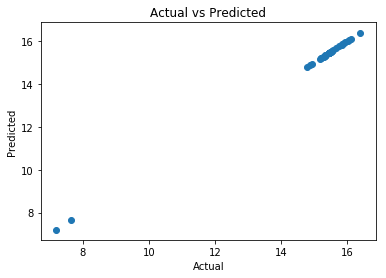

In [311]:
# Predicitng results on x_train
evaluate_model(multi_lr7, x_multi_train_sm, y_multi_train)

r2 score is 100.0%
RMSE is 0.0


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


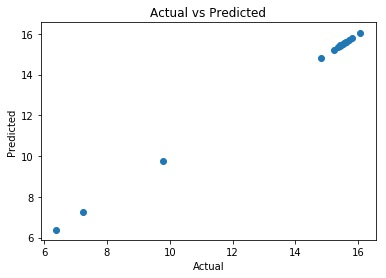

In [312]:
# Splitting into X & Y features
y_multi_test = pd.DataFrame(multi_test.pop('gmv'))
x_multi_test = multi_test

# Keeping the significant features
x_multi_test_rfe=x_multi_test[x_multi_train_sm.iloc[:,1:].columns]

# Predicting the results
x_multi_test_sm = sm.add_constant(x_multi_test_rfe)
evaluate_model(multi_lr7, x_multi_test_sm, y_multi_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.9954
0.9834
0.9999
0.93
0.9716
0.9017
Avg. r2 score 0.9636666666666667

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  97.08 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  98.3 %


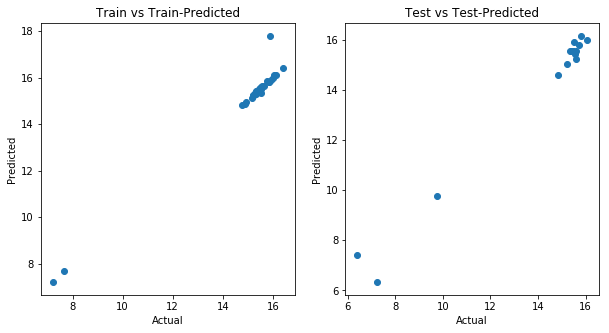

In [313]:
kfold(lr,x_multi_train,y_multi_train,x_multi_test,y_multi_test)

**Elasticity**

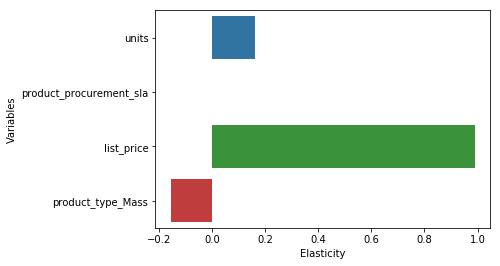

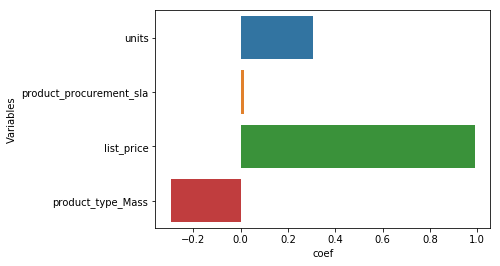

Variables      coef  Elasticity
0                    units  0.305993      0.1611
1  product_procurement_sla  0.015273      0.0010
2               list_price  0.991244      0.9905
3        product_type_Mass -0.296465     -0.1556

In [314]:
elax_df=elasticity(multi_lr7, multiplicative_df)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

### **2(C): Koyck Model**

In [315]:
koyck_df = camera_df.copy()
koyck_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0    17520.0    26.0  2.384615      39311.0                 2.807692   
1  3894413.0  2938.0  7.053718    6966304.0                 2.749555   
2  4523378.0  3117.0  6.382499    7740531.0                 2.781240   
3  4375438.0  3109.0  6.407890    7625956.0                 2.835841   
4  2925943.0  2082.0  6.368712    4951697.0                 2.784708   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0     17520.0   838.115385  1177.000000  54.599588    0.0  ...      25.428571   
1   3843690.0  1110.855212  1177.000000  54.599588    0.0  ...      24.833333   
2   4466995.0  1085.030162  1177.000000  54.599588    0.0  ...      28.750000   
3   4285722.0  1116.761618  1177.000000  54.599588    0.0  ...      29.750000   
4   2883628.0  1040.276157  1177.029175  54.605008    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

**Create Lag Variables**

In [316]:
koyck_df['gmv-1'] = koyck_df['gmv'].shift(-1)
koyck_df = koyck_df.fillna(0)
koyck_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0    17520.0    26.0  2.384615      39311.0                 2.807692   
1  3894413.0  2938.0  7.053718    6966304.0                 2.749555   
2  4523378.0  3117.0  6.382499    7740531.0                 2.781240   
3  4375438.0  3109.0  6.407890    7625956.0                 2.835841   
4  2925943.0  2082.0  6.368712    4951697.0                 2.784708   

   list_price     discount  Stock Index        NPS  Other  ...  Min Temp (°C)  \
0     17520.0   838.115385  1177.000000  54.599588    0.0  ...      14.000000   
1   3843690.0  1110.855212  1177.000000  54.599588    0.0  ...      15.333333   
2   4466995.0  1085.030162  1177.000000  54.599588    0.0  ...      17.583333   
3   4285722.0  1116.761618  1177.000000  54.599588    0.0  ...      16.600000   
4   2883628.0  1040.276157  1177.029175  54.605008    0.0  ...      17.500000   

   Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  Total Rain (mm)  \
0       19.728571            0.071429            1.800000         0.600000   
1       20.100000            0.283333            2.383333         4.416667   
2       23.183333            0.000000            5.183333         1.400000   
3       23.060000            0.000000            5.060000         0.900000   
4       24.566667            0.000000            6.566667         4.633333   

   Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  week      gmv-1  
0              0.0           0.600000                0.0     1  3894413.0  
1              0.0           4.416667                0.0     2  4523378.0  
2              0.0           1.400000                0.0     3  4375438.0  
3              0.0           0.900000                0.0     4  2925943.0  
4              0.0           4.633333                0.0     5     1398.0  

[5 rows x 40 columns]

In [317]:
koyck_df.isnull().sum()

gmv                        0
units                      0
sla                        0
product_mrp                0
product_procurement_sla    0
list_price                 0
discount                   0
Stock Index                0
NPS                        0
Other                      0
Radio                      0
SEM                        0
Affiliates                 0
Online marketing           0
Content Marketing          0
Sponsorship                0
Digital                    0
TV                         0
shelf_inflation            0
discout_list               0
discout_mrp                0
product_type_Mass          0
product_type_Mid_level     0
product_type_Premium       0
payday_flag                0
sale_day_flag              0
holiday_flag               0
COD                        0
Prepaid                    0
Max Temp (°C)              0
Min Temp (°C)              0
Mean Temp (°C)             0
Heat Deg Days (°C)         0
Cool Deg Days (°C)         0
Total Rain (mm

In [318]:
koyck_train, koyck_test = train_test_split(koyck_df, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the dataset
koyck_scaler = MinMaxScaler()
koyck_train = pd.DataFrame(koyck_scaler.fit_transform(koyck_train), columns=koyck_train.columns)

y_koyck_train = pd.DataFrame(koyck_train.pop('gmv'))
x_koyck_train = koyck_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [319]:
koyck_lr = LinearRegression()
koyck_lr.fit(x_koyck_train,y_koyck_train)

rfe = RFE(koyck_lr, 10)
rfe = rfe.fit(x_koyck_train,y_koyck_train)

# Keeping the features that are supported by RFE
x_koyck_train_rfe = x_koyck_train[x_koyck_train.columns[rfe.support_]]
koyck_lr = LinearRegression()
koyck_lr.fit(x_koyck_train,y_koyck_train)

rfe = RFE(koyck_lr, 15)
rfe = rfe.fit(x_koyck_train,y_koyck_train)

# Keeping the features that are supported by RFE
x_koyck_train_rfe = x_koyck_train[x_koyck_train.columns[rfe.support_]]

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


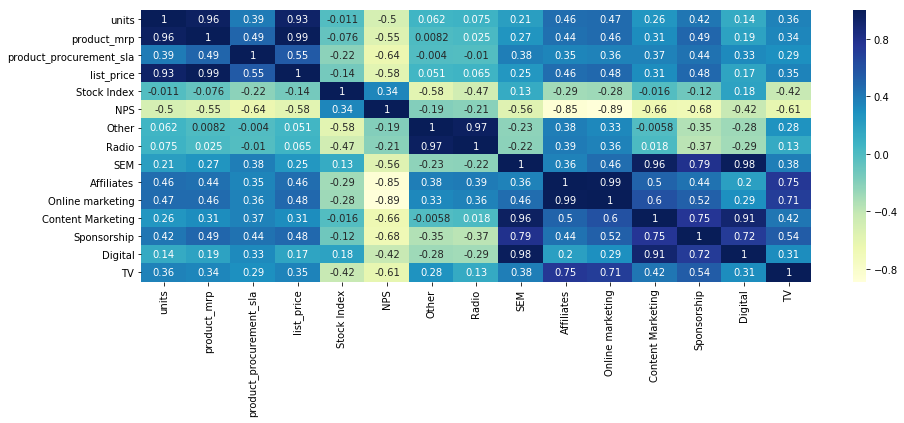

In [320]:
# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_koyck_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [321]:
# Creating the linear regression model
x_koyck_train_sm = sm.add_constant(x_koyck_train_rfe)
koyck_lr1 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.269e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.27e-46
Time:                        21:16:19   Log-Likelihood:                 212.48
No. Observations:                  37   AIC:                            -393.0
Df Residuals:                      21   BIC:                            -367.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [322]:
x_koyck_train_sm.drop(['Content Marketing'], 1, inplace=True)
koyck_lr2 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.213e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.40e-49
Time:                        21:16:23   Log-Likelihood:                 212.35
No. Observations:                  37   AIC:                            -394.7
Df Residuals:                      22   BIC:                            -370.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [323]:
x_koyck_train_sm.drop(['product_mrp'], 1, inplace=True)
koyck_lr3 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.012e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.76e-51
Time:                        21:16:29   Log-Likelihood:                 211.89
No. Observations:                  37   AIC:                            -395.8
Df Residuals:                      23   BIC:                            -373.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [324]:
x_koyck_train_sm.drop(['SEM'], 1, inplace=True)
koyck_lr4 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.035e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.69e-53
Time:                        21:16:30   Log-Likelihood:                 210.03
No. Observations:                  37   AIC:                            -394.1
Df Residuals:                      24   BIC:                            -373.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [325]:
x_koyck_train_sm.drop(['Stock Index'], 1, inplace=True)
koyck_lr5 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.131e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.69e-56
Time:                        21:16:31   Log-Likelihood:                 209.32
No. Observations:                  37   AIC:                            -394.6
Df Residuals:                      25   BIC:                            -375.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [326]:
x_koyck_train_sm.drop(['Affiliates'], 1, inplace=True)
koyck_lr6 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.225e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.24e-58
Time:                        21:16:32   Log-Likelihood:                 208.30
No. Observations:                  37   AIC:                            -394.6
Df Residuals:                      26   BIC:                            -376.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [327]:
x_koyck_train_sm.drop(['Online marketing'], 1, inplace=True)
koyck_lr7 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.405e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.17e-60
Time:                        21:16:34   Log-Likelihood:                 208.20
No. Observations:                  37   AIC:                            -396.4
Df Residuals:                      27   BIC:                            -380.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [328]:
x_koyck_train_sm.drop(['NPS'], 1, inplace=True)
koyck_lr8 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.434e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.81e-62
Time:                        21:16:35   Log-Likelihood:                 205.72
No. Observations:                  37   AIC:                            -393.4
Df Residuals:                      28   BIC:                            -378.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

r2 score is 100.0%
RMSE is 0.0


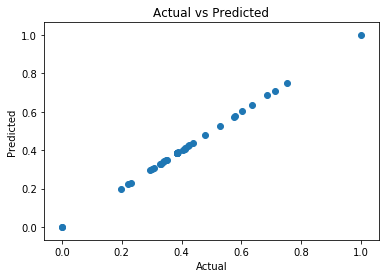

In [329]:
# Predicitng results on x_train
evaluate_model(koyck_lr8, x_koyck_train_sm, y_koyck_train)

r2 score is 99.99%
RMSE is 0.0


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


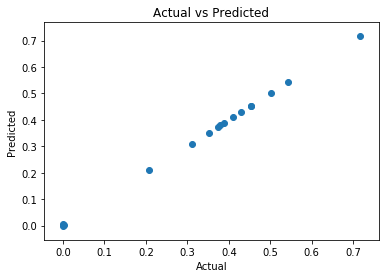

In [330]:
# Scaling the test data
koyck_test = pd.DataFrame(koyck_scaler.transform(koyck_test), columns=koyck_test.columns)

# Splitting into X & Y features
y_koyck_test = pd.DataFrame(koyck_test.pop('gmv'))
x_koyck_test = koyck_test

# Keeping the significant features
x_koyck_test_rfe=x_koyck_test[x_koyck_train_sm.iloc[:,1:].columns]
x_koyck_test_rfe.head()

# Predicting the results
x_koyck_test_sm = sm.add_constant(x_koyck_test_rfe)
evaluate_model(koyck_lr8, x_koyck_test_sm, y_koyck_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.9685
0.9859
0.9712
0.9972
0.9862
0.9934
Avg. r2 score 0.9837333333333333

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  98.27 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  87.3 %


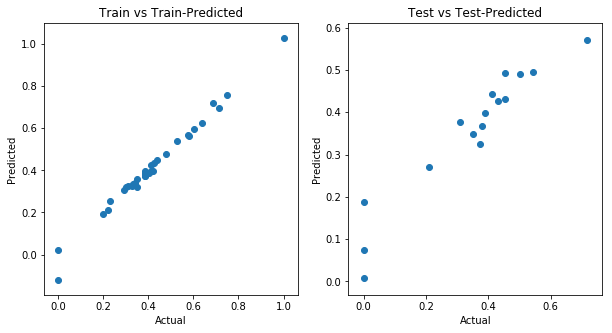

In [331]:
kfold(koyck_lr,x_koyck_train,y_koyck_train,x_koyck_test,y_koyck_test)

**Elasticity**

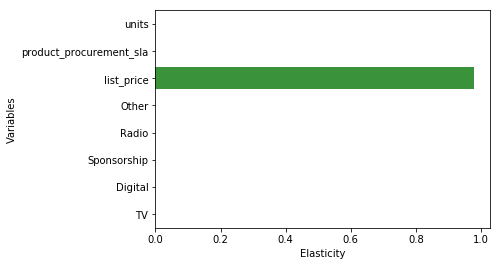

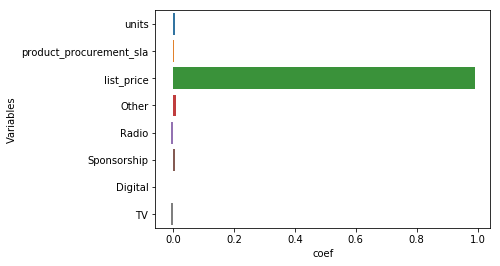

Variables      coef  Elasticity
0                    units  0.006135      0.0000
1  product_procurement_sla  0.004445      0.0000
2               list_price  0.991643      0.9797
3                    Other  0.009198      0.0000
4                    Radio -0.008129     -0.0000
5              Sponsorship  0.005458      0.0000
6                  Digital -0.001751     -0.0000
7                       TV -0.006010     -0.0000

In [332]:
elax_df=elasticity(koyck_lr8, koyck_df)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

### **2(D): Distributed Lag Model**

In [333]:
df_with_lag = camera_df.copy()
df_with_lag.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0    17520.0    26.0  2.384615      39311.0                 2.807692   
1  3894413.0  2938.0  7.053718    6966304.0                 2.749555   
2  4523378.0  3117.0  6.382499    7740531.0                 2.781240   
3  4375438.0  3109.0  6.407890    7625956.0                 2.835841   
4  2925943.0  2082.0  6.368712    4951697.0                 2.784708   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0     17520.0   838.115385  1177.000000  54.599588    0.0  ...      25.428571   
1   3843690.0  1110.855212  1177.000000  54.599588    0.0  ...      24.833333   
2   4466995.0  1085.030162  1177.000000  54.599588    0.0  ...      28.750000   
3   4285722.0  1116.761618  1177.000000  54.599588    0.0  ...      29.750000   
4   2883628.0  1040.276157  1177.029175  54.605008    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

**Creating Lag Variables**

In [334]:
# Creating lag variables
create_lag_var(df_with_lag)

df_with_lag['gmv-1'] = df_with_lag['gmv'].shift(-1)
df_with_lag['gmv-2'] = df_with_lag['gmv'].shift(-2)
df_with_lag['gmv-3'] = df_with_lag['gmv'].shift(-3)

df_with_lag = df_with_lag.fillna(0)

df_with_lag.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0    17520.0    26.0  2.384615      39311.0                 2.807692   
1  3894413.0  2938.0  7.053718    6966304.0                 2.749555   
2  4523378.0  3117.0  6.382499    7740531.0                 2.781240   
3  4375438.0  3109.0  6.407890    7625956.0                 2.835841   
4  2925943.0  2082.0  6.368712    4951697.0                 2.784708   

   list_price     discount  Stock Index        NPS  Other  ...       LP-3  \
0     17520.0   838.115385  1177.000000  54.599588    0.0  ...  4285722.0   
1   3843690.0  1110.855212  1177.000000  54.599588    0.0  ...  2883628.0   
2   4466995.0  1085.030162  1177.000000  54.599588    0.0  ...     1398.0   
3   4285722.0  1116.761618  1177.000000  54.599588    0.0  ...      598.0   
4   2883628.0  1040.276157  1177.029175  54.605008    0.0  ...     1346.5   

         Dis-1        Dis-2        Dis-3      NPS-1      NPS-2      NPS-3  \
0  1110.855212  1085.030162  1116.761618  54.599588  54.599588  54.599588   
1  1085.030162  1116.761618  1040.276157  54.599588  54.599588  54.605008   
2  1116.761618  1040.276157   751.000000  54.599588  54.605008  59.987101   
3  1040.276157   751.000000  1691.000000  54.605008  59.987101  59.987101   
4   751.000000  1691.000000   973.300000  59.987101  59.987101  59.987101   

       gmv-1      gmv-2      gmv-3  
0  3894413.0  4523378.0  4375438.0  
1  4523378.0  4375438.0  2925943.0  
2  4375438.0  2925943.0     1398.0  
3  2925943.0     1398.0      598.0  
4     1398.0      598.0     1346.5  

[5 rows x 51 columns]

In [335]:
df_with_lag_train, df_with_lag_test = train_test_split(df_with_lag, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the dataset
distributed_scaler = MinMaxScaler()
df_with_lag_train = pd.DataFrame(distributed_scaler.fit_transform(df_with_lag_train),columns=df_with_lag_train.columns)

y_df_with_lag_train = pd.DataFrame(df_with_lag_train.pop('gmv'))
x_df_with_lag_train = df_with_lag_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


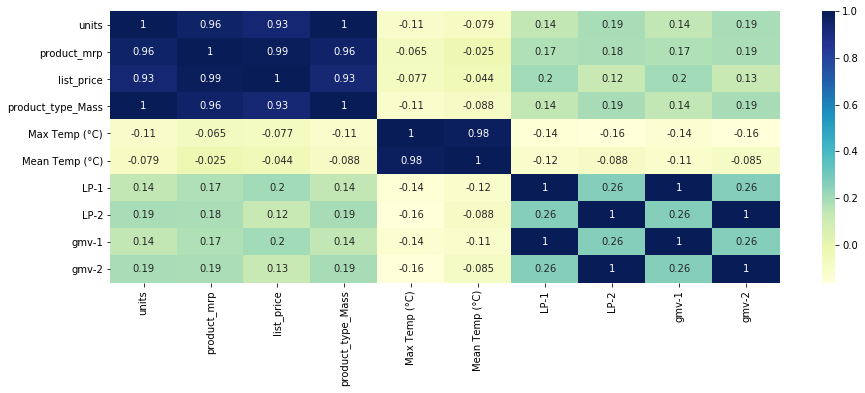

In [336]:
distributed_lr = LinearRegression()
distributed_lr.fit(x_df_with_lag_train,y_df_with_lag_train)

rfe = RFE(distributed_lr, 10)
rfe = rfe.fit(x_df_with_lag_train,y_df_with_lag_train)

# Keeping the features that are supported by RFE
x_df_with_lag_train_rfe = x_df_with_lag_train[x_df_with_lag_train.columns[rfe.support_]]

# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_df_with_lag_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [337]:
# Creating the linear regression model
x_df_with_lag_train_sm = sm.add_constant(x_df_with_lag_train_rfe)
distributed_lr1 = get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.261e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.60e-56
Time:                        21:17:05   Log-Likelihood:                 203.13
No. Observations:                  37   AIC:                            -384.3
Df Residuals:                      26   BIC:                            -366.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0004      0.00

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [338]:
# x_df_with_lag_train_sm.drop(['LP-2'], 1, inplace=True)
# distributed_lr2=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

r2 score is 100.0%
RMSE is 0.0


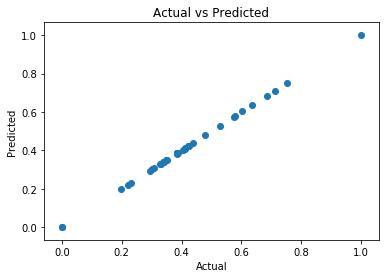

In [339]:
# Predicitng results on x_train
evaluate_model(distributed_lr1, x_df_with_lag_train_sm,y_df_with_lag_train)

r2 score is 100.0%
RMSE is 0.0


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


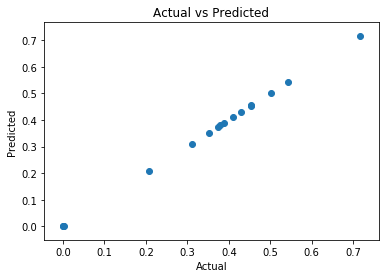

In [340]:
# Scaling the test dataset
df_with_lag_test = pd.DataFrame(distributed_scaler.transform(df_with_lag_test), columns=df_with_lag_test.columns)

# Splitting into X & Y features
y_df_with_lag_test = pd.DataFrame(df_with_lag_test.pop('gmv'))
x_df_with_lag_test = df_with_lag_test

# Keeping the significant features
x_df_with_lag_test_rfe=x_df_with_lag_test[x_df_with_lag_train_sm.iloc[:,1:].columns]
x_df_with_lag_test_rfe.head()

# Predict results on test set
x_df_with_lag_test_sm = sm.add_constant(x_df_with_lag_test_rfe)
evaluate_model(distributed_lr1,x_df_with_lag_test_sm,y_df_with_lag_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.8117
0.9779
0.9829
0.712
0.8299
0.8588
Avg. r2 score 0.8622

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  90.45 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  77.7 %


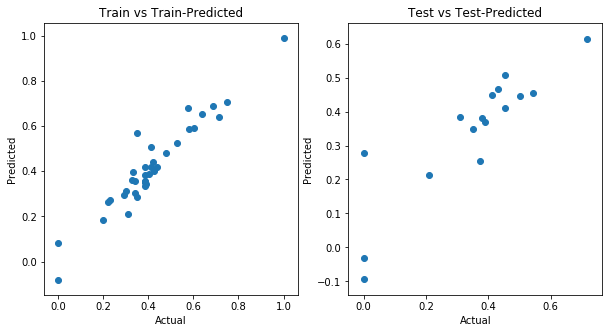

In [341]:
kfold(distributed_lr, x_df_with_lag_train,y_df_with_lag_train,x_df_with_lag_test,y_df_with_lag_test)

**Elasticity**

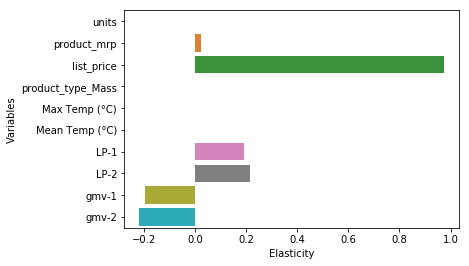

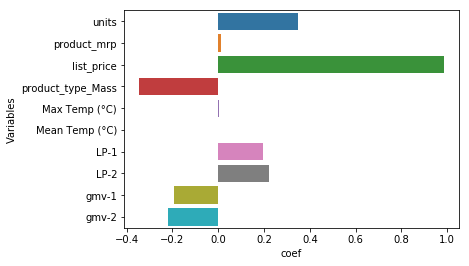

Variables      coef  Elasticity
0              units  0.348395      0.0003
1        product_mrp  0.013774      0.0254
2         list_price  0.985068      0.9732
3  product_type_Mass -0.344961     -0.0003
4      Max Temp (°C)  0.003002      0.0000
5     Mean Temp (°C) -0.001957     -0.0000
6               LP-1  0.194761      0.1924
7               LP-2  0.220053      0.2143
8              gmv-1 -0.193045     -0.1930
9              gmv-2 -0.220343     -0.2172

In [342]:
elax_df=elasticity(distributed_lr1, df_with_lag)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

## **3. Home Audio**

### **3(A): Linear Model**

In [354]:
# Splitting the dataset into train & test dataset
home_train, home_test = train_test_split(home_df, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the train dataset
scaler=MinMaxScaler()
home_train = pd.DataFrame(scaler.fit_transform(home_train), columns=home_train.columns)

# Splitting into X & Y features
y_lin_train = pd.DataFrame(home_train.pop('gmv'))
x_lin_train = home_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


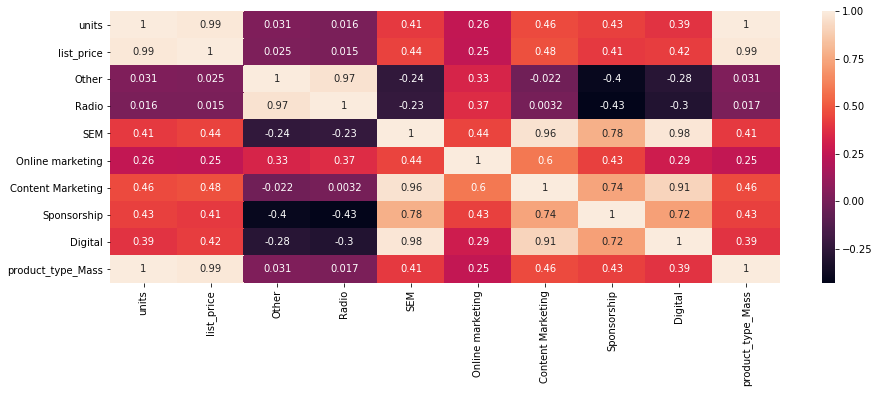

In [355]:
# Feature Selection using RFE technique
linreg = LinearRegression()
linreg.fit(x_lin_train,y_lin_train)

rfe = RFE(linreg, 10)
rfe = rfe.fit(x_lin_train,y_lin_train)

# Keeping the features that are supported by RFE
x_lin_train_rfe = x_lin_train[x_lin_train.columns[rfe.support_]]

# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_lin_train_rfe.corr(), annot=True)
plt.show()

In [356]:
# Creating the linear regression model
x_lin_train_sm = sm.add_constant(x_lin_train_rfe)
lin_lm_1 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.590e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.42e-59
Time:                        21:19:18   Log-Likelihood:                 219.08
No. Observations:                  37   AIC:                            -416.2
Df Residuals:                      26   BIC:                            -398.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0043      0.00

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [357]:
x_lin_train_sm.drop(['SEM'], 1, inplace=True)
lin_lm_2 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.744e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           6.34e-62
Time:                        21:19:18   Log-Likelihood:                 218.15
No. Observations:                  37   AIC:                            -416.3
Df Residuals:                      27   BIC:                            -400.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0028      0.00

In [358]:
x_lin_train_sm.drop(['Online marketing'], 1, inplace=True)
lin_lm_3 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.836e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.70e-64
Time:                        21:19:18   Log-Likelihood:                 216.24
No. Observations:                  37   AIC:                            -414.5
Df Residuals:                      28   BIC:                            -400.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0013      0.00

In [359]:
x_lin_train_sm.drop(['Content Marketing'], 1, inplace=True)
lin_lm_4 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.123e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.64e-66
Time:                        21:19:18   Log-Likelihood:                 215.81
No. Observations:                  37   AIC:                            -415.6
Df Residuals:                      29   BIC:                            -402.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.00

In [360]:
x_lin_train_sm.drop(['Sponsorship'], 1, inplace=True)
lin_lm_5 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.493e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.66e-69
Time:                        21:19:18   Log-Likelihood:                 215.30
No. Observations:                  37   AIC:                            -416.6
Df Residuals:                      30   BIC:                            -405.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0009      0.00

In [361]:
x_lin_train_sm.drop(['Radio'], 1, inplace=True)
lin_lm_9 = get_model_and_print_summary(x_lin_train_sm, y_lin_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.079e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           8.40e-72
Time:                        21:19:18   Log-Likelihood:                 215.23
No. Observations:                  37   AIC:                            -418.5
Df Residuals:                      31   BIC:                            -408.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0009      0.00

r2 score is 100.0%
RMSE is 0.0


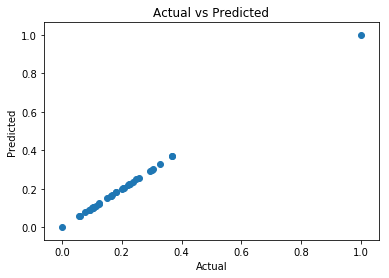

In [362]:
# Predict on train set
evaluate_model(lin_lm_9,x_lin_train_sm,y_lin_train)

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


r2 score is 99.99%
RMSE is 0.0


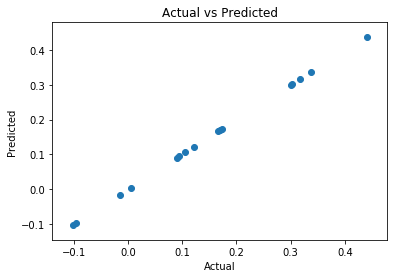

In [363]:
# Scaling the test data
home_test = pd.DataFrame(scaler.transform(home_test), columns=home_test.columns)

# Splitting into X & Y features
y_lin_test = pd.DataFrame(home_test.pop('gmv'))
x_lin_test = home_test

# Keeping the significant features
x_lin_test_rfe=x_lin_test[x_lin_train_sm.iloc[:,1:].columns]

# Predicting the results
x_lin_test_sm = sm.add_constant(x_lin_test_rfe)
evaluate_model(lin_lm_9, x_lin_test_sm, y_lin_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.8546
0.9944
0.9921
0.9128
0.9577
0.9253
Avg. r2 score 0.9394833333333333

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  98.29 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  78.3 %


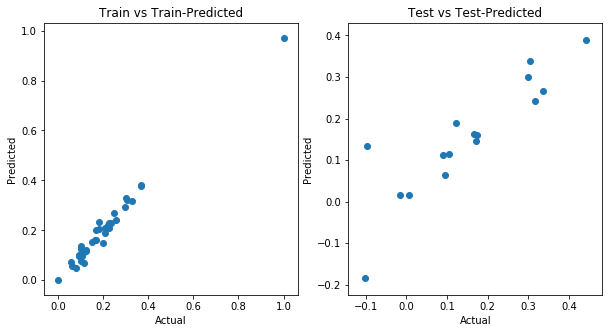

In [364]:
kfold(linreg,x_lin_train,y_lin_train,x_lin_test,y_lin_test)

**Elasticity**

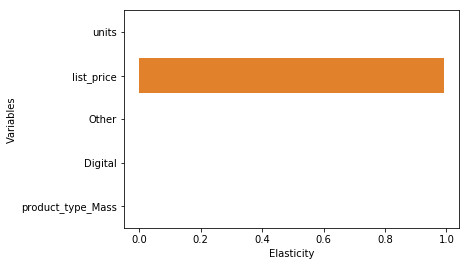

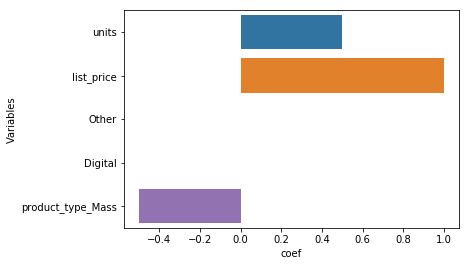

Variables      coef  Elasticity
0              units  0.499200      0.0002
1         list_price  0.997745      0.9908
2              Other  0.001275      0.0000
3            Digital  0.001314      0.0000
4  product_type_Mass -0.498834     -0.0002

In [365]:
elax_df=elasticity(lin_lm_9,home_df)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

### **3(B):Multiplicative Model**

In [366]:
multiplicative_df = home_df.copy()
multiplicative_df=multiplicative_df.replace(0,0.01).fillna(0.01)
multiplicative_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0  1.120440e+05    40.0  2.725000     187612.0                 3.375000   
1  4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
2  5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
3  4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
4  3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0   112044.00  1889.200000       1177.0  54.599588   0.01  ...      25.428571   
1  4659974.13  1294.022806       1177.0  54.599588   0.01  ...      24.833333   
2  5440775.00  1400.890472       1177.0  54.599588   0.01  ...      28.750000   
3  4700286.00  1418.424819       1177.0  54.599588   0.01  ...      29.750000   
4  3428591.00  1400.459615       1177.0  54.599588   0.01  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.010000            5.183333   
3      16.600000       23.060000            0.010000            5.060000   
4      17.500000       24.566667            0.010000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000             0.01           0.600000               0.01   
1         4.416667             0.01           4.416667               0.01   
2         1.400000             0.01           1.400000               0.01   
3         0.900000             0.01           0.900000               0.01   
4         4.633333             0.01           4.633333               0.01   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

In [367]:
multiplicative_df = np.log(multiplicative_df)
multiplicative_df.head()

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


gmv     units       sla  product_mrp  product_procurement_sla  \
0  11.626647  3.688879  1.002468    12.142131                 1.216395   
1  15.360251  7.659643  2.015697    15.813759                 1.003905   
2  15.515400  7.813187  1.961837    15.999465                 0.974345   
3  15.369045  7.708411  1.964309    15.873750                 0.993990   
4  15.052509  7.358194  1.989103    15.540651                 0.978663   

   list_price  discount  Stock Index       NPS    Other  ...  Max Temp (°C)  \
0   11.626647  7.543909     7.070724  4.000026 -4.60517  ...       3.235873   
1   15.354520  7.165511     7.070724  4.000026 -4.60517  ...       3.212187   
2   15.509432  7.244863     7.070724  4.000026 -4.60517  ...       3.358638   
3   15.363134  7.257302     7.070724  4.000026 -4.60517  ...       3.392829   
4   15.047660  7.244556     7.070724  4.000026 -4.60517  ...       3.452630   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0       2.639057        2.982068           -2.639057            0.587787   
1       2.730029        3.000720           -1.261131            0.868500   
2       2.866951        3.143434           -4.605170            1.645448   
3       2.809403        3.138100           -4.605170            1.621366   
4       2.862201        3.201391           -4.605170            1.882006   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0        -0.510826         -4.60517          -0.510826           -4.60517   
1         1.485385         -4.60517           1.485385           -4.60517   
2         0.336472         -4.60517           0.336472           -4.60517   
3        -0.105361         -4.60517          -0.105361           -4.60517   
4         1.533277         -4.60517           1.533277           -4.60517   

       week  
0  0.000000  
1  0.693147  
2  1.098612  
3  1.386294  
4  1.609438  

[5 rows x 39 columns]

In [368]:
multiplicative_df.isnull().sum()

gmv                         0
units                       0
sla                         0
product_mrp                 0
product_procurement_sla     0
list_price                  0
discount                    0
Stock Index                 0
NPS                         0
Other                       0
Radio                       0
SEM                         0
Affiliates                  0
Online marketing            0
Content Marketing           0
Sponsorship                 0
Digital                     0
TV                          0
shelf_inflation             0
discout_list                0
discout_mrp                 0
product_type_Mass           0
product_type_Mid_level      0
product_type_Premium        0
payday_flag                 0
sale_day_flag               0
holiday_flag                0
COD                         0
Prepaid                     0
Max Temp (°C)               1
Min Temp (°C)              14
Mean Temp (°C)              6
Heat Deg Days (°C)          0
Cool Deg D

In [369]:
multiplicative_df['Max Temp (°C)'] = multiplicative_df['Max Temp (°C)'].fillna(multiplicative_df['Max Temp (°C)'].mean())
multiplicative_df['Min Temp (°C)'] = multiplicative_df['Min Temp (°C)'].fillna(multiplicative_df['Min Temp (°C)'].mean())
multiplicative_df['Mean Temp (°C)'] = multiplicative_df['Mean Temp (°C)'].fillna(multiplicative_df['Mean Temp (°C)'].mean())

multiplicative_df.isnull().sum()

gmv                        0
units                      0
sla                        0
product_mrp                0
product_procurement_sla    0
list_price                 0
discount                   0
Stock Index                0
NPS                        0
Other                      0
Radio                      0
SEM                        0
Affiliates                 0
Online marketing           0
Content Marketing          0
Sponsorship                0
Digital                    0
TV                         0
shelf_inflation            0
discout_list               0
discout_mrp                0
product_type_Mass          0
product_type_Mid_level     0
product_type_Premium       0
payday_flag                0
sale_day_flag              0
holiday_flag               0
COD                        0
Prepaid                    0
Max Temp (°C)              0
Min Temp (°C)              0
Mean Temp (°C)             0
Heat Deg Days (°C)         0
Cool Deg Days (°C)         0
Total Rain (mm

In [370]:
# Train Test Split
multi_train, multi_test = train_test_split(multiplicative_df, train_size=0.7, test_size=0.3, random_state=100)

# Splitting X & Y features
y_multi_train = pd.DataFrame(multi_train.pop('gmv'))
x_multi_train = multi_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


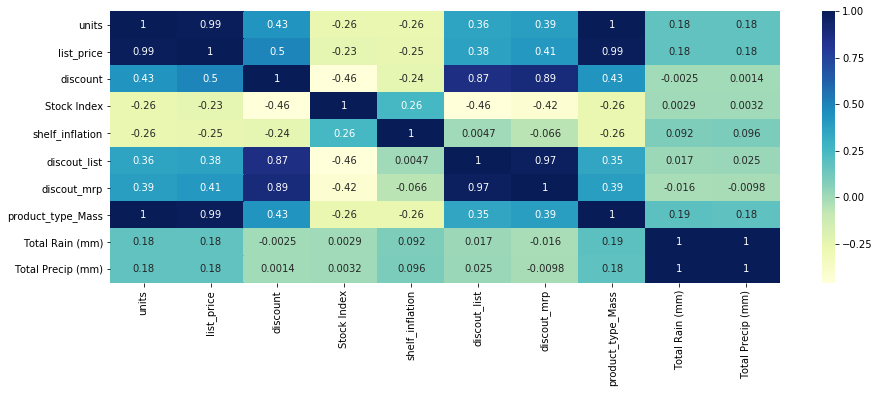

In [371]:
lr = LinearRegression()
lr.fit(x_multi_train,y_multi_train)

rfe = RFE(lr, 10)
rfe = rfe.fit(x_multi_train,y_multi_train)

# Keeping the features that are supported by RFE
x_multi_train_rfe = x_multi_train[x_multi_train.columns[rfe.support_]]

# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_multi_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [372]:
# Creating the linear regression model
x_multi_train_sm = sm.add_constant(x_multi_train_rfe)
mulit_lr1 = get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.509e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.37e-53
Time:                        21:19:41   Log-Likelihood:                 165.26
No. Observations:                  37   AIC:                            -308.5
Df Residuals:                      26   BIC:                            -290.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0930      0.13

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [374]:
x_multi_train_sm.drop(['Stock Index'], 1, inplace=True)
multi_lr2=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.347e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.34e-56
Time:                        21:19:53   Log-Likelihood:                 165.23
No. Observations:                  37   AIC:                            -310.5
Df Residuals:                      27   BIC:                            -294.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0980      0.13

In [375]:
x_multi_train_sm.drop(['shelf_inflation'], 1, inplace=True)
multi_lr3=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.238e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.60e-58
Time:                        21:20:05   Log-Likelihood:                 164.81
No. Observations:                  37   AIC:                            -311.6
Df Residuals:                      28   BIC:                            -297.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1642      0.09

In [376]:
x_multi_train_sm.drop(['discout_mrp'], 1, inplace=True)
multi_lr4=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.439e+04
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.06e-60
Time:                        21:20:18   Log-Likelihood:                 164.53
No. Observations:                  37   AIC:                            -313.1
Df Residuals:                      29   BIC:                            -300.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1766      0.09

In [377]:
x_multi_train_sm.drop(['Total Precip (mm)'], 1, inplace=True)
multi_lr5=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.018e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.15e-63
Time:                        21:20:29   Log-Likelihood:                 164.53
No. Observations:                  37   AIC:                            -315.1
Df Residuals:                      30   BIC:                            -303.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1766      0.09

In [378]:
x_multi_train_sm.drop(['discout_list'], 1, inplace=True)
multi_lr6=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.166e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.87e-65
Time:                        21:20:39   Log-Likelihood:                 163.06
No. Observations:                  37   AIC:                            -314.1
Df Residuals:                      31   BIC:                            -304.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0922      0.07

In [379]:
x_multi_train_sm.drop(['discount'], 1, inplace=True)
multi_lr7=get_model_and_print_summary(x_multi_train_sm,y_multi_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.490e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           8.13e-68
Time:                        21:20:46   Log-Likelihood:                 162.87
No. Observations:                  37   AIC:                            -315.7
Df Residuals:                      32   BIC:                            -307.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0776      0.07

r2 score is 99.99%
RMSE is 0.0


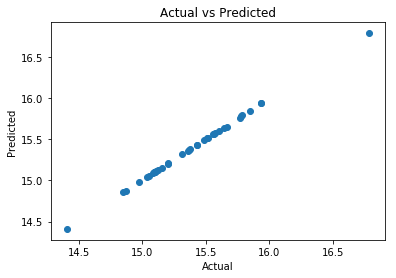

In [380]:
# Predicitng results on x_train
evaluate_model(multi_lr7, x_multi_train_sm, y_multi_train)

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


r2 score is 100.0%
RMSE is 0.01


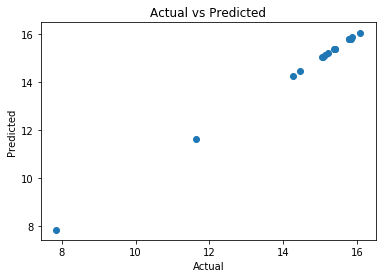

In [381]:
# Splitting into X & Y features
y_multi_test = pd.DataFrame(multi_test.pop('gmv'))
x_multi_test = multi_test

# Keeping the significant features
x_multi_test_rfe=x_multi_test[x_multi_train_sm.iloc[:,1:].columns]

# Predicting the results
x_multi_test_sm = sm.add_constant(x_multi_test_rfe)
evaluate_model(multi_lr7, x_multi_test_sm, y_multi_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.9441
0.9768
0.9966
0.8866
0.9991
0.9514
Avg. r2 score 0.9591

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  97.89999999999999 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  97.2 %


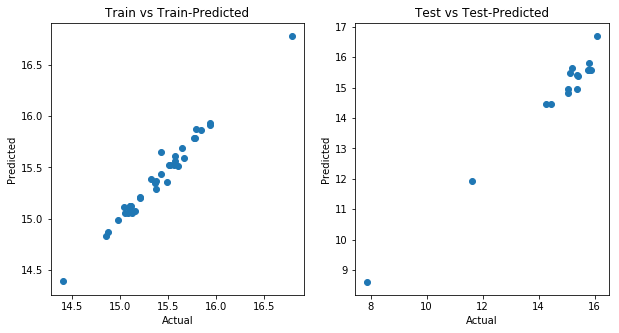

In [382]:
kfold(lr,x_multi_train,y_multi_train,x_multi_test,y_multi_test)

**Elasticity**

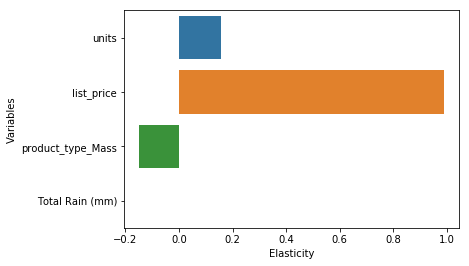

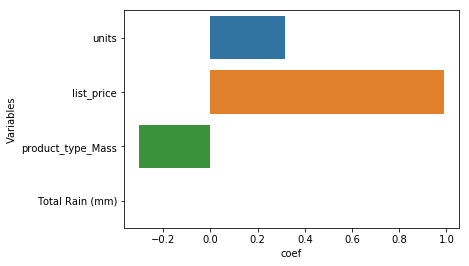

Variables      coef  Elasticity
0              units  0.314883      0.1553
1         list_price  0.988057      0.9876
2  product_type_Mass -0.300795     -0.1481
3    Total Rain (mm) -0.000394      0.0000

In [383]:
elax_df=elasticity(multi_lr7, multiplicative_df)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

### **3(C): Koyck Model**

In [384]:
koyck_df = home_df.copy()
koyck_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0  1.120440e+05    40.0  2.725000     187612.0                 3.375000   
1  4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
2  5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
3  4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
4  3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0   112044.00  1889.200000       1177.0  54.599588    0.0  ...      25.428571   
1  4659974.13  1294.022806       1177.0  54.599588    0.0  ...      24.833333   
2  5440775.00  1400.890472       1177.0  54.599588    0.0  ...      28.750000   
3  4700286.00  1418.424819       1177.0  54.599588    0.0  ...      29.750000   
4  3428591.00  1400.459615       1177.0  54.599588    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

**Creating Lag Variable**

In [385]:
koyck_df['gmv-1'] = koyck_df['gmv'].shift(-1)
koyck_df = koyck_df.fillna(0)
koyck_df.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0  1.120440e+05    40.0  2.725000     187612.0                 3.375000   
1  4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
2  5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
3  4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
4  3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

   list_price     discount  Stock Index        NPS  Other  ...  Min Temp (°C)  \
0   112044.00  1889.200000       1177.0  54.599588    0.0  ...      14.000000   
1  4659974.13  1294.022806       1177.0  54.599588    0.0  ...      15.333333   
2  5440775.00  1400.890472       1177.0  54.599588    0.0  ...      17.583333   
3  4700286.00  1418.424819       1177.0  54.599588    0.0  ...      16.600000   
4  3428591.00  1400.459615       1177.0  54.599588    0.0  ...      17.500000   

   Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  Total Rain (mm)  \
0       19.728571            0.071429            1.800000         0.600000   
1       20.100000            0.283333            2.383333         4.416667   
2       23.183333            0.000000            5.183333         1.400000   
3       23.060000            0.000000            5.060000         0.900000   
4       24.566667            0.000000            6.566667         4.633333   

   Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  week         gmv-1  
0              0.0           0.600000                0.0     1  4.686756e+06  
1              0.0           4.416667                0.0     2  5.473343e+06  
2              0.0           1.400000                0.0     3  4.728153e+06  
3              0.0           0.900000                0.0     4  3.445256e+06  
4              0.0           4.633333                0.0     5  2.599000e+03  

[5 rows x 40 columns]

In [386]:
koyck_df.isnull().sum()

gmv                        0
units                      0
sla                        0
product_mrp                0
product_procurement_sla    0
list_price                 0
discount                   0
Stock Index                0
NPS                        0
Other                      0
Radio                      0
SEM                        0
Affiliates                 0
Online marketing           0
Content Marketing          0
Sponsorship                0
Digital                    0
TV                         0
shelf_inflation            0
discout_list               0
discout_mrp                0
product_type_Mass          0
product_type_Mid_level     0
product_type_Premium       0
payday_flag                0
sale_day_flag              0
holiday_flag               0
COD                        0
Prepaid                    0
Max Temp (°C)              0
Min Temp (°C)              0
Mean Temp (°C)             0
Heat Deg Days (°C)         0
Cool Deg Days (°C)         0
Total Rain (mm

In [387]:
koyck_train, koyck_test = train_test_split(koyck_df, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the dataset
koyck_scaler = MinMaxScaler()
koyck_train = pd.DataFrame(koyck_scaler.fit_transform(koyck_train), columns=koyck_train.columns)

y_koyck_train = pd.DataFrame(koyck_train.pop('gmv'))
x_koyck_train = koyck_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


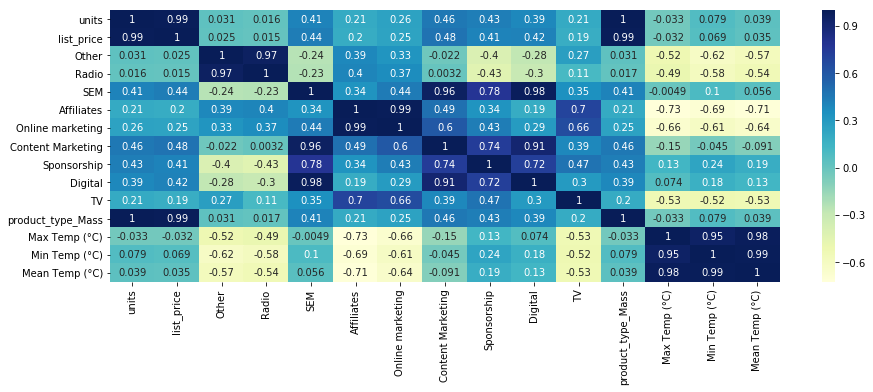

In [388]:
koyck_lr = LinearRegression()
koyck_lr.fit(x_koyck_train,y_koyck_train)

rfe = RFE(koyck_lr, 10)
rfe = rfe.fit(x_koyck_train,y_koyck_train)

# Keeping the features that are supported by RFE
x_koyck_train_rfe = x_koyck_train[x_koyck_train.columns[rfe.support_]]
koyck_lr = LinearRegression()
koyck_lr.fit(x_koyck_train,y_koyck_train)

rfe = RFE(koyck_lr, 15)
rfe = rfe.fit(x_koyck_train,y_koyck_train)

# Keeping the features that are supported by RFE
x_koyck_train_rfe = x_koyck_train[x_koyck_train.columns[rfe.support_]]

# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_koyck_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [389]:
# Creating the linear regression model
x_koyck_train_sm = sm.add_constant(x_koyck_train_rfe)
koyck_lr1 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.120e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.25e-48
Time:                        21:21:44   Log-Likelihood:                 224.06
No. Observations:                  37   AIC:                            -416.1
Df Residuals:                      21   BIC:                            -390.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0043      0.00

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [390]:
x_koyck_train_sm.drop(['Online marketing'],1,inplace=True)
koyck_lr2 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.256e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.46e-50
Time:                        21:22:06   Log-Likelihood:                 224.03
No. Observations:                  37   AIC:                            -418.1
Df Residuals:                      22   BIC:                            -393.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0043      0.00

In [392]:
x_koyck_train_sm.drop(['SEM'],1,inplace=True)
koyck_lr3 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.396e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           4.37e-53
Time:                        21:22:28   Log-Likelihood:                 223.79
No. Observations:                  37   AIC:                            -419.6
Df Residuals:                      23   BIC:                            -397.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0037      0.00

In [393]:
x_koyck_train_sm.drop(['Other'],1,inplace=True)
koyck_lr4 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.559e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.23e-55
Time:                        21:22:38   Log-Likelihood:                 223.58
No. Observations:                  37   AIC:                            -421.2
Df Residuals:                      24   BIC:                            -400.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0038      0.00

In [394]:
x_koyck_train_sm.drop(['Radio'],1,inplace=True)
koyck_lr5 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.742e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           3.50e-58
Time:                        21:22:48   Log-Likelihood:                 223.26
No. Observations:                  37   AIC:                            -422.5
Df Residuals:                      25   BIC:                            -403.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0034      0.00

In [395]:
x_koyck_train_sm.drop(['TV'],1,inplace=True)
koyck_lr6 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.655e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           8.47e-60
Time:                        21:22:56   Log-Likelihood:                 219.82
No. Observations:                  37   AIC:                            -417.6
Df Residuals:                      26   BIC:                            -399.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0037      0.00

In [396]:
x_koyck_train_sm.drop(['Sponsorship'],1,inplace=True)
koyck_lr7 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.909e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.87e-62
Time:                        21:23:12   Log-Likelihood:                 219.82
No. Observations:                  37   AIC:                            -419.6
Df Residuals:                      27   BIC:                            -403.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0037      0.00

In [397]:
x_koyck_train_sm.drop(['Digital'],1,inplace=True)
koyck_lr8 = get_model_and_print_summary(x_koyck_train_sm,y_koyck_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.118e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.68e-65
Time:                        21:23:22   Log-Likelihood:                 218.89
No. Observations:                  37   AIC:                            -419.8
Df Residuals:                      28   BIC:                            -405.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0031      0.00

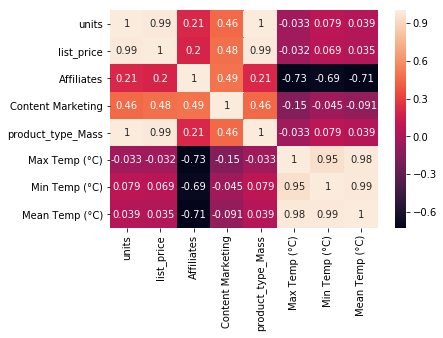

In [398]:
sns.heatmap(x_koyck_train_sm.iloc[:,1:].corr(),annot=True)
plt.show()

r2 score is 100.0%
RMSE is 0.0


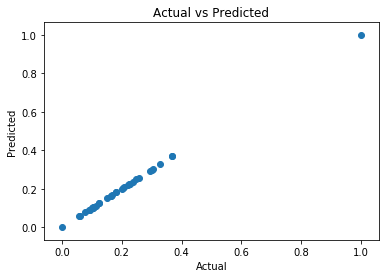

In [399]:
# Predicitng results on x_train
evaluate_model(koyck_lr8, x_koyck_train_sm, y_koyck_train)

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


r2 score is 99.99%
RMSE is 0.0


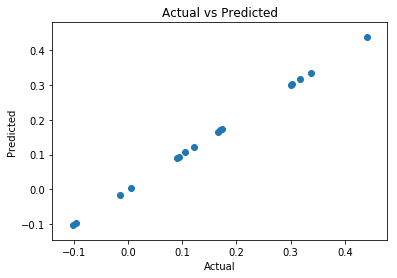

In [400]:
# Scaling the test data
koyck_test = pd.DataFrame(koyck_scaler.transform(koyck_test), columns=koyck_test.columns)

# Splitting into X & Y features
y_koyck_test = pd.DataFrame(koyck_test.pop('gmv'))
x_koyck_test = koyck_test

# Keeping the significant features
x_koyck_test_rfe=x_koyck_test[x_koyck_train_sm.iloc[:,1:].columns]
x_koyck_test_rfe.head()

# Predicting the results
x_koyck_test_sm = sm.add_constant(x_koyck_test_rfe)
evaluate_model(koyck_lr8, x_koyck_test_sm, y_koyck_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.6087
0.9908
0.9946
0.2941
0.9636
0.9206
Avg. r2 score 0.7954

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  95.98 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  76.6 %


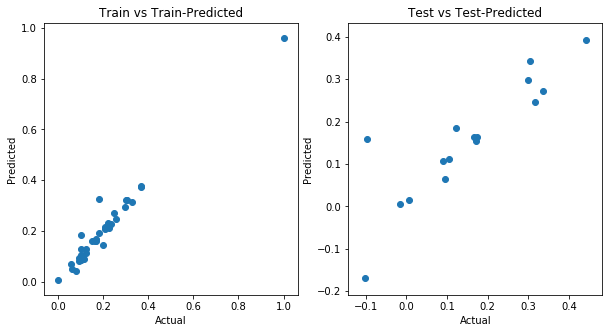

In [401]:
kfold(koyck_lr,x_koyck_train,y_koyck_train,x_koyck_test,y_koyck_test)

**Elasticity**

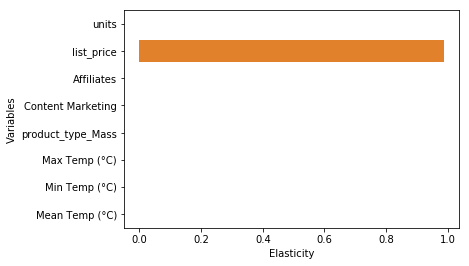

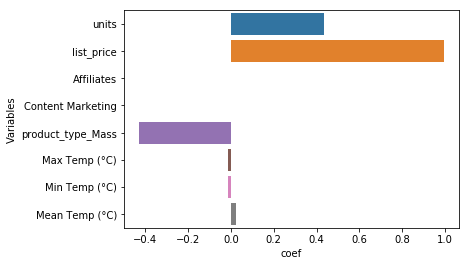

Variables      coef  Elasticity
0              units  0.432492      0.0002
1         list_price  0.993117      0.9862
2         Affiliates -0.001593     -0.0000
3  Content Marketing  0.001874      0.0000
4  product_type_Mass -0.428071     -0.0002
5      Max Temp (°C) -0.013593     -0.0000
6      Min Temp (°C) -0.013746     -0.0000
7     Mean Temp (°C)  0.024661      0.0000

In [402]:
elax_df=elasticity(koyck_lr8, koyck_df)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df

### **3(D): Distributed Lag Model**

In [415]:
df_with_lag = home_df.copy()
df_with_lag.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0  1.120440e+05    40.0  2.725000     187612.0                 3.375000   
1  4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
2  5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
3  4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
4  3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

   list_price     discount  Stock Index        NPS  Other  ...  Max Temp (°C)  \
0   112044.00  1889.200000       1177.0  54.599588    0.0  ...      25.428571   
1  4659974.13  1294.022806       1177.0  54.599588    0.0  ...      24.833333   
2  5440775.00  1400.890472       1177.0  54.599588    0.0  ...      28.750000   
3  4700286.00  1418.424819       1177.0  54.599588    0.0  ...      29.750000   
4  3428591.00  1400.459615       1177.0  54.599588    0.0  ...      31.583333   

   Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0      14.000000       19.728571            0.071429            1.800000   
1      15.333333       20.100000            0.283333            2.383333   
2      17.583333       23.183333            0.000000            5.183333   
3      16.600000       23.060000            0.000000            5.060000   
4      17.500000       24.566667            0.000000            6.566667   

   Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)  \
0         0.600000              0.0           0.600000                0.0   
1         4.416667              0.0           4.416667                0.0   
2         1.400000              0.0           1.400000                0.0   
3         0.900000              0.0           0.900000                0.0   
4         4.633333              0.0           4.633333                0.0   

   week  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 39 columns]

**Creating Lag Variables**

In [416]:
create_lag_var(df_with_lag)

df_with_lag['gmv-1'] = df_with_lag['gmv'].shift(-1)
df_with_lag['gmv-2'] = df_with_lag['gmv'].shift(-2)
df_with_lag['gmv-3'] = df_with_lag['gmv'].shift(-3)

df_with_lag = df_with_lag.fillna(0)

df_with_lag.head()

gmv   units       sla  product_mrp  product_procurement_sla  \
0  1.120440e+05    40.0  2.725000     187612.0                 3.375000   
1  4.686756e+06  2121.0  7.505955    7376128.0                 2.728919   
2  5.473343e+06  2473.0  7.112378    8881362.0                 2.649430   
3  4.728153e+06  2227.0  7.129982    7832168.0                 2.701993   
4  3.445256e+06  1569.0  7.308974    5613308.0                 2.660897   

   list_price     discount  Stock Index        NPS  Other  ...        LP-3  \
0   112044.00  1889.200000       1177.0  54.599588    0.0  ...  4700286.00   
1  4659974.13  1294.022806       1177.0  54.599588    0.0  ...  3428591.00   
2  5440775.00  1400.890472       1177.0  54.599588    0.0  ...     2599.00   
3  4700286.00  1418.424819       1177.0  54.599588    0.0  ...  1894468.75   
4  3428591.00  1400.459615       1177.0  54.599588    0.0  ...  3786338.50   

         Dis-1        Dis-2        Dis-3      NPS-1      NPS-2      NPS-3  \
0  1294.022806  1400.890472  1418.424819  54.599588  54.599588  54.599588   
1  1400.890472  1418.424819  1400.459615  54.599588  54.599588  54.599588   
2  1418.424819  1400.459615   500.000000  54.599588  54.599588  59.987101   
3  1400.459615   500.000000   783.073015  54.599588  59.987101  56.736185   
4   500.000000   783.073015  1066.146030  59.987101  56.736185  53.485270   

          gmv-1       gmv-2       gmv-3  
0  4.686756e+06  5473343.00  4728153.00  
1  5.473343e+06  4728153.00  3445256.00  
2  4.728153e+06  3445256.00     2599.00  
3  3.445256e+06     2599.00  1905690.25  
4  2.599000e+03  1905690.25  3808781.50  

[5 rows x 51 columns]

In [417]:
df_with_lag_train, df_with_lag_test = train_test_split(df_with_lag, train_size=0.7, test_size=0.3, random_state=100)

# Scaling the dataset
distributed_scaler = MinMaxScaler()
df_with_lag_train = pd.DataFrame(distributed_scaler.fit_transform(df_with_lag_train),columns=df_with_lag_train.columns)

y_df_with_lag_train = pd.DataFrame(df_with_lag_train.pop('gmv'))
x_df_with_lag_train = df_with_lag_train

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


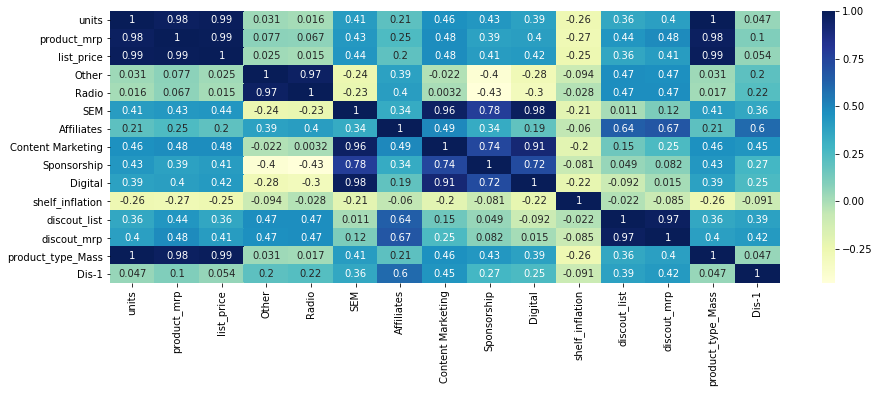

In [418]:
distributed_lr = LinearRegression()
distributed_lr.fit(x_df_with_lag_train,y_df_with_lag_train)

rfe = RFE(distributed_lr, 15)
rfe = rfe.fit(x_df_with_lag_train,y_df_with_lag_train)

# Keeping the features that are supported by RFE
x_df_with_lag_train_rfe = x_df_with_lag_train[x_df_with_lag_train.columns[rfe.support_]]

# correlation between the features
plt.figure(figsize=(15,5))
sns.heatmap(x_df_with_lag_train_rfe.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [419]:
# Creating the linear regression model
x_df_with_lag_train_sm = sm.add_constant(x_df_with_lag_train_rfe)
distributed_lr1 = get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.092e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           6.89e-48
Time:                        21:26:12   Log-Likelihood:                 223.58
No. Observations:                  37   AIC:                            -415.2
Df Residuals:                      21   BIC:                            -389.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0098      0.00

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [420]:
x_df_with_lag_train_sm.drop(['product_mrp'], 1, inplace=True)
distributed_lr2=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.213e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.14e-50
Time:                        21:26:23   Log-Likelihood:                 223.39
No. Observations:                  37   AIC:                            -416.8
Df Residuals:                      22   BIC:                            -392.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0090      0.00

In [421]:
x_df_with_lag_train_sm.drop(['Dis-1'], 1, inplace=True)
distributed_lr3=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.216e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           2.13e-52
Time:                        21:26:40   Log-Likelihood:                 221.25
No. Observations:                  37   AIC:                            -414.5
Df Residuals:                      23   BIC:                            -391.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0056      0.00

In [422]:
x_df_with_lag_train_sm.drop(['discout_list'], 1, inplace=True)
distributed_lr4=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.344e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           7.27e-55
Time:                        21:26:54   Log-Likelihood:                 220.83
No. Observations:                  37   AIC:                            -415.7
Df Residuals:                      24   BIC:                            -394.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0055      0.00

In [423]:
x_df_with_lag_train_sm.drop(['discout_mrp'], 1, inplace=True)
distributed_lr5=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.517e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.96e-57
Time:                        21:27:06   Log-Likelihood:                 220.71
No. Observations:                  37   AIC:                            -417.4
Df Residuals:                      25   BIC:                            -398.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0057      0.00

In [424]:
x_df_with_lag_train_sm.drop(['shelf_inflation'], 1, inplace=True)
distributed_lr6=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.589e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.43e-59
Time:                        21:27:19   Log-Likelihood:                 219.08
No. Observations:                  37   AIC:                            -416.2
Df Residuals:                      26   BIC:                            -398.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0044      0.00

In [425]:
x_df_with_lag_train_sm.drop(['SEM'], 1, inplace=True)
distributed_lr7=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.743e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           6.40e-62
Time:                        21:27:30   Log-Likelihood:                 218.13
No. Observations:                  37   AIC:                            -416.3
Df Residuals:                      27   BIC:                            -400.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0029      0.00

In [426]:
x_df_with_lag_train_sm.drop(['Affiliates'], 1, inplace=True)
distributed_lr8=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.836e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           5.70e-64
Time:                        21:27:40   Log-Likelihood:                 216.24
No. Observations:                  37   AIC:                            -414.5
Df Residuals:                      28   BIC:                            -400.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0013      0.00

In [427]:
x_df_with_lag_train_sm.drop(['Digital'], 1, inplace=True)
distributed_lr9=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.171e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.19e-66
Time:                        21:27:55   Log-Likelihood:                 216.22
No. Observations:                  37   AIC:                            -416.4
Df Residuals:                      29   BIC:                            -403.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0012      0.00

In [428]:
x_df_with_lag_train_sm.drop(['Radio'], 1, inplace=True)
distributed_lr10=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.445e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           6.21e-69
Time:                        21:28:04   Log-Likelihood:                 214.95
No. Observations:                  37   AIC:                            -415.9
Df Residuals:                      30   BIC:                            -404.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0012      0.00

In [429]:
x_df_with_lag_train_sm.drop(['Sponsorship'], 1, inplace=True)
distributed_lr11=get_model_and_print_summary(x_df_with_lag_train_sm,y_df_with_lag_train)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.945e+05
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.68e-71
Time:                        21:28:17   Log-Likelihood:                 214.41
No. Observations:                  37   AIC:                            -416.8
Df Residuals:                      31   BIC:                            -407.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.00

r2 score is 100.0%
RMSE is 0.0


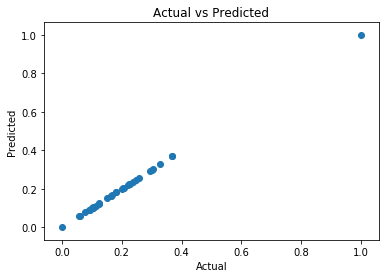

In [430]:
# Predicitng results on x_train
evaluate_model(distributed_lr11, x_df_with_lag_train_sm,y_df_with_lag_train)

**Predicting on Test data**

C:\Users\abbasis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


r2 score is 99.99%
RMSE is 0.0


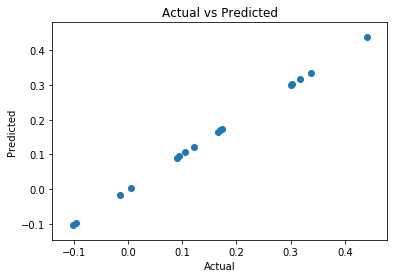

In [431]:
# Scaling the test dataset
df_with_lag_test = pd.DataFrame(distributed_scaler.transform(df_with_lag_test), columns=df_with_lag_test.columns)

# Splitting into X & Y features
y_df_with_lag_test = pd.DataFrame(df_with_lag_test.pop('gmv'))
x_df_with_lag_test = df_with_lag_test

# Keeping the significant features
x_df_with_lag_test_rfe=x_df_with_lag_test[x_df_with_lag_train_sm.iloc[:,1:].columns]
x_df_with_lag_test_rfe.head()

# Predict results on test set
x_df_with_lag_test_sm = sm.add_constant(x_df_with_lag_test_rfe)
evaluate_model(distributed_lr11,x_df_with_lag_test_sm,y_df_with_lag_test)

**K-Fold Cross Validation**

r2 score of cross validation on train dataset:
0.5545
0.9205
0.9867
-0.1261
0.7793
0.8795
Avg. r2 score 0.6657333333333333

Predicting on train dataset: 
Cross-Predicted r2 score for Train data:  92.29 %

Predicting on test dataset: 
Cross-Predicted r2 score for test data:  59.8 %


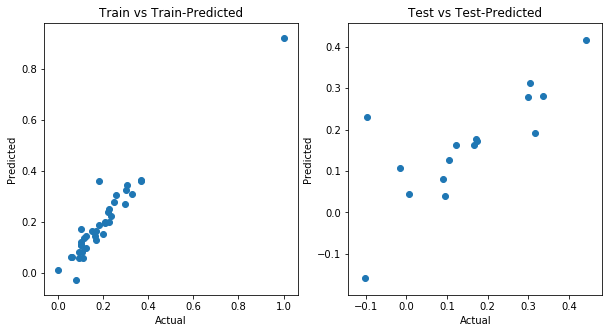

In [432]:
kfold(distributed_lr, x_df_with_lag_train,y_df_with_lag_train,x_df_with_lag_test,y_df_with_lag_test)

**Elasticity**

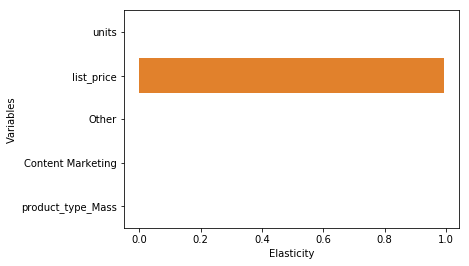

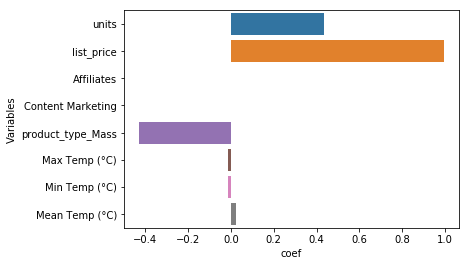

Variables      coef  Elasticity
0              units  0.432492      0.0002
1         list_price  0.993117      0.9862
2         Affiliates -0.001593     -0.0000
3  Content Marketing  0.001874      0.0000
4  product_type_Mass -0.428071     -0.0002
5      Max Temp (°C) -0.013593     -0.0000
6      Min Temp (°C) -0.013746     -0.0000
7     Mean Temp (°C)  0.024661      0.0000

In [433]:
elax=elasticity(distributed_lr11, df_with_lag)

sns.barplot(y='Variables',x='coef',data=elax_df)
plt.show()
elax_df